### Importing Tools

In [2]:
# from sixs.analysis import reciprocal_space as rs

# data manipulation
import pandas as pd
from pandas.plotting import table
import numpy as np

# system
import glob
import os

# data visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.cm import get_cmap
matplotlib.rcParams.update({'font.size': 16})

# data analysis
import scipy
from scipy.signal import find_peaks

# saving tools
import pickle

In [3]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [4]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
#     r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
#     The Savitzky-Golay filter removes high frequency noise from data.
#     It has the advantage of preserving the original shape and
#     features of the signal better than other types of filtering
#     approaches, such as moving averages techniques.
#     Parameters
#     ----------
#     y : array_like, shape (N,)
#         the values of the time history of the signal.
#     window_size : int
#         the length of the window. Must be an odd integer number.
#     order : int
#         the order of the polynomial used in the filtering.
#         Must be less then `window_size` - 1.
#     deriv: int
#         the order of the derivative to compute (default = 0 means only smoothing)
#     Returns
#     -------
#     ys : ndarray, shape (N)
#         the smoothed signal (or it's n-th derivative).
#     Notes
#     -----
#     The Savitzky-Golay is a type of low-pass filter, particularly
#     suited for smoothing noisy data. The main idea behind this
#     approach is to make for each point a least-square fit with a
#     polynomial of high order over a odd-sized window centered at
#     the point.
#     Examples
#     --------
#     t = np.linspace(-4, 4, 500)
#     y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
#     ysg = savitzky_golay(y, window_size=31, order=4)
#     import matplotlib.pyplot as plt
#     plt.plot(t, y, label='Noisy signal')
#     plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
#     plt.plot(t, ysg, 'r', label='Filtered signal')
#     plt.legend()
#     plt.show()
#     References
#     ----------
#     .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
#        Data by Simplified Least Squares Procedures. Analytical
#        Chemistry, 1964, 36 (8), pp 1627-1639.
#     .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
#        W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
#        Cambridge University Press ISBN-13: 9780521880688
#     """
    from math import factorial
    
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except ValueError as msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

### Functions

In [68]:
def put_freq(x, Int, axis, fontsize=14, rotation=90, color="black", shift_Int=25, shift_x=-10, threshold=None,
    distance=None,
    prominence=None,
    width=None,):
    """
    Adds the x axis value to the peaks of the curve.
    """
    for peak in find_peaks(Int.astype(float), threshold, distance, prominence, width)[0]:
        axis.annotate(str((x[peak])), 
                           xytext=(x[peak]+shift_x, Int[peak]+shift_Int), 
                           xy=(x[peak], Int[peak]), fontsize=fontsize, rotation=rotation, color=color)

In [69]:
def q_to_2theta(q):
    h = 6.62607015e-34 # m2 kg / s
    c = 299792458 # m/s
    E = 18.43*1.60218e-16 # joule
    lambda_ = ((h*c)/E)*1e10 # in Angstrom
    two_theta = 2*np.arcsin((lambda_*q)/(4*np.pi))*57.29 # converts rad to degree
    
    return two_theta

In [70]:
def background_removal(data, start=110, factor=0.04, deg=4):
    """ Removes background from XRD data using two sequential methods: a polynomial + a linear fit.
    data = numpy array with column 0 as x (2theta) and column 1 as y (Intensity)
    x = HZO11_Tamb_qz_2Theta
    y = HZO11_Tamb_qz_2Theta
    start = index to start the fitting (it will do the fit from the start index)
    factor = factor that helps to concatante the unffited and fitted y curves
    
    returns a numpy array with x and y removed background
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 6))
    x_beginning = data[:start, 0]
    y_beginning = data[:start, 1]

    x_to_fit = data[start:, 0]
    y_to_fit = data[start:, 1]

    z = np.polyfit(x_to_fit, y_to_fit, deg, rcond=None, full=False, w=None, cov=False)
    p = np.poly1d(z)
    
#     print("shape p is: ", p(.shape)
#     print("shape y_to_fit is: ", y_to_fit.shape)

    diff = y_to_fit-p(x_to_fit)

    ax[0].plot(data[:, 0], data[:, 1], label= "original")
    ax[0].plot(x_to_fit, p(x_to_fit), label="numpy.polyfit")
    ax[0].plot(x_to_fit, diff, label="diff")

    y_final_diff = np.concatenate((y_beginning, diff+y_to_fit[0]*2+factor),axis=0)
    x_final_diff = np.concatenate((x_beginning, x_to_fit),axis=0)
    ax[1].plot(x_final_diff, y_final_diff, label="final diff")


    y_scipy_detrend = scipy.signal.detrend(y_final_diff, axis=-1, type='linear', bp=0, overwrite_data=False)
    ax[1].plot(x_final_diff, y_scipy_detrend, label='scipy_detrend')


    # normalizing so the minimum is zero
    y_min = np.min(y_scipy_detrend)
    print("the minimum of y_scipy_detrend to normalize is: ", y_min)
    y_final = y_scipy_detrend - y_min
    ax[1].plot(x_final_diff, y_final, label='final', c='red')

    ax[1].legend()
    ax[0].legend()
    
    XRD_final_backsub = np.concatenate((np.reshape(x_final_diff, (-1, 1)), np.reshape(y_final, (-1, 1))), axis=1)
    
    return XRD_final_backsub

In [71]:
def plotting_integrations(name, filepath):
    """
    name = "HZO21"
    filepath = "Compilation_Binoculars_SIXS_HZO/HZO11*.txt"
    """
    # reading the .txt files from the integrations of the 2D map
    filenames = glob.glob(filepath)

    # opening and saving the data into a dic
    dic = {}
    for file in filenames: 
        word = [t for t in file.split(sep="\\") if t.startswith('H')]
        sample = np.loadtxt(file,  delimiter="\t", skiprows=1)
        dic[word[0]] = sample


    # Function to plot phi at Tamb
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))

    for key in dic.keys():
        Tamb = [t for t in key.split(sep="_") if t.startswith('Tamb')]
        print(key)
        if "Tamb" in Tamb:
            label = "Tamb "+key
            phi = [t for t in key.split(sep="_") if t.startswith('p')]
            if "phi" in phi: 
                # plot the phi vs q of Tamb
                idx = 0
                ylabel = "Int (integrated in phi)"
            else:
                continue

            ax.plot(dic[key][:,0], dic[key][:,1], label=label)
            ax.set_title(f"{name} (T = 25°C)")
            ax.set(xlabel="q", ylabel=ylabel, ylim=[0.1, max(dic[key][:,1])+0.2])
            ax.legend(fontsize=12)

    #         put_freq(x=dic[key][:,0], Int=dic[key][:,1], axis=ax, shift_Int=0, shift_x=0, rotation=90, width=0.05)


        plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.2, 
                        hspace=0.3)


    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,12))

    for key in dic.keys():
        Thaute = [t for t in key.split(sep="_") if t.startswith('Thaute')]
        if "Thaute" in Thaute:
            label = "Thaute "+key
            phi = [t for t in key.split(sep="_") if t.startswith('p')]
            if "phi" in phi: 
                # plot the phi vs q of Tamb
                idx = 0
                ylabel = "Int (integrated in phi)"
            else:
                # plot the qz vs q of Tamb
                idx = 1
                ylabel = "Int (integrated in qz)"
                
            ax[0, idx].set_title("T = 740°C")
            ax[0, idx].plot(dic[key][:,0], dic[key][:,1], label=label)
            ax[0, idx].set(xlabel="q", ylabel=ylabel, ylim=[0.1, max(dic[key][:,1])+0.2])
            ax[0, idx].legend(fontsize=9)

#             put_freq(x=dic[key][:,0], Int=dic[key][:,1], axis=ax[0, idx], shift_Int=0, shift_x=0, rotation=90, width=0.05)

        else:
            label = "Tamb "+key
            phi = [t for t in key.split(sep="_") if t.startswith('p')]
            if "phi" in phi: 
                # plot the phi vs q of Thaute
                idx = 0
                ylabel = "Int (integrated in phi)"
            else:
                # plot the qz vs q of Thaute
                idx = 1
                ylabel = "Int (integrated in qz)"
                
            ax[1, idx].set_title("T = 25°C")
            ax[1, idx].plot(dic[key][:,0], dic[key][:,1], label=label)
            ax[1, idx].set(xlabel="q", ylabel=ylabel, ylim=[0.1, max(dic[key][:,1])+0.2])
            ax[1, idx].legend(fontsize=9)

#             put_freq(x=dic[key][:,0], Int=dic[key][:,1], axis=ax[1, idx], shift_Int=0, shift_x=0, rotation=90, width=0.05)

        plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.2, 
                        hspace=0.3)

    fig.text(0.45, 0.95, name, fontsize = 17)
    
    return dic

In [72]:
def plotting_chosen_curves(name, dic, chosen_curves):
    """
    Plots only the chosen curves (the most clean data) from the originals.
    name = "HZO21"
    dic = return from plotting_integrations
    chosen_curves = [list of chosen curves]
    """
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,12))
    
    for key in chosen_curves:
        Thaute = [t for t in key.split(sep="_") if t.startswith('Thaute')]
        if "Thaute" in Thaute:
            label = "Thaute "+key
            phi = [t for t in key.split(sep="_") if t.startswith('p')]
            if "phi" in phi: 
                # plot the phi vs q of Tamb
                idx = 0
                ylabel = "Int (integrated in phi)"
            else:
                # plot the qz vs q of Tamb
                idx = 1
                ylabel = "Int (integrated in qz)"
                
            ax[0, idx].set_title("T = 740°C")
            ax[0, idx].plot(dic[key][:,0], dic[key][:,1], label=label)
            ax[0, idx].set(xlabel="q", ylabel=ylabel, ylim=[0.1, max(dic[key][:,1])+0.2])
            ax[0, idx].legend(fontsize=9)

            put_freq(x=dic[key][:,0], Int=dic[key][:,1], axis=ax[0, idx], shift_Int=0, shift_x=0, rotation=90, width=0.05)

        else:
            label = "Tamb "+key
            phi = [t for t in key.split(sep="_") if t.startswith('p')]
            if "phi" in phi: 
                # plot the phi vs q of Thaute
                idx = 0
                ylabel = "Int (integrated in phi)"
            else:
                # plot the qz vs q of Thaute
                idx = 1
                ylabel = "Int (integrated in qz)"
                
            ax[1, idx].set_title("T = 25°C")
            ax[1, idx].plot(dic[key][:,0], dic[key][:,1], label=label)
            ax[1, idx].set(xlabel="q", ylabel=ylabel, ylim=[0.1, max(dic[key][:,1])+0.2])
            ax[1, idx].legend(fontsize=9)

            put_freq(x=dic[key][:,0], Int=dic[key][:,1], axis=ax[1, idx], shift_Int=0, shift_x=0, rotation=90, width=0.05)

        plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.2, 
                        hspace=0.3)

### First analysis on $\theta 2 \theta$

In [9]:
# rs.Map

In [10]:
# HZO11_Tamb = rs.Map("HZO11_Tamb_ang_12-24.hdf5")

In [11]:
# projected_data = np.nansum(
#     HZO11_Tamb.data,
#     axis = (1, 2)
# )

In [12]:
# angular_step = HZO11_Tamb.delta[3]
# angular_step

In [13]:
# plt.figure(figsize=(10, 6))
# plt.plot(HZO11_Tamb.delta_axis, projected_data)
# plt.xlabel("Two theta")
# plt.ylabel("Intensity")

In [14]:
# type(HZO11_Tamb.delta_axis)

In [15]:
# projected_data

In [16]:
# filenames = glob.glob("*.hdf5")
# DRX_HZO = {}

# for file in filenames:
    
#     map_ang = rs.Map(file)
    
#     projected_data = np.nansum(
#         map_ang.data,
#         axis = (1, 2)
#     )

#     angular_step = map_ang.delta[3]
    
#     x = map_ang.delta_axis.reshape(len(map_ang.delta_axis), 1)
#     y = projected_data.reshape(len(projected_data), 1)
    
#     DRX_HZO[file] = np.concatenate((x, y), axis=1)

#     plt.figure(figsize=(10, 6))
#     plt.plot(map_ang.delta_axis, projected_data, label=file)
#     plt.xlabel("Two theta")
#     plt.ylabel("Intensity")
#     plt.legend()


In [17]:
# DRX_HZO["HZO11_HighT_ang_45-57.hdf5"][:,1]

In [18]:
# DRX_HZO_nonnull = {}
# for k in DRX_HZO.keys():
#     print(k)
# #     DRX_HZO_nonnull[k] = DRX_HZO[k][DRX_HZO[k] != 0]
#     DRX_HZO_nonnull[k] = DRX_HZO[k][DRX_HZO[k][:,1] != 0]
# #     np.where(DRX_HZO[k][1] = 0)

# DRX_HZO_nonnull

In [19]:
# plt.figure(figsize=(10, 6))
# for k in DRX_HZO_nonnull.keys():
#     plt.plot(DRX_HZO_nonnull[k][:,0], DRX_HZO_nonnull[k][:,1], label=k)
# plt.legend()    

In [20]:
# for k in DRX_HZO_nonnull.keys():
#     np.save(k[:-5]+".npy", DRX_HZO_nonnull[k])


In [21]:
filenames = glob.glob("*.npy")
HZO_DRX_raw = {}
for file in filenames:
    HZO_DRX_raw[file[:-4]] = np.load(file)

In [22]:
HZO_DRX_raw

{'HZO11_HighT_ang_45-57': array([[ 3.13      ,  0.08178255],
        [ 3.14      ,  0.0909199 ],
        [ 3.15      ,  0.10567767],
        ...,
        [36.79      , 22.4618088 ],
        [36.8       , 23.20608386],
        [36.81      , 25.87575362]]),
 'HZO11_Tamb_ang_12-24': array([[ 3.13      ,  0.08426665],
        [ 3.14      ,  0.09517969],
        [ 3.15      ,  0.11254165],
        ...,
        [36.79      , 21.30252903],
        [36.8       , 22.26696831],
        [36.81      , 24.94797114]]),
 'HZO21_Tamb_ang_222-234': array([[ 3.13      ,  0.09660356],
        [ 3.14      ,  0.11915367],
        [ 3.15      ,  0.13516147],
        ...,
        [36.79      , 44.60560932],
        [36.8       , 47.0377012 ],
        [36.81      , 52.12360802]]),
 'HZO52_Tamb_ang_466-478': array([[ 3.13      ,  0.12077765],
        [ 3.14      ,  0.1403118 ],
        [ 3.15      ,  0.16601707],
        ...,
        [36.79      , 48.76113586],
        [36.8       , 50.27394209],
        [36.8

In [23]:
for key in HZO_DRX_raw.keys():
    print(key)
# np.save(HZO_DRX_raw[])

HZO11_HighT_ang_45-57
HZO11_Tamb_ang_12-24
HZO21_Tamb_ang_222-234
HZO52_Tamb_ang_466-478
test.csv


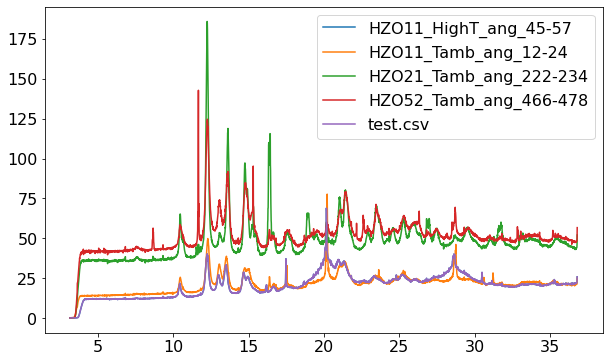

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

# white background to appears in dark jupyter theme
rect = fig.patch
rect.set_facecolor('white')

for k in HZO_DRX_raw.keys():
    ax.plot(HZO_DRX_raw[k][:,0], HZO_DRX_raw[k][:,1], label=k)
plt.legend()    

In [25]:
# ! pip install powerxrd

In [26]:
import powerxrd as xrd

In [27]:
# %%bash
# git config --global http.proxy http://proxy.synchrotron-soleil.fr:8080
# git clone https://raw.githubusercontent.com/andrewrgarcia/powerxrd/main/synthetic-data/sample{0..1}.xy
# !wget https://raw.githubusercontent.com/andrewrgarcia/powerxrd/main/synthetic-data/sample{0..4}.csv

In [28]:
# %%bash
# git clone https://raw.githubusercontent.com/andrewrgarcia/powerxrd/main/synthetic-data/sample1.csv

In [29]:
import pandas as pd
import os
# os.environ['http_proxy'] = "http://proxy.synchrotron-soleil.fr:8080" 
# os.environ['https_proxy'] = "https://proxy.synchrotron-soleil.fr:8080" 

In [30]:
# pd.read_csv("https://raw.githubusercontent.com/andrewrgarcia/powerxrd/main/synthetic-data/sample1.csv")

In [31]:
# np.savetxt("test.csv", HZO_DRX_raw["HZO11_HighT_ang_45-57"], delimiter=',')

local_max -- max x: 12.24 max y: 40.285047540381434


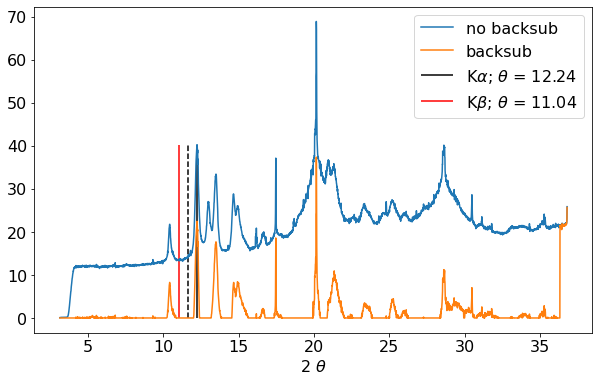

In [32]:
def test_backsub():
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # white background to appears in dark jupyter theme
    rect = fig.patch
    rect.set_facecolor('white')
    
    data = xrd.Data("test.csv".format()).importfile()
    ax.plot(*data,label='no backsub')

    chart = xrd.Chart(*data)
    chart.emission_lines(xrange_Ka=[10,20], show=True)
    ax.plot(*chart.backsub(),label='backsub')
    ax.set_xlabel('2 $\\theta$')
    ax.legend()
    
    # plt.plot(*xrd.Chart(*xrd.Data('sample1.xy').importfile()).backsub())
    # plt.show()

test_backsub()


-Gaussian fit results-
y-shift -0.5691402478452767
amplitude 15.685719529431601
mean 21.18137910520629
sigma 1.135518194597535
covariance matrix 
[[ 4.74486347e-01 -3.01187946e+00 -2.19933043e-02 -1.38039020e-01]
 [-3.01187946e+00  2.29601236e+01  3.68990266e-01  1.14876801e+00]
 [-2.19933043e-02  3.68990266e-01  2.71925754e-02  2.43828619e-02]
 [-1.38039020e-01  1.14876801e+00  2.43828619e-02  6.53061275e-02]]

SchPeak: Scherrer width calc. for peak in range of [18,22]

FWHM == sigma*2*sqrt(2*ln(2)): 2.6739410061356295 degrees
K (shape factor): 0.9
K-alpha: 0.15406 nm 
max 2-theta: 20.16 degrees

SCHERRER WIDTH: 3.017582235696759 nm


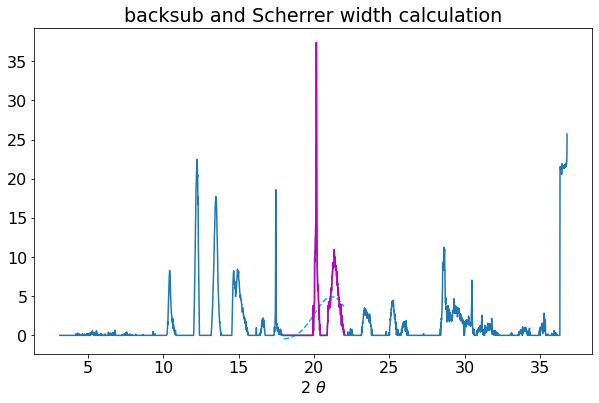

In [33]:
def test_sch():
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # white background to appears in dark jupyter theme
    rect = fig.patch
    rect.set_facecolor('white')
    
    data = xrd.Data("test.csv".format()).importfile()
    
    chart = xrd.Chart(*data)
    chart.backsub(tol=1.0,show=True)
    chart.SchPeak(xrange=[18,22],verbose=True,show=True)
    
    plt.xlabel('2 $\\theta$')
    plt.title('backsub and Scherrer width calculation')
    plt.show()

test_sch()

In [34]:
# def test_allpeaks():
    
#     fig, ax = plt.subplots(figsize=(10, 6))
    
#     # white background to appears in dark jupyter theme
#     rect = fig.patch
#     rect.set_facecolor('white')
    
#     data = xrd.Data("test.csv".format()).importfile()
    
#     chart = xrd.Chart(*data)
#     chart.backsub(tol=1,show=True)
#     chart.allpeaks(tols=(0.1,0.8), verbose=False, show=True)
#     ax.set_xlabel('2 $\\theta$')
#     ax.suptitle('backsub & Automated Scherrer width calculation of all peaks*')


# test_allpeaks()

### Full analysis of HZO polycristalline films
- Using binoculars at SIXS, I integrated in the azimutal $\phi$ and in the $\vec{q}_z$ spaces as a function of $q$ for different zones of the 2D maps (trying to visually avoid any Bragg peak from the substrate). 
- Integrating inva zone of the map offers a better statistics than just cutting the map in one direction
- After this, I have 12 set of curves:
    - 2 integrations ($\phi$ and $\vec{q}_z$) for high and low temperatures of HZO 11, HZO 21 and HZO 52 nm.

In [10]:
! dir

 Volume in drive C is Windows
 Volume Serial Number is A8E0-A899

 Directory of C:\Users\rebce\OneDrive\Python\SXRD_Rebecca

23/03/2023  11:35    <DIR>          .
23/03/2023  11:35    <DIR>          ..
15/03/2023  09:06    <DIR>          .ipynb_checkpoints
21/02/2023  19:01    <DIR>          Compilation_Binoculars_SIXS_HZO
14/02/2023  19:02    <DIR>          DFT_DRX
21/02/2023  19:01    <DIR>          FINAL_Background_Removal
13/12/2022  19:37    <DIR>          https?
27/10/2022  17:06         1,767,326 HZO11_HighT_ang_45-57.hdf5
08/02/2023  15:34            52,624 HZO11_HighT_ang_45-57.npy
21/02/2023  13:57            26,469 HZO11_phi.txt
21/02/2023  13:57          (26,469) HZO11_qz.txt
27/10/2022  17:06         1,765,778 HZO11_Tamb_ang_12-24.hdf5
08/02/2023  15:34            52,624 HZO11_Tamb_ang_12-24.npy
10/02/2023  17:46         (167,331) HZO11_Tamb_ang_12_24_momone.xy
21/02/2023  13:57          (26,469) HZO11_Tamb_phi.txt
21/02/2023  13:57          (26,469) HZO11_Tamb_qz.txt
15/0

### HZO 11nm

#### T amb

In [73]:
filenames_HZO11 = glob.glob("Compilation_Binoculars_SIXS_HZO/HZO11*.txt")
filenames_HZO11

['Compilation_Binoculars_SIXS_HZO\\HZO11_Tamb_phi_-109_-107_q_resqz0p01.txt',
 'Compilation_Binoculars_SIXS_HZO\\HZO11_Tamb_phi_-163_-143_q_resqz0p01.txt',
 'Compilation_Binoculars_SIXS_HZO\\HZO11_Tamb_phi_-81_-57_q_resqz0p01.txt',
 'Compilation_Binoculars_SIXS_HZO\\HZO11_Tamb_phi_104_115_q_resqz0p01.txt',
 'Compilation_Binoculars_SIXS_HZO\\HZO11_Tamb_phi_18_35_q_resqz0p01.txt',
 'Compilation_Binoculars_SIXS_HZO\\HZO11_Tamb_phi_68_78_q_resqz0p01.txt',
 'Compilation_Binoculars_SIXS_HZO\\HZO11_Tamb_qz_0p08_0p15_q_resqz0p01_2.txt',
 'Compilation_Binoculars_SIXS_HZO\\HZO11_Thaute_phi_-72_-64_q_resqz0p01.txt',
 'Compilation_Binoculars_SIXS_HZO\\HZO11_Thaute_qz_0p09_0p12_q_resqz0p01.txt']

In [74]:
HZO11 = {}
for file in filenames_HZO11: 
    word = [t for t in file.split(sep="\\") if t.startswith('H')]
    print(word)
    sample = np.loadtxt(file,  delimiter="\t", skiprows=1)
    HZO11[word[0]] = sample

['HZO11_Tamb_phi_-109_-107_q_resqz0p01.txt']
['HZO11_Tamb_phi_-163_-143_q_resqz0p01.txt']
['HZO11_Tamb_phi_-81_-57_q_resqz0p01.txt']
['HZO11_Tamb_phi_104_115_q_resqz0p01.txt']
['HZO11_Tamb_phi_18_35_q_resqz0p01.txt']
['HZO11_Tamb_phi_68_78_q_resqz0p01.txt']
['HZO11_Tamb_qz_0p08_0p15_q_resqz0p01_2.txt']
['HZO11_Thaute_phi_-72_-64_q_resqz0p01.txt']
['HZO11_Thaute_qz_0p09_0p12_q_resqz0p01.txt']


In [75]:
(HZO11['HZO11_Tamb_phi_-109_-107_q_resqz0p01.txt'][:, 1]).shape

(539,)

Lets check the HZO11 à T= 25° and choose one of the curves:
- with comparison witht eh 2D maps, the one with less "false" peaks (impurities n the surfac) is the red curve names `HZO11_Tamb_phi_104_115_q_resqz0p01.txt` 

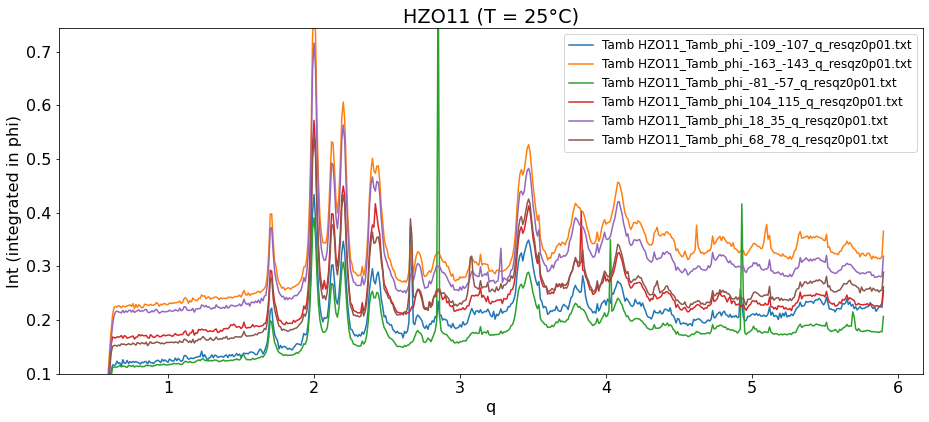

In [76]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))

for key in HZO11.keys():
    Tamb = [t for t in key.split(sep="_") if t.startswith('Tamb')]
#     print(Tamb)
    if "Tamb" in Tamb:
        label = "Tamb "+key
        phi = [t for t in key.split(sep="_") if t.startswith('p')]
#         print(phi)
        if "phi" in phi: 
#             print(key)
            # plot the phi vs q of Tamb
            idx = 0
            ylabel = "Int (integrated in phi)"
        else:
            continue
        
        ax.set_title("HZO11 (T = 25°C)")
        ax.plot(HZO11[key][:,0], HZO11[key][:,1], label=label)
        ax.set(xlabel="q", ylabel=ylabel, ylim=[0.1, max(HZO11[key][:,1])+0.2])
        ax.legend(fontsize=12)
        
#         put_freq(x=HZO11[key][:,0], Int=HZO11[key][:,1], axis=ax, shift_Int=0, shift_x=0, rotation=90, width=0.05)

        
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3)

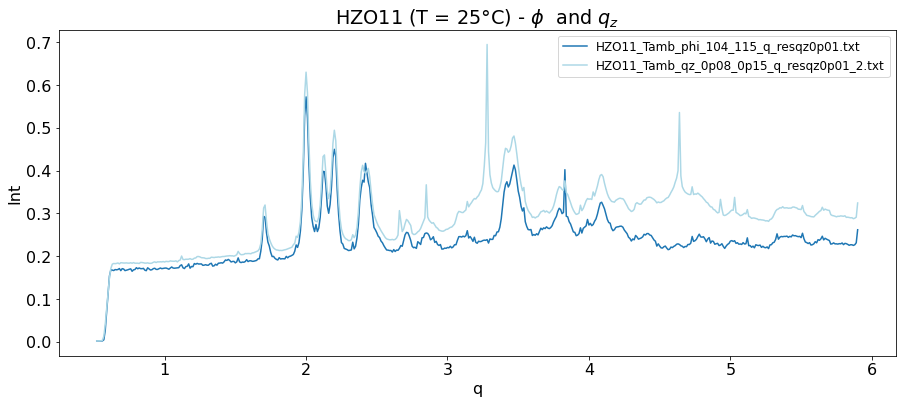

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))

ax.set_title("HZO11 (T = 25°C) - $\phi$  and $q_z$") 

ax.plot(HZO11['HZO11_Tamb_phi_104_115_q_resqz0p01.txt'][:,0],
        HZO11['HZO11_Tamb_phi_104_115_q_resqz0p01.txt'][:,1], 
        label='HZO11_Tamb_phi_104_115_q_resqz0p01.txt')

ax.plot(HZO11['HZO11_Tamb_qz_0p08_0p15_q_resqz0p01_2.txt'][:,0], 
        HZO11['HZO11_Tamb_qz_0p08_0p15_q_resqz0p01_2.txt'][:,1], 
        label='HZO11_Tamb_qz_0p08_0p15_q_resqz0p01_2.txt',
        c="lightblue")

ax.set(xlabel="q", ylabel="Int") #, ylim=[0.1, max(HZO11[key][:,1])+0.2])
ax.legend(fontsize=12)

#         put_freq(x=HZO11[key][:,0], Int=HZO11[key][:,1], axis=ax, shift_Int=0, shift_x=0, rotation=90, width=0.05)


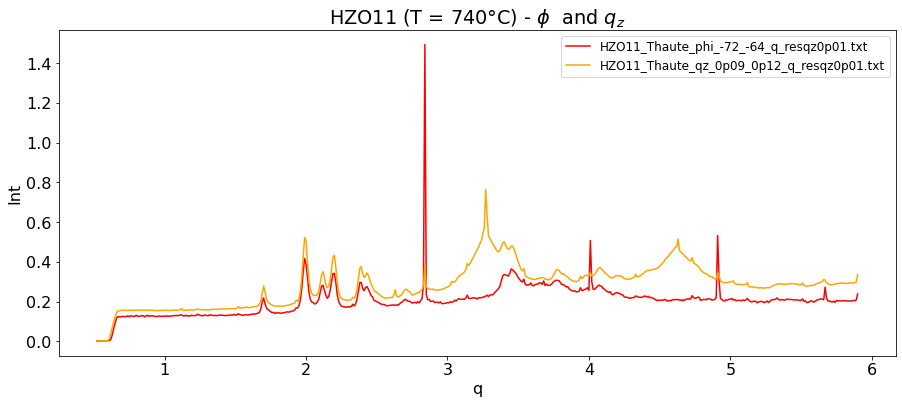

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))

ax.set_title("HZO11 (T = 740°C) - $\phi$  and $q_z$") 

ax.plot(HZO11['HZO11_Thaute_phi_-72_-64_q_resqz0p01.txt'][:,0],
        HZO11['HZO11_Thaute_phi_-72_-64_q_resqz0p01.txt'][:,1], 
        label='HZO11_Thaute_phi_-72_-64_q_resqz0p01.txt',
        c='red')

ax.plot(HZO11['HZO11_Thaute_qz_0p09_0p12_q_resqz0p01.txt'][:,0], 
        HZO11['HZO11_Thaute_qz_0p09_0p12_q_resqz0p01.txt'][:,1], 
        label='HZO11_Thaute_qz_0p09_0p12_q_resqz0p01.txt',
        c='orange')

ax.set(xlabel="q", ylabel="Int") #, ylim=[0.1, max(HZO11[key][:,1])+0.2])
ax.legend(fontsize=12)

#         put_freq(x=HZO11[key][:,0], Int=HZO11[key][:,1], axis=ax, shift_Int=0, shift_x=0, rotation=90, width=0.05)


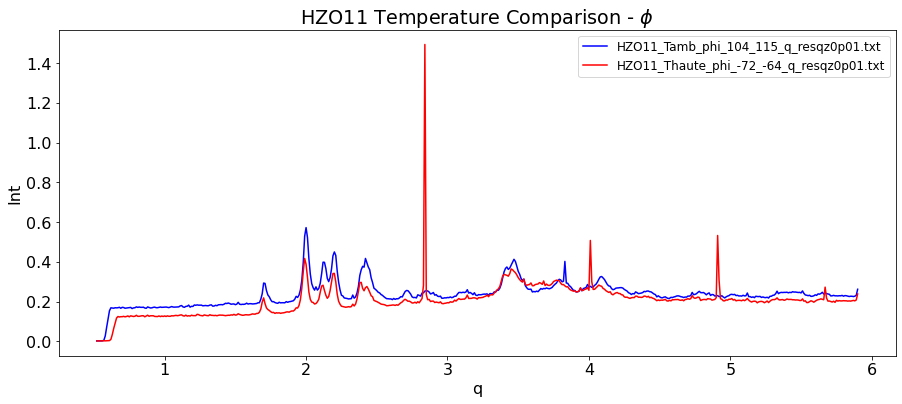

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))

ax.set_title("HZO11 Temperature Comparison - $\phi$") 

key1= 'HZO11_Tamb_phi_104_115_q_resqz0p01.txt'

ax.plot(HZO11[key1][:,0],
        HZO11[key1][:,1], 
        label=key1,
        c='blue')

key2= 'HZO11_Thaute_phi_-72_-64_q_resqz0p01.txt'

ax.plot(HZO11[key2][:,0], 
        HZO11[key2][:,1], 
        label=key2,
        c="red")

ax.set(xlabel="q", ylabel="Int") #, ylim=[0.1, max(HZO11[key][:,1])+0.2])
ax.legend(fontsize=12)

#         put_freq(x=HZO11[key][:,0], Int=HZO11[key][:,1], axis=ax, shift_Int=0, shift_x=0, rotation=90, width=0.05)

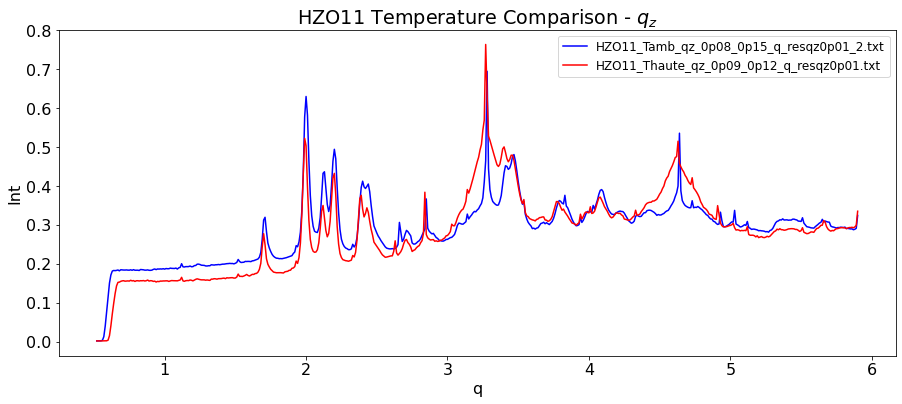

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))

ax.set_title("HZO11 Temperature Comparison - $q_z$") 

# T ambient
key1= 'HZO11_Tamb_qz_0p08_0p15_q_resqz0p01_2.txt'

ax.plot(HZO11[key1][:,0],
        HZO11[key1][:,1], 
        label=key1,
        c='blue')

# High T
key2= 'HZO11_Thaute_qz_0p09_0p12_q_resqz0p01.txt'

ax.plot(HZO11[key2][:,0], 
        HZO11[key2][:,1], 
        label=key2,
        c="red")

ax.set(xlabel="q", ylabel="Int") #, ylim=[0.1, max(HZO11[key][:,1])+0.2])
ax.legend(fontsize=12)

#         put_freq(x=HZO11[key][:,0], Int=HZO11[key][:,1], axis=ax, shift_Int=0, shift_x=0, rotation=90, width=0.05)

Text(0.45, 1, 'HZO 11nm')

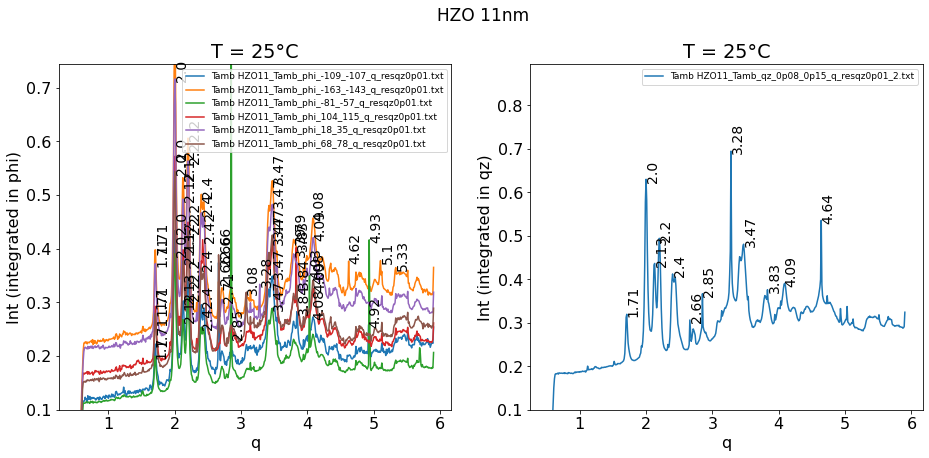

In [81]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

for key in HZO11.keys():
    Tamb = [t for t in key.split(sep="_") if t.startswith('Tamb')]
#     print(Tamb)
    if "Tamb" in Tamb:
        label = "Tamb "+key
        phi = [t for t in key.split(sep="_") if t.startswith('p')]
#         print(phi)
        if "phi" in phi: 
#             print(key)
            # plot the phi vs q of Tamb
            idx = 0
            ylabel = "Int (integrated in phi)"
        else:
            # plot the qz vs q of Tamb
            idx = 1
            ylabel = "Int (integrated in qz)"
        ax[idx].set_title("T = 25°C")
        ax[idx].plot(HZO11[key][:,0], HZO11[key][:,1], label=label)
        ax[idx].set(xlabel="q", ylabel=ylabel, ylim=[0.1, max(HZO11[key][:,1])+0.2])
        ax[idx].legend(fontsize=9)
        
        put_freq(x=HZO11[key][:,0], Int=HZO11[key][:,1], axis=ax[idx], shift_Int=0, shift_x=0, rotation=90, width=0.05)

        
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3)
    
fig.text(0.45, 1, 'HZO 11nm', fontsize = 17)

Text(0.45, 0.95, 'HZO 11nm')

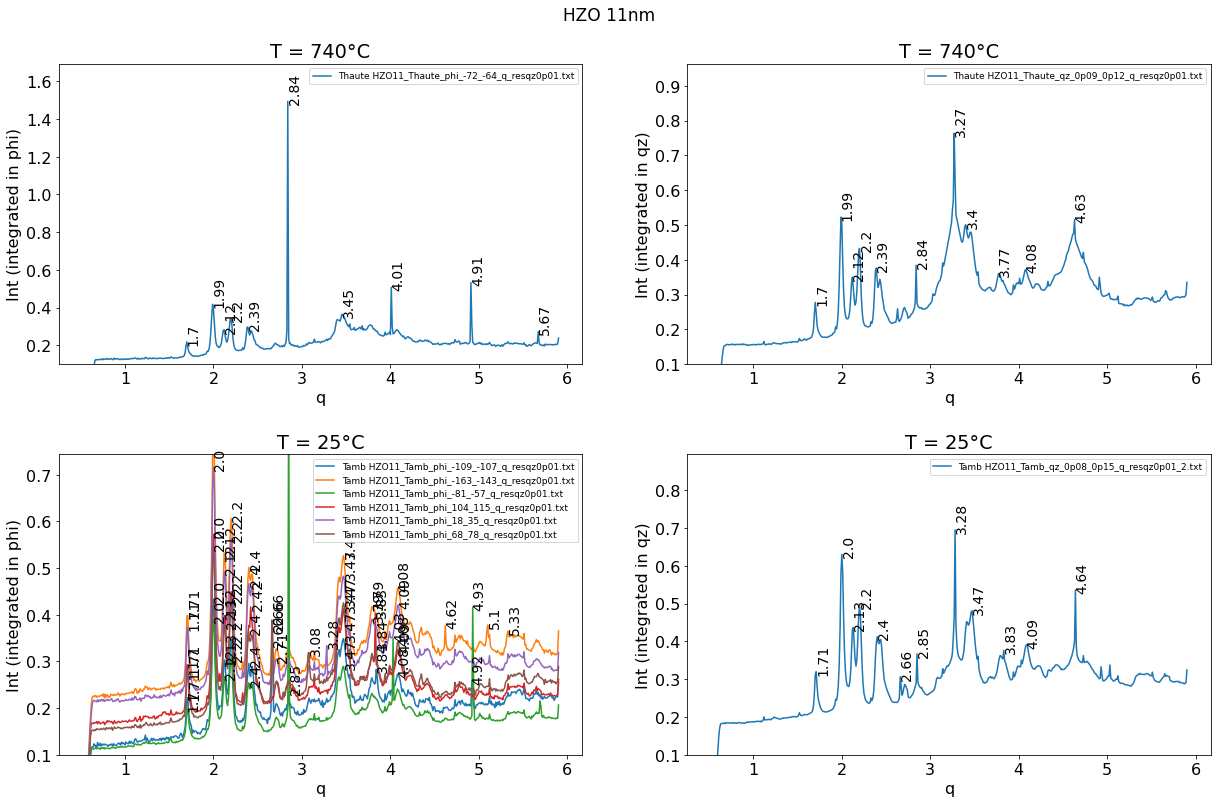

In [82]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,12))

for key in HZO11.keys():
    Thaute = [t for t in key.split(sep="_") if t.startswith('Thaute')]
    if "Thaute" in Thaute:
        label = "Thaute "+key
        phi = [t for t in key.split(sep="_") if t.startswith('p')]
#         print(phi)
        if "phi" in phi: 
#             print(key)
            # plot the phi vs q of Tamb
            idx = 0
            ylabel = "Int (integrated in phi)"
        else:
            # plot the qz vs q of Tamb
            idx = 1
            ylabel = "Int (integrated in qz)"
        ax[0, idx].set_title("T = 740°C")
        ax[0, idx].plot(HZO11[key][:,0], HZO11[key][:,1], label=label)
        ax[0, idx].set(xlabel="q", ylabel=ylabel, ylim=[0.1, max(HZO11[key][:,1])+0.2])
        ax[0, idx].legend(fontsize=9)
        
        put_freq(x=HZO11[key][:,0], Int=HZO11[key][:,1], axis=ax[0, idx], shift_Int=0, shift_x=0, rotation=90, width=0.05)
        
    else:
        label = "Tamb "+key
        phi = [t for t in key.split(sep="_") if t.startswith('p')]
#         print(phi)
        if "phi" in phi: 
#             print(key)
            # plot the phi vs q of Thaute
            idx = 0
            ylabel = "Int (integrated in phi)"
        else:
            # plot the qz vs q of Thaute
            idx = 1
            ylabel = "Int (integrated in qz)"
        ax[1, idx].set_title("T = 25°C")
        ax[1, idx].plot(HZO11[key][:,0], HZO11[key][:,1], label=label)
        ax[1, idx].set(xlabel="q", ylabel=ylabel, ylim=[0.1, max(HZO11[key][:,1])+0.2])
        ax[1, idx].legend(fontsize=9)
        
        put_freq(x=HZO11[key][:,0], Int=HZO11[key][:,1], axis=ax[1, idx], shift_Int=0, shift_x=0, rotation=90, width=0.05)
        
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3)
    
fig.text(0.45, 0.95, 'HZO 11nm', fontsize = 17)

### Remove the false peaks from XRD data

In [83]:
from scipy import optimize

In [84]:
def rect(x_axis, y_axis, start_lin, stop_lin, start_pol, stop_pol, R_start, R_stop, axis_xmin, axis_xmax):
    
    y_piece1 = y_axis[:start_lin]
    y_piece2 = y_axis[stop_lin:]
    print(len(y_piece1))
    print(len(y_piece2))
    
    #Make new y points
    n1 = len(x_axis[start_lin:stop_lin])
#     print(n)
    y_new1 = np.linspace(R_start, R_stop, n1)
    x_new1 = x_axis[start_lin:stop_lin]
    final_line1 = np.concatenate((y_piece1, y_new1, y_piece2), axis=0)
    
    print(len(final_line1))
    print(len(x_axis))

    #Section to fit points
    y1 = y_axis[start_pol:stop_pol]
    x1 = x_axis[start_pol:stop_pol]

    #Polynomial of second degree
    def f(x, a, b, c):
        return -a * x**2  + b * x + c
    params, params_cov = optimize.curve_fit(f, x1, final_line1[start_pol:stop_pol])
    fit1 = f(x1, params[0], params[1],params[2])

    #Plot new points together with the rest of spectrum
    plt.plot(x1, fit1 , c='green', label = ("2nd degree polynomial fit"))

#     print(start_lin-start_pol+1)
    fit_final = fit1[(start_lin-start_pol+1):(stop_lin-start_lin+start_lin-start_pol+1)]
    print('length of fit_final is ' + str(len(fit_final)))
    final_concat = np.concatenate((y_piece1, fit1[(start_lin-start_pol):(stop_lin-start_lin+start_lin-start_pol+1)], y_piece2), axis=0)

    plt.plot(x_axis, final_line1, c='red', label = 'original')
    plt.plot(x_axis, y_axis, c='black', label = 'connected by a line')
    plt.plot(x_axis, final_concat, c='blue', label='final merged')
    plt.legend()
    plt.axis([axis_xmin, axis_xmax, -0.05, 0.8])
    plt.rcParams["figure.figsize"] = (10.5,5.5)
    plt.show()

    return fit_final



### HZO 11
- selected curves are:
   - For $\phi$:
        - 'HZO11_Tamb_phi_104_115_q_resqz0p01.txt'
        - 'HZO11_Thaute_phi_-72_-64_q_resqz0p01.txt'
   - For $q_z$:
        - 'HZO11_Tamb_qz_0p08_0p15_q_resqz0p01_2.txt'
        - 'HZO11_Thaute_qz_0p09_0p12_q_resqz0p01.txt'

### HZO11 - $\phi$ - Thaute

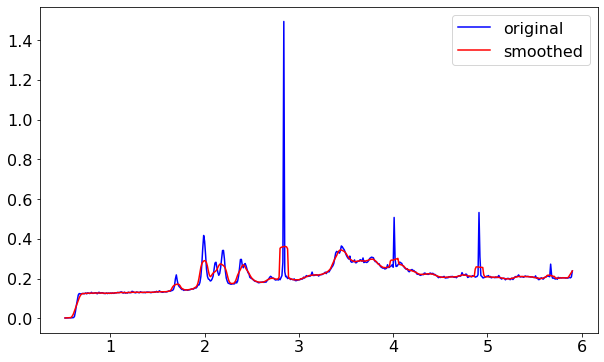

<Figure size 432x288 with 0 Axes>

In [85]:
# Lets smooth to remove very thin peaks
plt.subplots(figsize=(10,6))

key2 = 'HZO11_Thaute_phi_-72_-64_q_resqz0p01.txt'

x = HZO11[key2][:,0]
y = HZO11[key2][:,1]
yhat = savitzky_golay(y, 9, 1) # window size 51, polynomial order 3

plt.plot(x,y, c='blue', label='original')
plt.plot(x,yhat, color='red', label='smoothed')

# plt.xlim(5.5, 6)


plt.legend()
plt.figure()
plt.show()

225
299
539
539
length of fit_final is 14


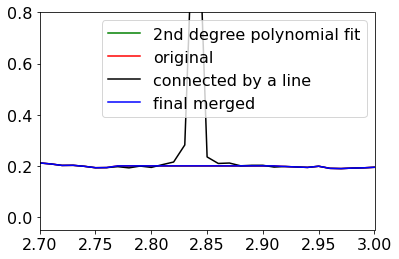

348
184
539
539
length of fit_final is 6


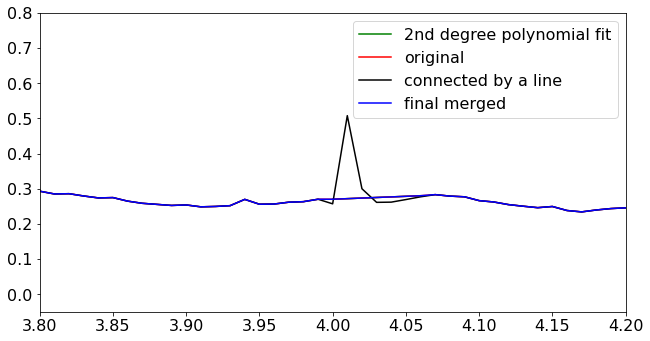

438
95
539
539
length of fit_final is 5


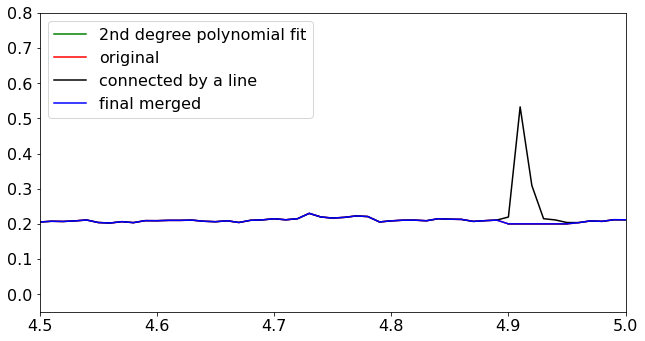

513
19
539
539
length of fit_final is 6


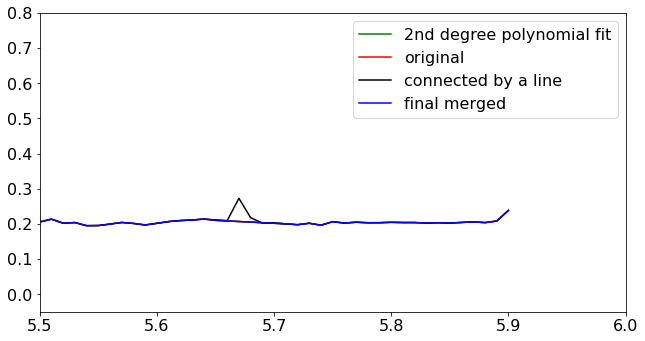

In [86]:
key2 = 'HZO11_Thaute_phi_-72_-64_q_resqz0p01.txt'

x_axis = HZO11[key2][:,0]
y_axis = HZO11[key2][:,1]

start1=225
stop1=240

a = rect(x_axis, y_axis, start_lin=start1, stop_lin=stop1, 
      start_pol=start1, stop_pol=stop1, 
      R_start=0.2, R_stop=0.2, axis_xmin=2.7, axis_xmax=3.0)

start2=348
stop2=355

b = rect(x_axis, y_axis, start_lin=start2, stop_lin=stop2, 
      start_pol=start2, stop_pol=stop2, 
      R_start=0.27, R_stop=0.28, axis_xmin=3.8, axis_xmax=4.2)

start3=438
stop3=444

c = rect(x_axis, y_axis, start_lin=start3, stop_lin=stop3, 
      start_pol=start3, stop_pol=stop3, 
      R_start=0.2, R_stop=0.2, axis_xmin=4.5, axis_xmax=5)

start4=513
stop4=520

d = rect(x_axis, y_axis, start_lin=start4, stop_lin=stop4, 
      start_pol=start4, stop_pol=stop4, 
      R_start=0.21, R_stop=0.2, axis_xmin=5.5, axis_xmax=6)




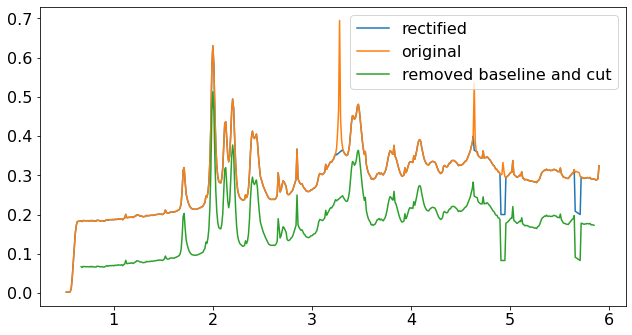

In [104]:
rect_complet = np.concatenate(( 
                          y_axis[:start1+1], a, 
                          y_axis[stop1:start2+1], b,
                          y_axis[stop2:start3+1], c, 
                          y_axis[stop3:start4+1], d,
                          y_axis[stop4:]
                                ), axis=0)


plt.plot(x_axis, rect_complet, label="rectified")

plt.plot(HZO11[key2][:,0], HZO11[key2][:,1], label="original")

HZO11_Thaute_phi_x = x_axis[15:-5]
HZO11_Thaute_phi_y = (rect_complet-0.117107)[15:-5]

plt.plot(HZO11_Thaute_phi_x, HZO11_Thaute_phi_y, label="removed baseline and cut")

plt.legend()

### HZO11 - $q_z$ - Thaute

In [87]:
np.where(HZO11[key2][:,0]==4.6)

(array([408], dtype=int64),)

270
261
539
539
length of fit_final is 7


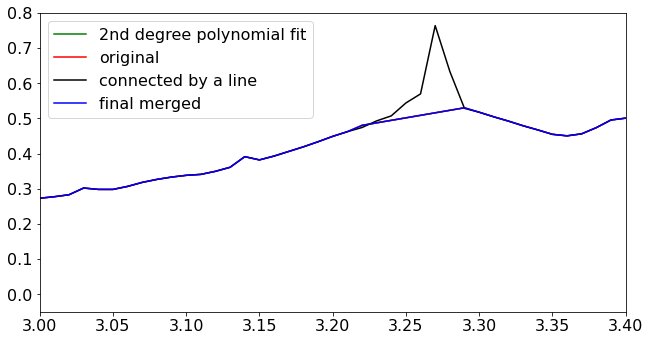

410
126
539
539
length of fit_final is 2


c:\users\rebce\appdata\local\programs\python\python37\lib\site-packages\scipy\optimize\minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


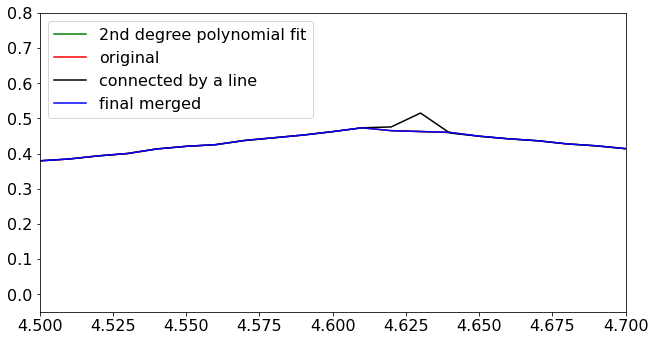

In [88]:
key2 = 'HZO11_Thaute_qz_0p09_0p12_q_resqz0p01.txt'

x_axis = HZO11[key2][:,0]
y_axis = HZO11[key2][:,1]

start1=270
stop1=278

a = rect(x_axis, y_axis, start_lin=start1, stop_lin=stop1, 
      start_pol=start1, stop_pol=stop1, 
      R_start=0.48, R_stop=0.53, axis_xmin=3, axis_xmax=3.4)

start2=410
stop2=413

b = rect(x_axis, y_axis, start_lin=start2, stop_lin=stop2, 
      start_pol=start2, stop_pol=stop2, 
      R_start=0.465, R_stop=0.46, axis_xmin=4.5, axis_xmax=4.7)

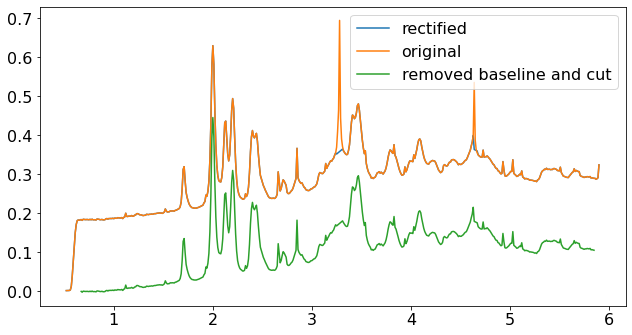

In [98]:
rect_complet = np.concatenate(( 
                          y_axis[:start1+1], a, 
                          y_axis[stop1:start2+1], b,
                          y_axis[stop2:]
                                ), axis=0)


plt.plot(x_axis, rect_complet, label="rectified")

plt.plot(HZO11[key2][:,0], HZO11[key2][:,1], label="original")

HZO11_Thaute_qz_x = x_axis[15:-5]
HZO11_Thaute_qz_y = (rect_complet-HZO11[key2][:,1][15])[15:-5]

plt.plot(HZO11_Thaute_qz_x, HZO11_Thaute_qz_y, label="removed baseline and cut")

plt.legend()

### HZO11 - $q_z$ - Tamb

272
259
539
539
length of fit_final is 7


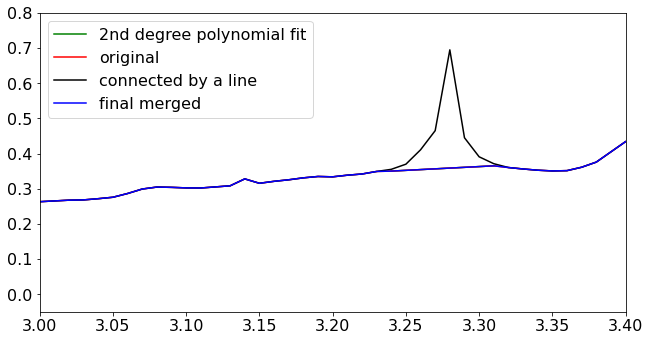

411
123
539
539
length of fit_final is 4


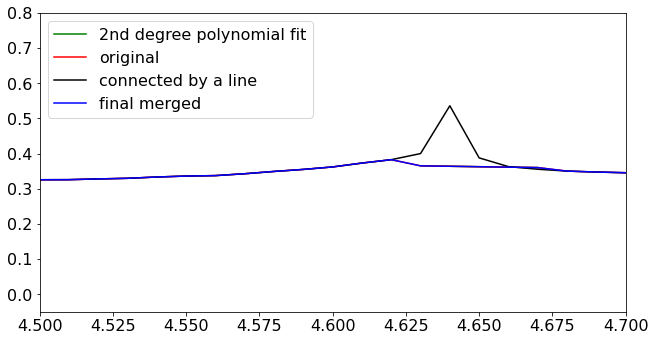

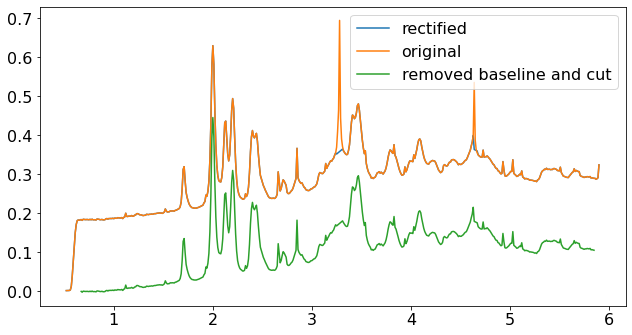

In [89]:
key2 = 'HZO11_Tamb_qz_0p08_0p15_q_resqz0p01_2.txt'

x_axis = HZO11[key2][:,0]
y_axis = HZO11[key2][:,1]

start1=272
stop1=280

a = rect(x_axis, y_axis, start_lin=start1, stop_lin=stop1, 
      start_pol=start1, stop_pol=stop1, 
      R_start=0.35, R_stop=0.365, axis_xmin=3, axis_xmax=3.4)

start2=411
stop2=416

b = rect(x_axis, y_axis, start_lin=start2, stop_lin=stop2, 
      start_pol=start2, stop_pol=stop2, 
      R_start=0.365, R_stop=0.36, axis_xmin=4.5, axis_xmax=4.7)


rect_complet = np.concatenate(( 
                          y_axis[:start1+1], a, 
                          y_axis[stop1:start2+1], b,
                          y_axis[stop2:]
                                ), axis=0)


plt.plot(x_axis, rect_complet, label="rectified")

plt.plot(HZO11[key2][:,0], HZO11[key2][:,1], label="original")

HZO11_Tamb_qz_x = x_axis[15:-5]
HZO11_Tamb_qz_y = (rect_complet-HZO11[key2][:,1][15])[15:-5]

plt.plot(HZO11_Tamb_qz_x, HZO11_Tamb_qz_y, label="removed baseline and cut")

plt.legend()

### Saving treaded files into a .txt to put in MAUD

In [94]:
np.reshape(HZO11_Tamb_qz_x, (-1, 1)).shape

(519, 1)

In [95]:
HZO11_Tamb_qz_final = np.concatenate((np.reshape(HZO11_Tamb_qz_x, (-1, 1)), np.reshape(HZO11_Tamb_qz_y, (-1, 1))), axis=1)
HZO11_Tamb_qz_final

array([[ 6.70000e-01,  0.00000e+00],
       [ 6.80000e-01, -2.08300e-03],
       [ 6.90000e-01,  6.26000e-04],
       ...,
       [ 5.83000e+00,  1.06999e-01],
       [ 5.84000e+00,  1.06192e-01],
       [ 5.85000e+00,  1.05511e-01]])

In [96]:
np.savetxt("HZO11_Tamb_qz_final.txt", HZO11_Tamb_qz_final)

In [101]:
HZO11_Thaute_qz_final = np.concatenate((np.reshape(HZO11_Thaute_qz_x, (-1, 1)), np.reshape(HZO11_Thaute_qz_y, (-1, 1))), axis=1)
HZO11_Thaute_qz_final

array([[ 6.70000e-01,  0.00000e+00],
       [ 6.80000e-01, -2.08300e-03],
       [ 6.90000e-01,  6.26000e-04],
       ...,
       [ 5.83000e+00,  1.06999e-01],
       [ 5.84000e+00,  1.06192e-01],
       [ 5.85000e+00,  1.05511e-01]])

In [102]:
np.savetxt("HZO11_Thaute_qz_final.txt", HZO11_Thaute_qz_final)

In [105]:
HZO11_Thaute_phi_final = np.concatenate((np.reshape(HZO11_Thaute_phi_x, (-1, 1)), np.reshape(HZO11_Thaute_phi_y, (-1, 1))), axis=1)
HZO11_Thaute_phi_final

array([[0.67    , 0.067117],
       [0.68    , 0.065034],
       [0.69    , 0.067743],
       ...,
       [5.83    , 0.174116],
       [5.84    , 0.173309],
       [5.85    , 0.172628]])

In [106]:
np.savetxt("HZO11_Thaute_phi_final.txt", HZO11_Thaute_phi_final)

In [107]:
np.savetxt("HZO11_Tamb_phi_final.txt", HZO11['HZO11_Tamb_phi_104_115_q_resqz0p01.txt'])

#### Converting to 2theta and saving into .xy file 

In [108]:
h = 6.62607015e-34 # m2 kg / s
c = 299792458 # m/s
E = 18.43*1.60218e-16 # joule

In [109]:
E

2.95281774e-15

In [110]:
# E = h*c/lambda_
lambda_ = ((h*c)/E)*1e10 # in Angstrom
lambda_

0.6727289091499865

In [111]:
q = HZO11_Tamb_qz_x
# q

In [112]:
# q = (4*np.pi/lambda_)*np.sin(2*theta/2)
two_theta = 2*np.arcsin((lambda_*q)/(4*np.pi))
# two_theta

In [113]:
def q_to_2theta(q):
    h = 6.62607015e-34 # m2 kg / s
    c = 299792458 # m/s
    E = 18.43*1.60218e-16 # joule
    lambda_ = ((h*c)/E)*1e10 # in Angstrom
    two_theta = 2*np.arcsin((lambda_*q)/(4*np.pi))*57.29 # converts rad to degree
    
    return two_theta

In [114]:
np.pi

3.141592653589793

In [115]:
lambda_

0.6727289091499865

In [116]:
np.arcsin((5*0.67)/(4*3.14))*57.29

15.467605018485571

#### Lets check if the x axis of all files are different or not

In [117]:
np.array_equal(HZO11_Tamb_qz_x, HZO11_Thaute_qz_x)

True

In [118]:
np.array_equal(HZO11_Thaute_phi_x, HZO11['HZO11_Tamb_phi_104_115_q_resqz0p01.txt'][:,0])

False

In [119]:
# HZO11['HZO11_Tamb_phi_104_115_q_resqz0p01.txt'][:,0]

In [120]:
# HZO11_Thaute_phi_x

In [121]:
HZO11_Thaute_phi_x_2Theta = q_to_2theta(HZO11_Thaute_phi_x)
# HZO11_Thaute_phi_x_2Theta

In [122]:
HZO11_Tamb_phi_x_2Theta = q_to_2theta(HZO11['HZO11_Tamb_phi_104_115_q_resqz0p01.txt'][:,0])
# HZO11_Tamb_phi_x_2Theta

In [123]:
HZO11_Tamb_qz_x_2Theta = q_to_2theta(HZO11_Tamb_qz_x)
HZO11_Tamb_qz_x_2Theta

array([ 4.11061698,  4.1719964 ,  4.23337702,  4.29475885,  4.35614191,
        4.41752623,  4.47891182,  4.54029869,  4.60168687,  4.66307636,
        4.7244672 ,  4.78585939,  4.84725296,  4.90864792,  4.9700443 ,
        5.03144209,  5.09284134,  5.15424205,  5.21564424,  5.27704793,
        5.33845313,  5.39985987,  5.46126816,  5.52267802,  5.58408947,
        5.64550253,  5.70691721,  5.76833352,  5.8297515 ,  5.89117116,
        5.9525925 ,  6.01401557,  6.07544036,  6.13686689,  6.1982952 ,
        6.25972528,  6.32115717,  6.38259088,  6.44402642,  6.50546382,
        6.56690309,  6.62834425,  6.68978732,  6.75123232,  6.81267926,
        6.87412816,  6.93557904,  6.99703191,  7.05848681,  7.11994373,
        7.18140271,  7.24286376,  7.30432689,  7.36579213,  7.42725949,
        7.48872899,  7.55020065,  7.61167448,  7.67315051,  7.73462875,
        7.79610923,  7.85759195,  7.91907693,  7.9805642 ,  8.04205378,
        8.10354567,  8.1650399 ,  8.22653649,  8.28803545,  8.34

#### Concatenate the converted to 2Theta arrays

In [124]:
HZO11_Thaute_qz_2Theta = np.concatenate((np.reshape(HZO11_Tamb_qz_x_2Theta, (-1, 1)), np.reshape(HZO11_Thaute_qz_y, (-1, 1))), axis=1)
np.savetxt("HZO11_Thaute_qz_2Theta.txt", HZO11_Thaute_qz_2Theta)

In [125]:
HZO11_Tamb_qz_2Theta = np.concatenate((np.reshape(HZO11_Tamb_qz_x_2Theta, (-1, 1)), np.reshape(HZO11_Tamb_qz_y, (-1, 1))), axis=1)
np.savetxt("HZO11_Tamb_qz_2Theta.txt", HZO11_Tamb_qz_2Theta) 

In [126]:
HZO11_Thaute_phi_2Theta = np.concatenate((np.reshape(HZO11_Thaute_phi_x_2Theta, (-1, 1)), np.reshape(HZO11_Thaute_phi_y, (-1, 1))), axis=1)
np.savetxt("HZO11_Thaute_phi_2Theta.txt", HZO11_Thaute_phi_2Theta)  

In [127]:
HZO11_Tamb_phi_2Theta = np.concatenate((np.reshape(HZO11_Tamb_qz_x_2Theta, (-1, 1)), np.reshape(HZO11_Thaute_phi_y, (-1, 1))), axis=1)
np.savetxt("HZO11_Tamb_phi_2Theta.txt", HZO11_Tamb_phi_2Theta)   

In [128]:
np.savetxt("HZO11_Tamb_phi_2Theta.xy", HZO11_Tamb_phi_2Theta)  

#### Convert the files done by Momone into .xy

In [129]:
HZO11_Tamb_ang_12_24_momone = np.load('HZO11_Tamb_ang_12-24.npy')
HZO11_Tamb_ang_12_24_momone

array([[ 3.13      ,  0.08426665],
       [ 3.14      ,  0.09517969],
       [ 3.15      ,  0.11254165],
       ...,
       [36.79      , 21.30252903],
       [36.8       , 22.26696831],
       [36.81      , 24.94797114]])

In [130]:
np.savetxt("HZO11_Tamb_ang_12_24_momone.xy", test)  

NameError: name 'test' is not defined

### Removing the background using the `test_backsub`
1) Method 1: Using the `test_backsub` function from the `powerxrd`package
conclusion: it seems this method removes the background but also interesting peaks! We dont want this. Changing the tolerance `tol`makes negative peaks, which is also not good.
reference here = file:///C:/users/cevasio/anaconda3/lib/site-packages/powerxrd/main.py


#### Converting into .csv for the removal of background

In [131]:
HZO11_Tamb_qz_2Theta = np.concatenate((np.reshape(HZO11_Tamb_qz_x_2Theta, (-1, 1)), np.reshape(HZO11_Tamb_qz_y, (-1, 1))), axis=1)
np.savetxt("HZO11_Tamb_qz_2Theta.csv", HZO11_Tamb_qz_2Theta, delimiter=',') 

#### `test_backsub`

In [132]:
def test_backsub(file, tol=1):
    
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # white background to appears in dark jupyter theme
    rect = fig.patch
    rect.set_facecolor('white')
    
    data = xrd.Data(file.format()).importfile()
    ax.plot(*data,label='no backsub')

    chart = xrd.Chart(*data)
#     chart.emission_lines(xrange_Ka=[10,20], show=True)
    ax.plot(*chart.backsub(tol),label='backsub')
    ax.set_xlabel('2 $\\theta$')
    ax.legend()
    
    # plt.plot(*xrd.Chart(*xrd.Data('sample1.xy').importfile()).backsub())
    # plt.show()


NameError: name 'xrd' is not defined

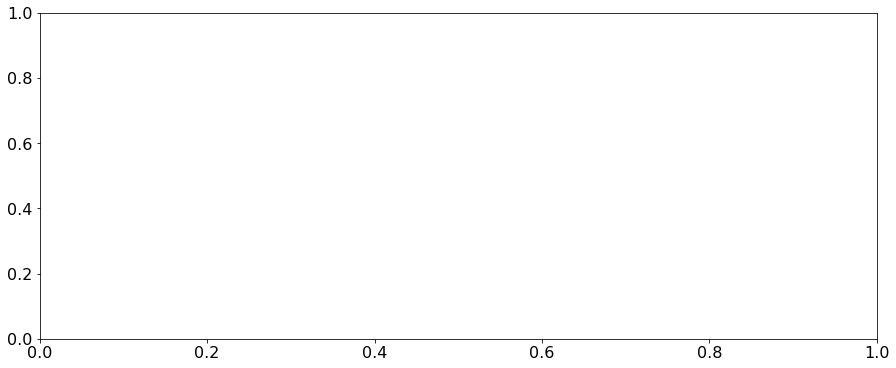

In [133]:
test_backsub("HZO11_Tamb_qz_2Theta.csv", tol=1)

### Trying with another function from another package XRDpy 
Exactly same method so also not good.
reference here = http://localhost:8888/edit/OneDrive/Python/GitHub/XRDpy/XRD_functions.py

In [134]:
def backsub(xdata,ydata,tol=1):
    'approx. # points for half width of peaks'
    L=len(ydata)
    lmda = int(0.50*L/(xdata[0]-xdata[L-1]))

    newdat=np.zeros(L)
    for i in range(L):
        if ydata[(i+lmda)%L] > tol*ydata[i]:          #tolerance 'tol'
            newdat[(i+lmda)%L] = ydata[(i+lmda)%L] - ydata[i]
        else:
            if ydata[(i+lmda)%L] < ydata[i]:
                newdat[(i+lmda)%L] = 0

    return newdat

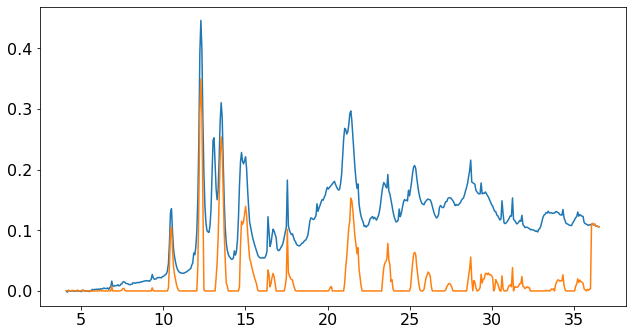

In [135]:
test_backsub = backsub(HZO11_Tamb_qz_2Theta[:, 0], HZO11_Tamb_qz_2Theta[:, 1])

plt.plot(HZO11_Tamb_qz_2Theta[:, 0], HZO11_Tamb_qz_2Theta[:, 1])
plt.plot(HZO11_Tamb_qz_2Theta[:, 0], test_backsub)

### Remove Background using Polynomial Function

In [136]:
from scipy import optimize

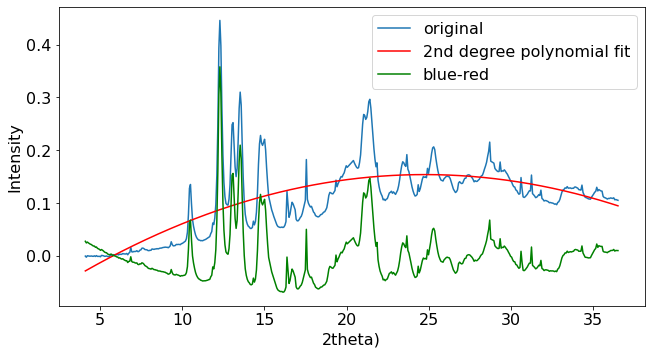

In [137]:
x = HZO11_Tamb_qz_2Theta[:, 0]
y = HZO11_Tamb_qz_2Theta[:, 1]


#Polynomial of second degree
def f(x, a, b, c):
	return a * x**2  + b * x + c

params, params_cov = optimize.curve_fit(f, x, y)

final = y-(f(x, params[0], params[1],params[2]))

plt.plot(x,y, label= ("original"))
plt.plot(x, f(x, params[0], params[1],params[2]) , c='r', label = ("2nd degree polynomial fit"))
plt.plot(x, final , c='g', label = ("blue-red"))
plt.xlabel("2theta)", fontsize=16)
plt.ylabel("Intensity", fontsize=16)
plt.legend()

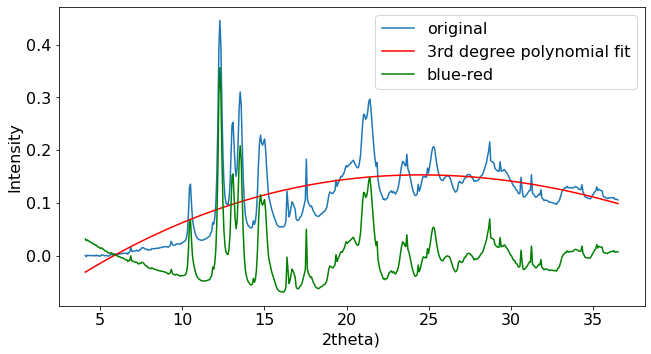

In [138]:
x = HZO11_Tamb_qz_2Theta[:, 0]
y = HZO11_Tamb_qz_2Theta[:, 1]


#Polynomial of third degree
def f(x, a, b, c, d):
	return a * x**3  + b * x**2 + c * x +d

params, params_cov = optimize.curve_fit(f, x, y)

final = y-(f(x, params[0], params[1],params[2], params[3]))

plt.plot(x,y, label= ("original"))
plt.plot(x, f(x, params[0], params[1],params[2], params[3]) , c='r', label = ("3rd degree polynomial fit"))
plt.plot(x, final , c='g', label = ("blue-red"))
plt.xlabel("2theta)", fontsize=16)
plt.ylabel("Intensity", fontsize=16)
plt.legend()

### Background removal using `scipy.signal.detrend`

In [139]:
from scipy import signal

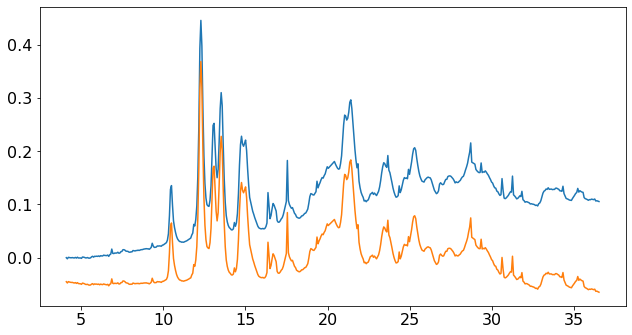

In [140]:
x = HZO11_Tamb_qz_2Theta[:, 0]
y = HZO11_Tamb_qz_2Theta[:, 1]

y_backsub= scipy.signal.detrend(y, axis=-1, type='linear', bp=0, overwrite_data=False)

plt.plot(x,y, label= "original")
plt.plot(x,y_backsub, label="detrend")

### [Best Method] Background removal using a combination of different methods
- `np.polyfit` + `scipy.signal.detrend` (basically a polynomial + a linear equation)

(409,)
-0.04685942109171339


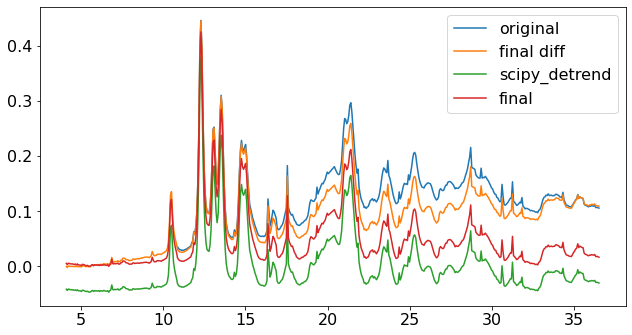

In [141]:
start = 110

x_beginning = HZO11_Tamb_qz_2Theta[:start, 0]
y_beginning = HZO11_Tamb_qz_2Theta[:start, 1]

x = HZO11_Tamb_qz_2Theta[start:, 0]
y = HZO11_Tamb_qz_2Theta[start:, 1]
print(y.shape)

z= np.polyfit(x, y, deg=4, rcond=None, full=False, w=None, cov=False)
p = np.poly1d(z)

diff = y-p(x)

plt.plot(x,y, label= "original")
# plt.plot(x,p(x), label="numpy.polyfit")
# plt.plot(x,diff, label="diff")

y_final_diff = np.concatenate((y_beginning, diff+y[0]*2+0.04),axis=0)
x_final_diff = np.concatenate((x_beginning, x),axis=0)
plt.plot(x_final_diff, y_final_diff, label="final diff")

# print(y_backsub)


y_scipy_detrend = scipy.signal.detrend(y_final_diff, axis=-1, type='linear', bp=0, overwrite_data=False)
plt.plot(x_final_diff, y_scipy_detrend, label='scipy_detrend')


# normalizing so the minimum is zero
y_min = np.min(y_scipy_detrend)
print(y_min)
y_final = y_scipy_detrend - y_min
plt.plot(x_final_diff, y_final, label='final')

plt.legend()

HZO11_XRD_final_Tamb_qz = np.concatenate((np.reshape(x_final_diff, (-1, 1)), np.reshape(y_final, (-1, 1))), axis=1)

#### Creating a function out of the removal background method

In [142]:
def background_removal(data, start=110, factor=0.04, deg=4):
    """ Removes background from XRD data using two sequential methods: a polynomial + a linear fit.
    data = numpy array with column 0 as x (2theta) and column 1 as y (Intensity)
    x = HZO11_Tamb_qz_2Theta
    y = HZO11_Tamb_qz_2Theta
    start = index to start the fitting (it will do the fit from the start index)
    factor = factor that helps to concatante the unffited and fitted y curves
    
    returns a numpy array with x and y removed background
    """
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 6))
    x_beginning = data[:start, 0]
    y_beginning = data[:start, 1]

    x_to_fit = data[start:, 0]
    y_to_fit = data[start:, 1]

    z = np.polyfit(x_to_fit, y_to_fit, deg, rcond=None, full=False, w=None, cov=False)
    p = np.poly1d(z)
    
#     print("shape p is: ", p(.shape)
#     print("shape y_to_fit is: ", y_to_fit.shape)

    diff = y_to_fit-p(x_to_fit)

    ax[0].plot(data[:, 0], data[:, 1], label= "original")
    ax[0].plot(x_to_fit, p(x_to_fit), label="numpy.polyfit")
    ax[0].plot(x_to_fit, diff, label="diff")

    y_final_diff = np.concatenate((y_beginning, diff+y_to_fit[0]*2+factor),axis=0)
    x_final_diff = np.concatenate((x_beginning, x_to_fit),axis=0)
    ax[1].plot(x_final_diff, y_final_diff, label="final diff")


    y_scipy_detrend = scipy.signal.detrend(y_final_diff, axis=-1, type='linear', bp=0, overwrite_data=False)
    ax[1].plot(x_final_diff, y_scipy_detrend, label='scipy_detrend')


    # normalizing so the minimum is zero
    y_min = np.min(y_scipy_detrend)
    print("the minimum of y_scipy_detrend to normalize is: ", y_min)
    y_final = y_scipy_detrend - y_min
    ax[1].plot(x_final_diff, y_final, label='final', c='red')

    ax[1].legend()
    ax[0].legend()
    
    XRD_final_backsub = np.concatenate((np.reshape(x_final_diff, (-1, 1)), np.reshape(y_final, (-1, 1))), axis=1)
    
    return XRD_final_backsub

the minimum of y_scipy_detrend to normalize is:  -0.04685942109171339


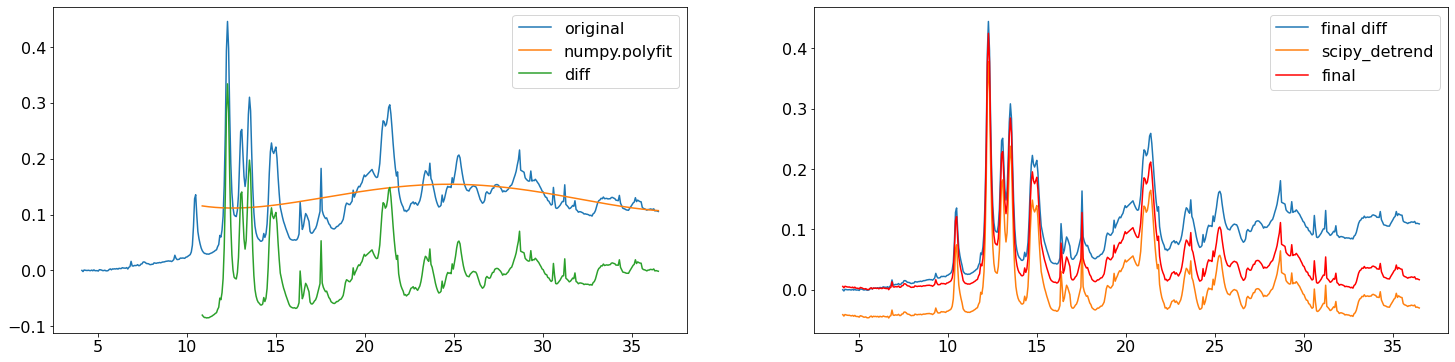

In [143]:
HZO11_XRD_final_Tamb_qz = background_removal(data = HZO11_Tamb_qz_2Theta, 
                                             start=110, 
                                             factor=0.04)

the minimum of y_scipy_detrend to normalize is:  -0.043296278633051584


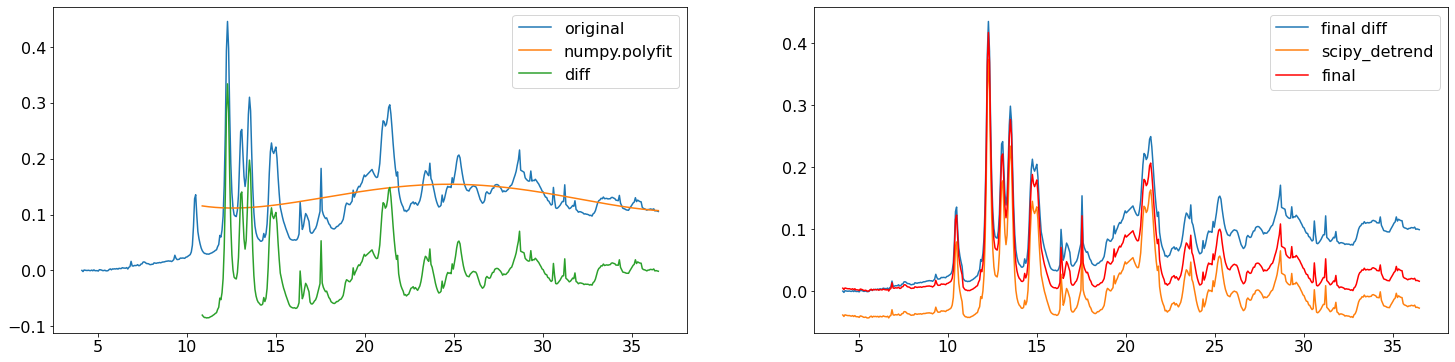

In [144]:
HZO11_XRD_final_Thaute_qz = background_removal(data = HZO11_Thaute_qz_2Theta, 
                   start=110, 
                   factor=0.03,
                   deg=4)

the minimum of y_scipy_detrend to normalize is:  -0.13387089124399265


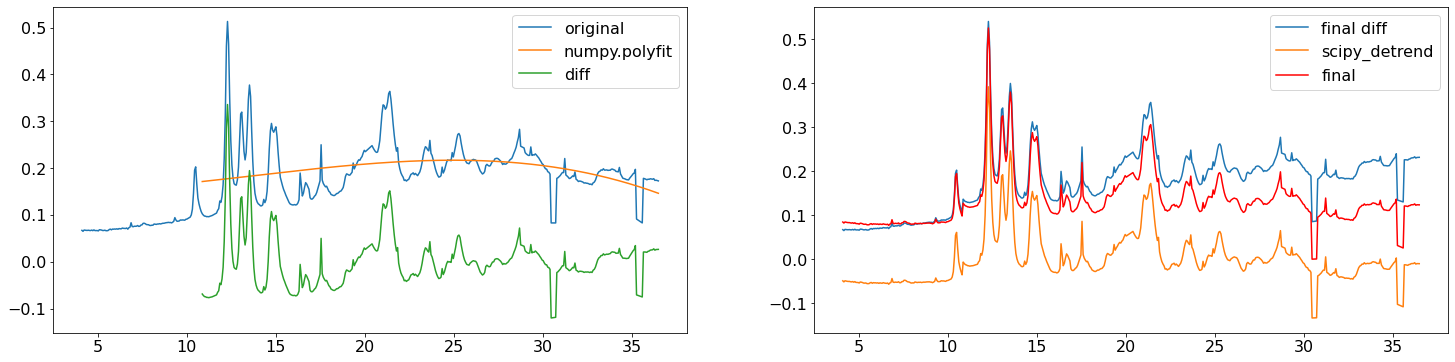

In [145]:
HZO11_XRD_final_Tamb_phi = background_removal(data = HZO11_Tamb_phi_2Theta, 
                                              start=110, 
                                              factor=0.0005,
                                              deg=3)

the minimum of y_scipy_detrend to normalize is:  -0.13381756245150211


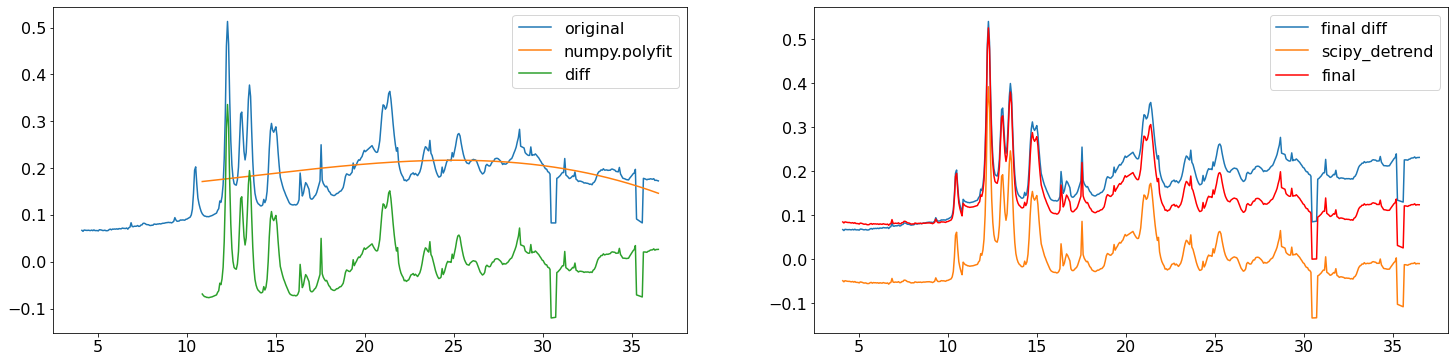

In [146]:
HZO11_XRD_final_Thaute_phi = background_removal(data = HZO11_Thaute_phi_2Theta, 
                                                start=110, 
                                                factor=0,
                                                deg=3)

In [147]:
# !mkdir HZO11_background_removal

A subdirectory or file HZO11_background_removal already exists.


In [151]:
dic_data = {"HZO11_XRD_final_Thaute_phi": HZO11_XRD_final_Thaute_phi, 
             "HZO11_XRD_final_Tamb_phi": HZO11_XRD_final_Tamb_phi, 
             "HZO11_XRD_final_Thaute_qz": HZO11_XRD_final_Thaute_qz, 
             "HZO11_XRD_final_Tamb_qz": HZO11_XRD_final_Tamb_qz}

for data in dic_data:
    np.savetxt("FINAL_Background_Removal/"+data+"_final.txt", dic_data[data])

In [152]:
!dir HZO11_background_removal\

 Volume in drive C is Windows
 Volume Serial Number is A8E0-A899

 Directory of C:\Users\rebce\OneDrive\Python\SXRD_Rebecca\HZO11_background_removal

23/03/2023  12:36    <DIR>          .
23/03/2023  12:36    <DIR>          ..
               0 File(s)              0 bytes
               2 Dir(s)   4,367,634,432 bytes free


In [153]:
HZO11_final = dic_data

## HZO 21 nm

- chosen files that are the most clean and complet:

`HZO21_Thaute_phi_-69_-59_q_resqz0p01.txt`

`HZO21_Tamb_phi_80_90_q.txt`

`HZO21_Tamb_qz_0p05_1p35_all_q.txt`

`HZO21_Thaute_qz_0p1_0p14_q_resqz0p01.txt`

### Plotting original integrations to choose the best ones

HZO21_Tamb_phi_-115_-99_q.txt
HZO21_Tamb_phi_-180_180_q.txt
HZO21_Tamb_phi_-86_-74_q.txt
HZO21_Tamb_phi_162_173_q.txt
HZO21_Tamb_phi_69_84_q.txt
HZO21_Tamb_phi_6_21_q.txt
HZO21_Tamb_phi_80_90_q.txt
HZO21_Tamb_qz_0p05_1p35_all_q.txt
HZO21_Tamb_qz_0p2_0p25_q.txt
HZO21_Tamb_qz_0p4_0p5_q.txt
HZO21_Tamb_qz_0p85_0p9_q.txt
HZO21_Thaute_phi_-169_-150_q_resqz0p01.txt
HZO21_Thaute_phi_-31_-11_q_resqz0p01.txt
HZO21_Thaute_phi_-69_-59_q_resqz0p01.txt
HZO21_Thaute_phi_14_24_q_resqz0p01.txt
HZO21_Thaute_qz_0p1_0p14_q_resqz0p01.txt


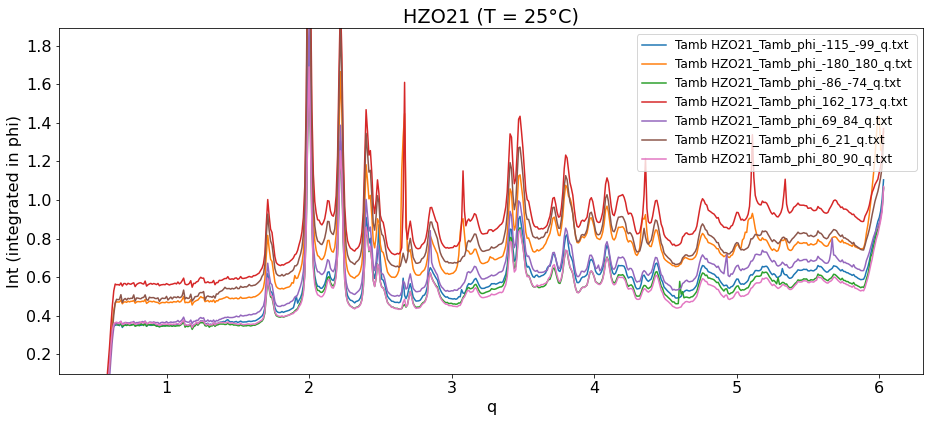

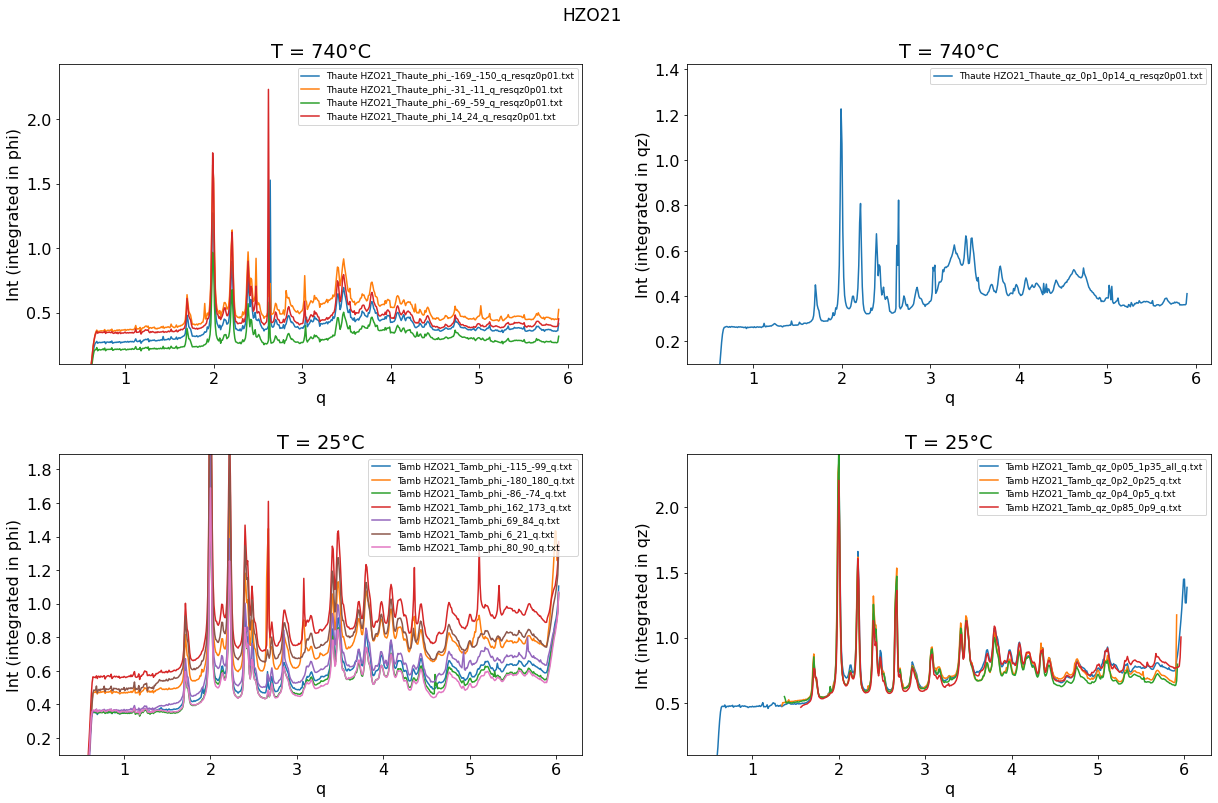

In [154]:
dic = plotting_integrations(name='HZO21', filepath='Compilation_Binoculars_SIXS_HZO/HZO21*.txt')

In [ ]:
dic

### Ploting the chosen XRDs ones

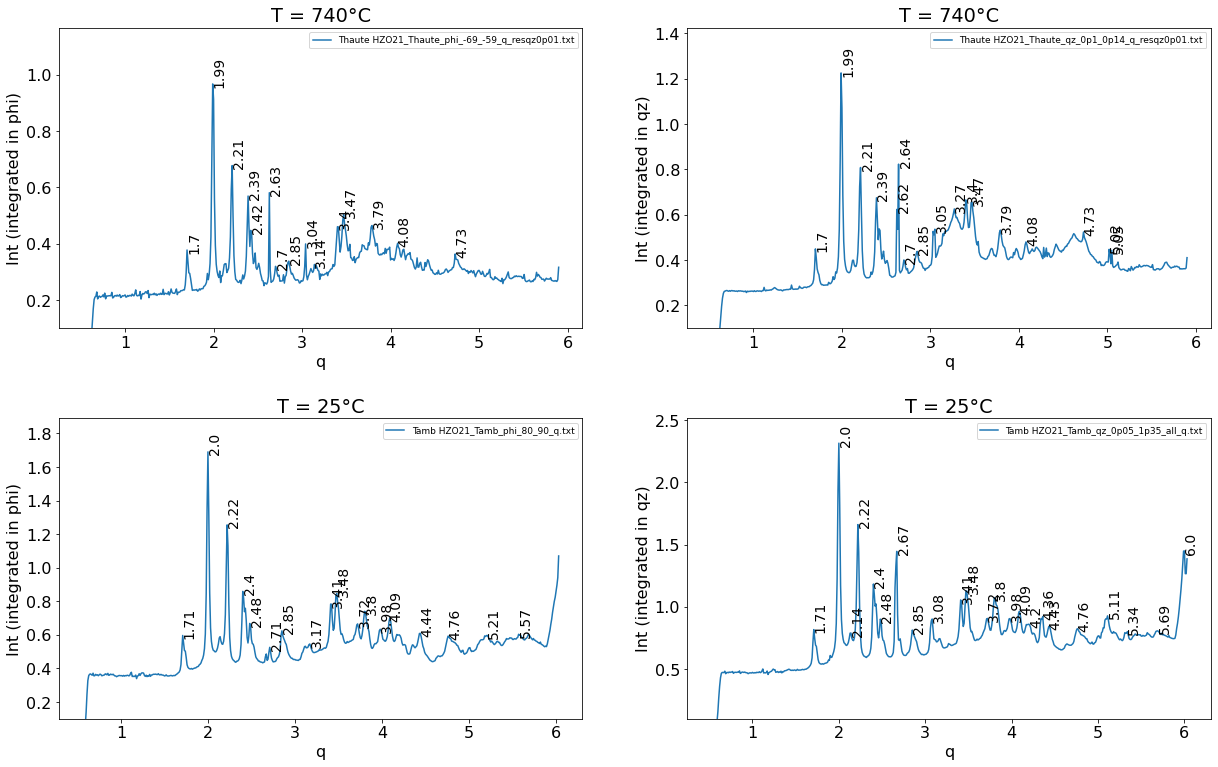

In [155]:
chosen_curves = ["HZO21_Thaute_phi_-69_-59_q_resqz0p01.txt",
                 "HZO21_Tamb_phi_80_90_q.txt",
                 "HZO21_Tamb_qz_0p05_1p35_all_q.txt",
                 "HZO21_Thaute_qz_0p1_0p14_q_resqz0p01.txt"]

plotting_chosen_curves(name="HZO21", dic=dic, chosen_curves=chosen_curves)

### Converting to 2Theta

In [156]:
for item in chosen_curves:
    sample_2Theta_x = q_to_2theta(dic[item][:,0])
    sample_2Theta_xy = np.concatenate((np.reshape(sample_2Theta_x, (-1, 1)), 
                                       np.reshape(dic[item][:,1], (-1, 1))), 
                                       axis=1)
    np.savetxt(f"{item[:-4]}_2Theta.txt", sample_2Theta_xy)

### Background and baseline removal

the minimum of y_scipy_detrend to normalize is:  -0.11158724631189598
the minimum of y_scipy_detrend to normalize is:  -0.1501590393594215
the minimum of y_scipy_detrend to normalize is:  -0.08392171924294944
the minimum of y_scipy_detrend to normalize is:  -0.07946418304675001


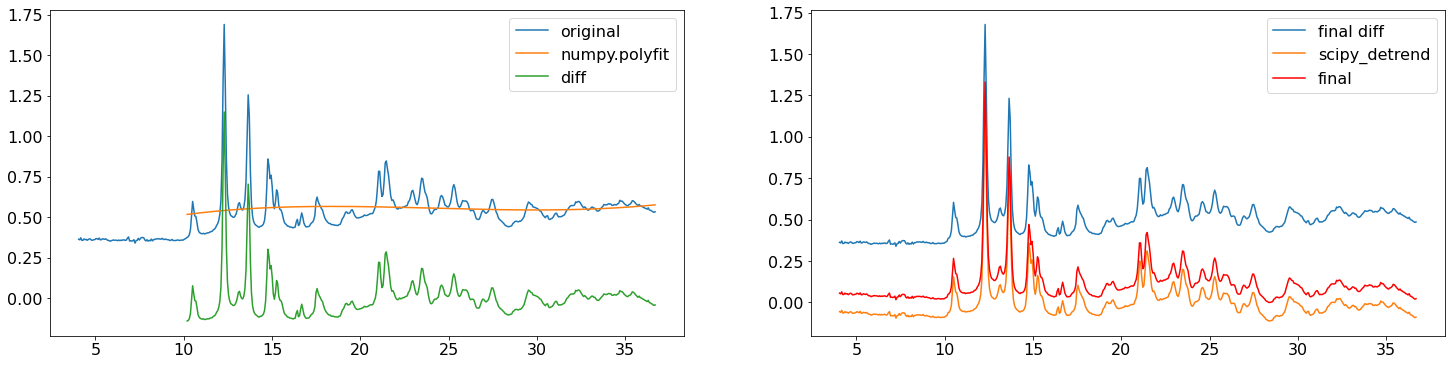

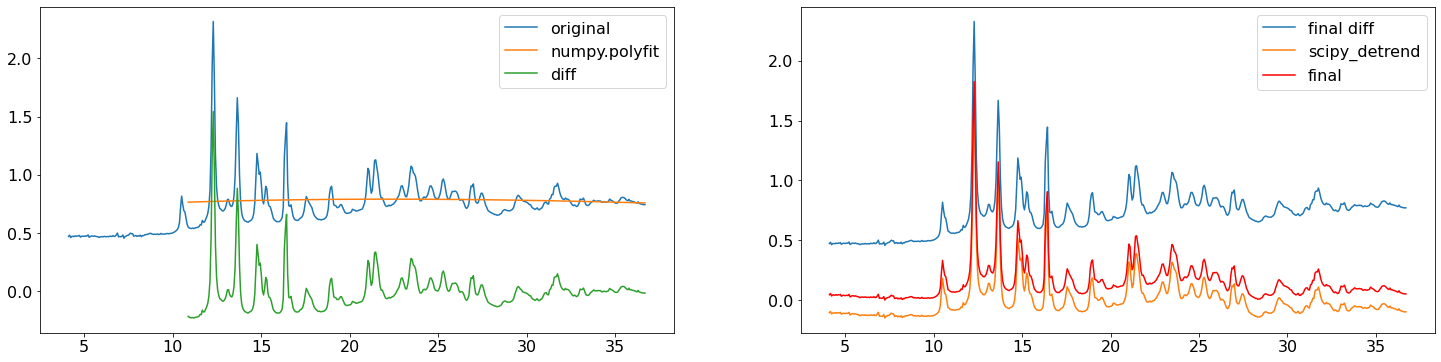

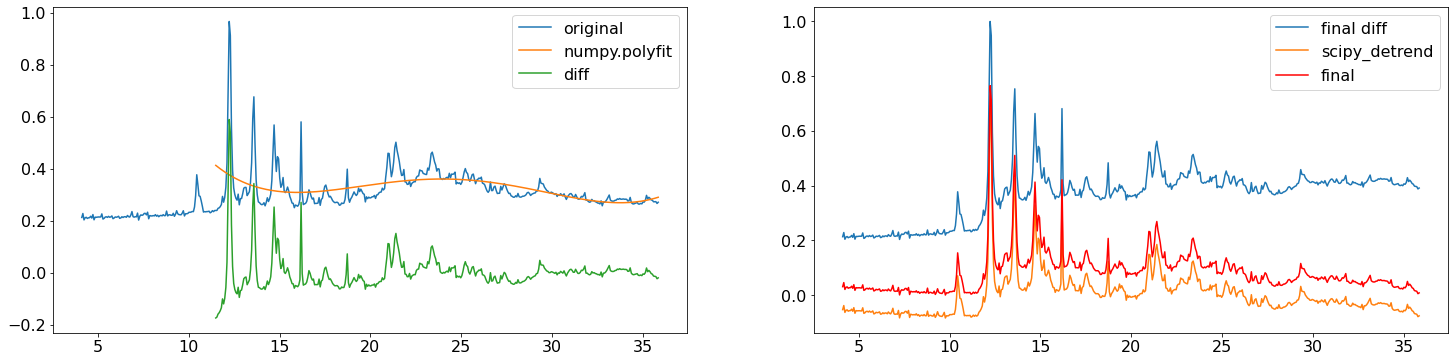

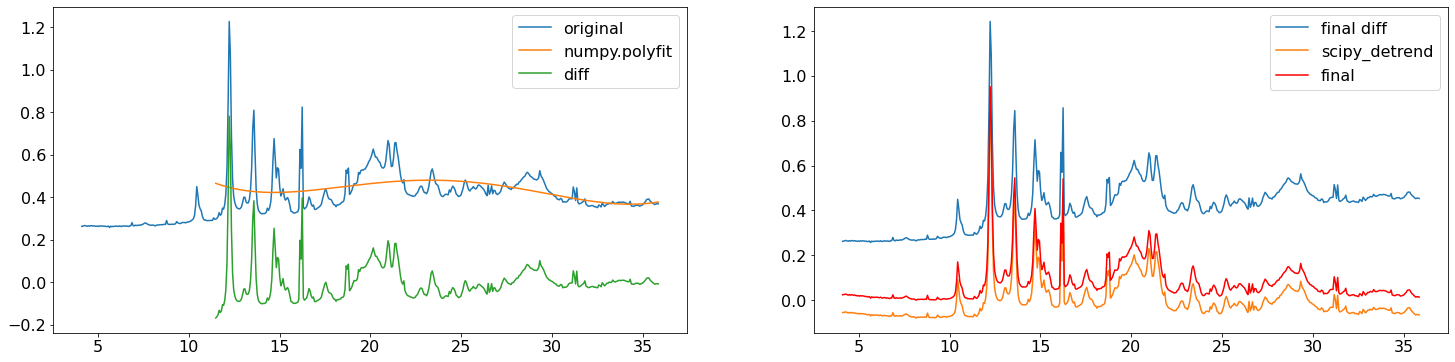

In [157]:
filenames = glob.glob("HZO21_*_2Theta.txt")

dic_final = {}
for file in filenames:
    sample = np.loadtxt(file,  delimiter=" ", dtype=float)
    if file == 'HZO21_Tamb_phi_80_90_q_2Theta.txt':
        beg = 10
        end = -15
        start = 100
        factor = -0.22
        deg = 3
    elif file == 'HZO21_Tamb_qz_0p05_1p35_all_q_2Theta.txt':
        beg = 15
        end = -15
        start = 110
        factor = -0.32
        deg = 3    
    elif file == 'HZO21_Thaute_phi_-69_-59_q_resqz0p01_2Theta.txt':
        beg = 15
        end = -15
        start = 120
        factor = -0.07
        deg = 4
    else: # file == 'HZO21_Thaute_qz_0p1_0p14_q_resqz0p01_2Theta.txt':
        beg = 15
        end = -15
        start = 120
        factor = -0.13
        deg = 4    
        
    dic_final[file] = background_removal(data = sample[beg:end], 
                       start=start, 
                       factor=factor,
                       deg=deg)

### Saving the final treated data into .txt

In [159]:
for key in dic_final:
    np.savetxt(f"FINAL_Background_Removal/{key[:-4]}_final.txt", dic_final[key])

In [160]:
HZO21_final = dic_final

## HZO 52 nm

HZO52_Tamb_phi_-13_-4_q.txt
HZO52_Tamb_phi_-160_-139_q.txt
HZO52_Tamb_phi_-180_180_q.txt
HZO52_Tamb_phi_-76_-64_q.txt
HZO52_Tamb_phi_105_118_q.txt
HZO52_Tamb_phi_12_26_q.txt
HZO52_Tamb_phi_62_76_q.txt
HZO52_Tamb_qz_0p11_0p2_all_q_res0p01.txt
HZO52_Tamb_qz_0p1_0p2_all_q.txt
HZO52_Thaute_phi_-166_-144_q_resqz0p01.txt
HZO52_Thaute_phi_-81_-59_q_resqz0p01.txt
HZO52_Thaute_phi_103_127_q_resqz0p01.txt
HZO52_Thaute_phi_138_162_q_resqz0p01.txt
HZO52_Thaute_phi_16_37_q_resqz0p01.txt
HZO52_Thaute_phi_57_79_q_resqz0p01.txt
HZO52_Thaute_qz_0p1_0p15_q_resqz0p01.txt


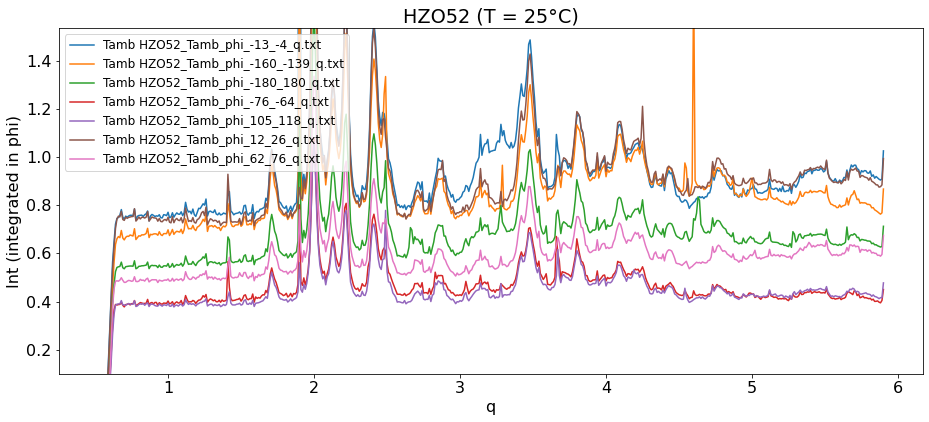

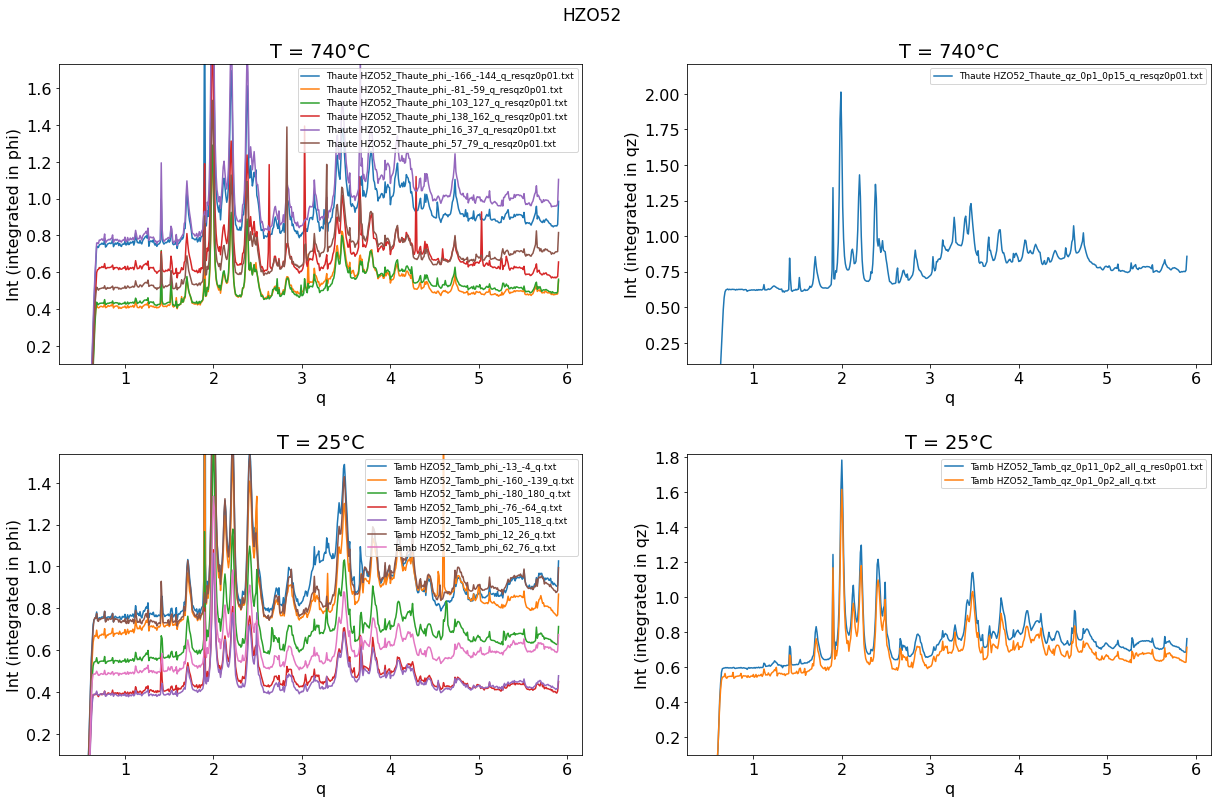

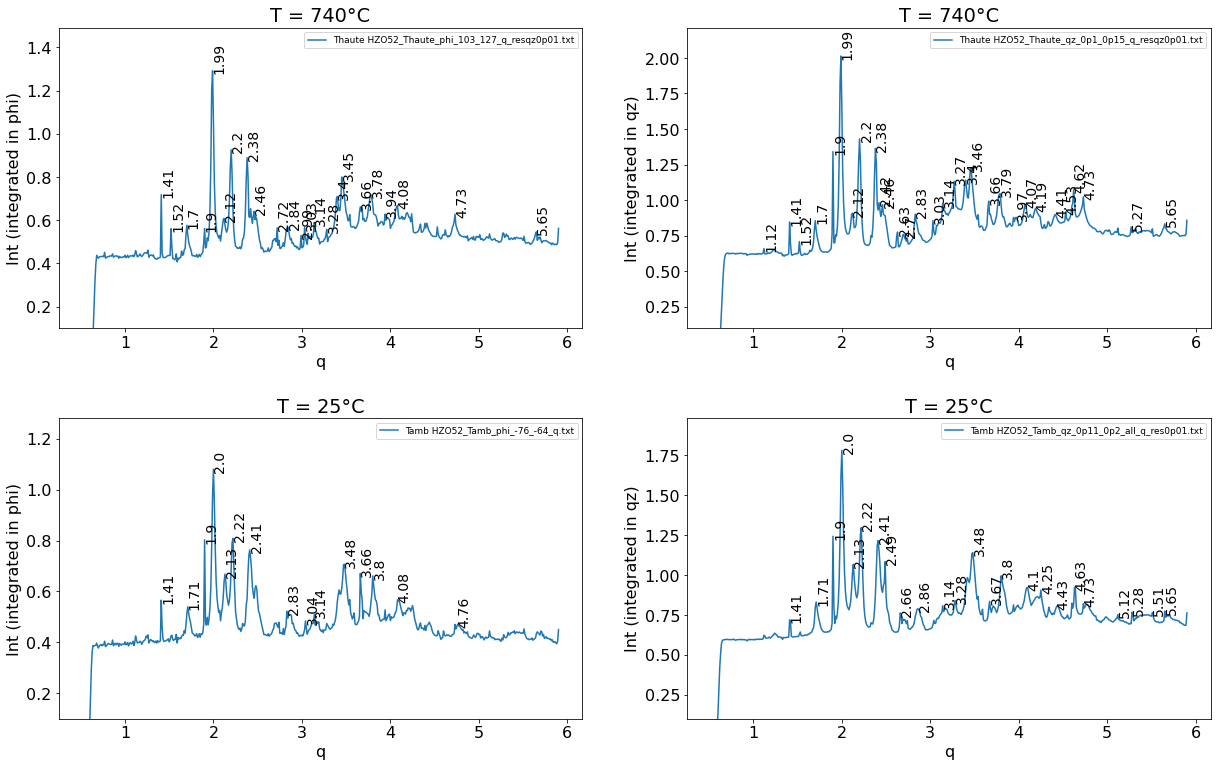

In [173]:
dic = plotting_integrations(name='HZO52', filepath='Compilation_Binoculars_SIXS_HZO/HZO52*.txt')

chosen_curves = ["HZO52_Tamb_phi_-76_-64_q.txt",
                 "HZO52_Thaute_phi_103_127_q_resqz0p01.txt",
                 "HZO52_Tamb_qz_0p11_0p2_all_q_res0p01.txt",
                 "HZO52_Thaute_qz_0p1_0p15_q_resqz0p01.txt"]

plotting_chosen_curves(name="HZO52", dic=dic, chosen_curves=chosen_curves)

In [174]:
chosen_curves = ["HZO52_Tamb_phi_-76_-64_q.txt",
                 "HZO52_Thaute_phi_103_127_q_resqz0p01.txt",
                 "HZO52_Tamb_qz_0p11_0p2_all_q_res0p01.txt",
                 "HZO52_Thaute_qz_0p1_0p15_q_resqz0p01.txt"]

for item in chosen_curves:
    sample_2Theta_x = q_to_2theta(dic[item][:,0])
    sample_2Theta_xy = np.concatenate((np.reshape(sample_2Theta_x, (-1, 1)), 
                                       np.reshape(dic[item][:,1], (-1, 1))), 
                                       axis=1)
    np.savetxt(f"{item[:-4]}_2Theta.txt", sample_2Theta_xy)

['HZO52_Tamb_phi_-76_-64_q_2Theta.txt', 'HZO52_Tamb_qz_0p11_0p2_all_q_res0p01_2Theta.txt', 'HZO52_Thaute_phi_103_127_q_resqz0p01_2Theta.txt', 'HZO52_Thaute_qz_0p1_0p15_q_resqz0p01_2Theta.txt']
the minimum of y_scipy_detrend to normalize is:  -0.09544714151927791
the minimum of y_scipy_detrend to normalize is:  -0.12007226812401406
the minimum of y_scipy_detrend to normalize is:  -0.09767187878479178
the minimum of y_scipy_detrend to normalize is:  -0.1345672398391674


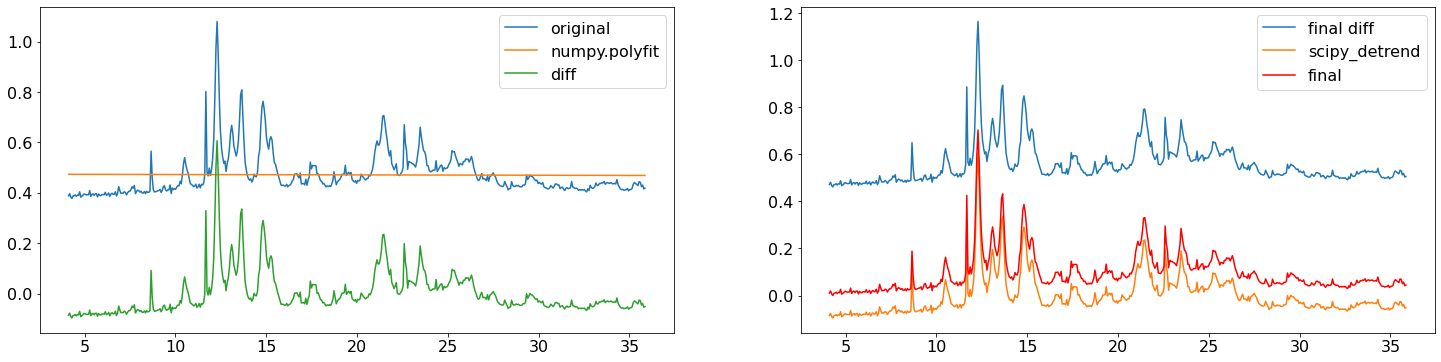

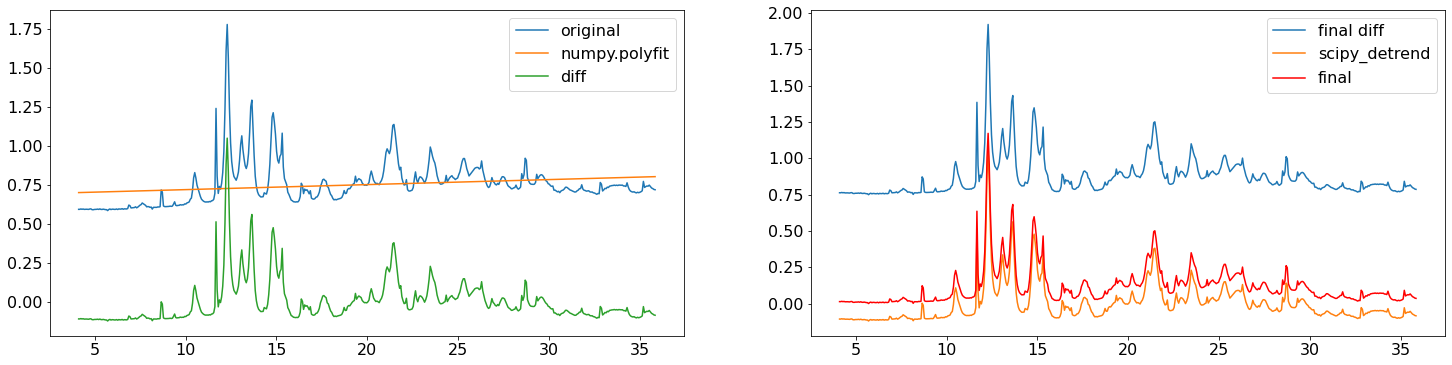

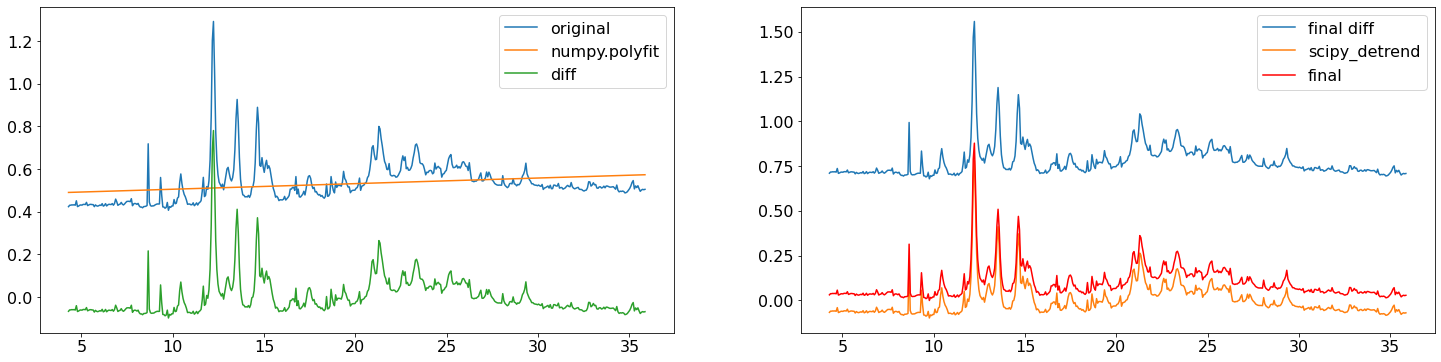

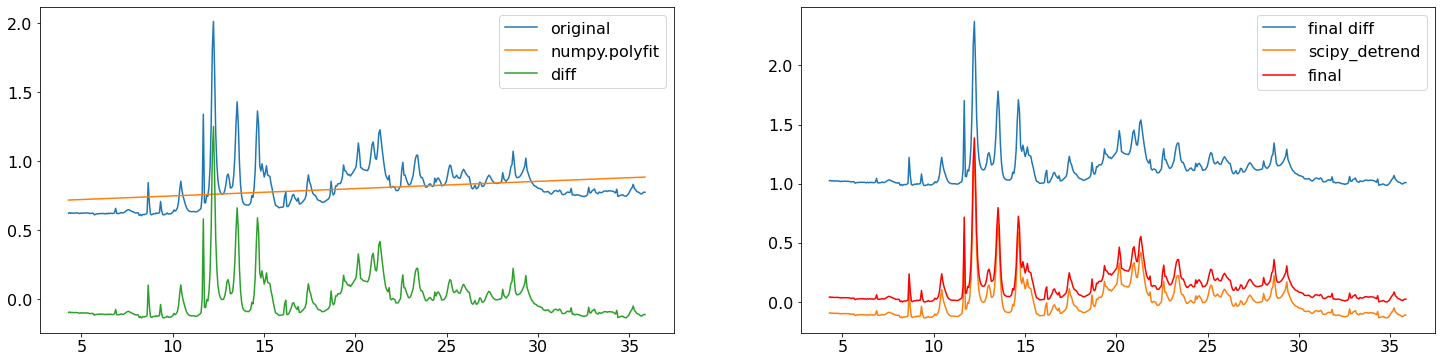

In [175]:
filenames = glob.glob("HZO52_*_2Theta.txt")
print(filenames)
dic_final = {}
for file in filenames:
    sample = np.loadtxt(file,  delimiter=" ", dtype=float)
    if file == 'HZO52_Tamb_phi_-76_-64_q_2Theta.txt':
        beg = 15
        end = -15
        start = 0
        factor = -0.22
        deg = 1
    elif file == 'HZO52_Tamb_qz_0p11_0p2_all_q_res0p01_2Theta.txt':
        beg = 15
        end = -15
        start = 0
        factor = -0.32
        deg = 1    
    elif file == 'HZO52_Thaute_phi_103_127_q_resqz0p01_2Theta.txt':
        beg = 18
        end = -15
        start = 0
        factor = -0.07
        deg = 1
    else: # file == 'HZO52_Thaute_qz_0p1_0p15_q_resqz0p01_2Theta.txt':
        beg = 18
        end = -15
        start = 0
        factor = -0.13
        deg = 1    
        
    dic_final[file] = background_removal(data = sample[beg:end], 
                       start=start, 
                       factor=factor,
                       deg=deg)

In [176]:
for key in dic_final:
    np.savetxt(f"FINAL_Background_Removal/{key[:-4]}_final.txt", dic_final[key])

In [177]:
HZO52_final = dic_final 

In [178]:
HZO11_final

{'HZO11_XRD_final_Thaute_phi': array([[ 4.11061698,  0.08460854],
        [ 4.1719964 ,  0.0822841 ],
        [ 4.23337702,  0.08475165],
        ...,
        [36.36842944,  0.1238922 ],
        [36.43299987,  0.12372627],
        [36.49758228,  0.12369319]]),
 'HZO11_XRD_final_Tamb_phi': array([[ 4.11061698,  0.0845179 ],
        [ 4.1719964 ,  0.08219249],
        [ 4.23337702,  0.08465908],
        ...,
        [36.36842944,  0.12380337],
        [36.43299987,  0.12363648],
        [36.49758228,  0.12360243]]),
 'HZO11_XRD_final_Thaute_qz': array([[4.11061698e+00, 4.77482318e-03],
        [4.17199640e+00, 2.52204826e-03],
        [4.23337702e+00, 5.06127334e-03],
        ...,
        [3.63684294e+01, 1.74320787e-02],
        [3.64329999e+01, 1.66048653e-02],
        [3.64975823e+01, 1.58961393e-02]]),
 'HZO11_XRD_final_Tamb_qz': array([[4.11061698e+00, 5.45853774e-03],
        [4.17199640e+00, 3.18645351e-03],
        [4.23337702e+00, 5.70636928e-03],
        ...,
        [3.6368429

## Checking the final data

HZO52_Tamb_phi_-76_-64_q_2Theta.txt
HZO52_Tamb_qz_0p11_0p2_all_q_res0p01_2Theta.txt
HZO52_Thaute_phi_103_127_q_resqz0p01_2Theta.txt
HZO52_Thaute_qz_0p1_0p15_q_resqz0p01_2Theta.txt
HZO21_Tamb_phi_80_90_q_2Theta.txt
HZO21_Tamb_qz_0p05_1p35_all_q_2Theta.txt
HZO21_Thaute_phi_-69_-59_q_resqz0p01_2Theta.txt
HZO21_Thaute_qz_0p1_0p14_q_resqz0p01_2Theta.txt
HZO11_XRD_final_Thaute_phi
HZO11_XRD_final_Tamb_phi
HZO11_XRD_final_Thaute_qz
HZO11_XRD_final_Tamb_qz


Text(0.45, 0.95, 'HZO')

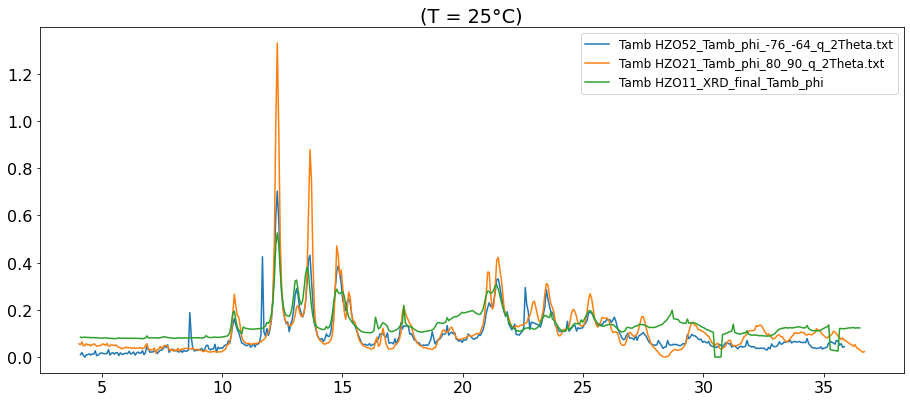

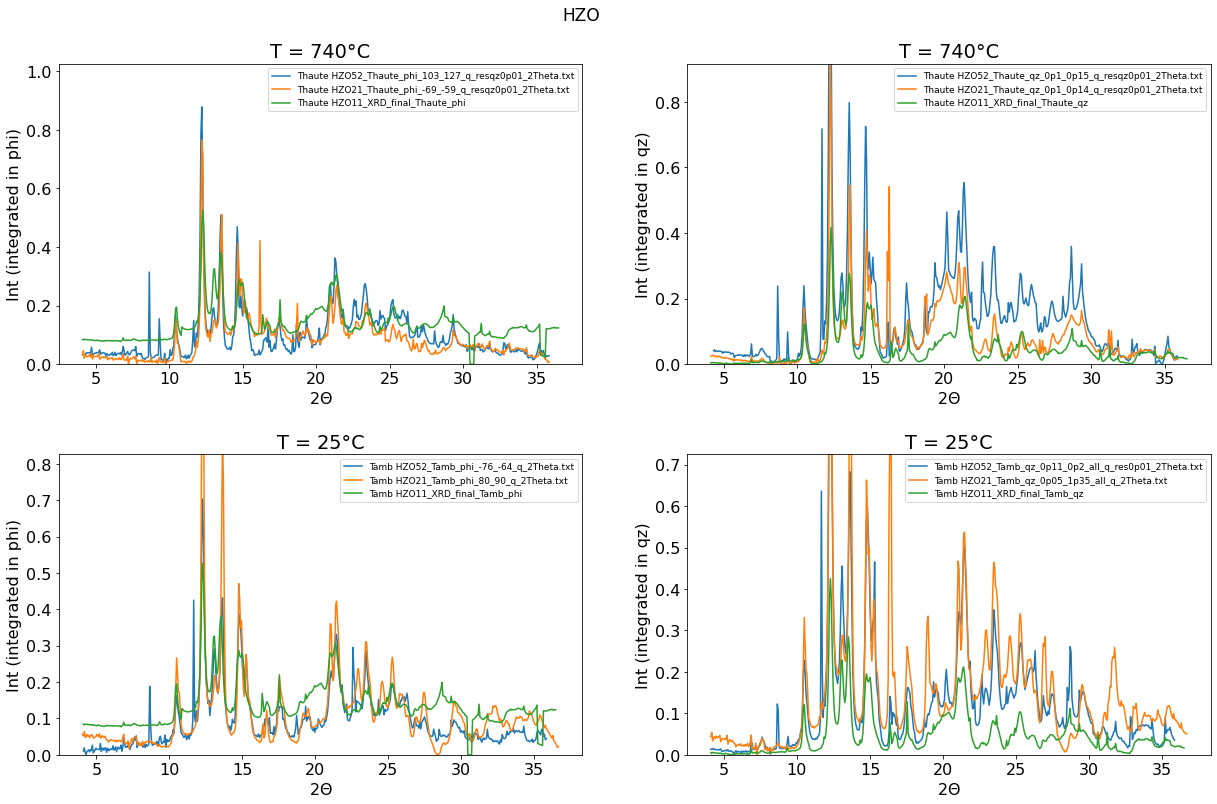

In [179]:
final_data = dict(HZO52_final, **HZO21_final, **HZO11_final)
final_data

# Plotting all together
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))

for key in final_data.keys():
    Tamb = [t for t in key.split(sep="_") if t.startswith('Tamb')]
    print(key)
    if "Tamb" in Tamb:
        label = "Tamb "+key
        phi = [t for t in key.split(sep="_") if t.startswith('p')]
        if "phi" in phi: 
            # plot the phi vs q of Tamb
            idx = 0
            ylabel = "Int (integrated in phi)"
        else:
            continue

        ax.plot(final_data[key][:,0], final_data[key][:,1], label=label)
        ax.set_title("(T = 25°C)")
#         ax.set(xlabel="2$\Theta$", ylabel=ylabel, ylim=[0.1, max(final_data[key][:,1])+0.2])
        ax.legend(fontsize=12)

#         put_freq(x=final_data[key][:,0], Int=final_data[key][:,1], axis=ax, shift_Int=0, shift_x=0, rotation=90, width=0.05)


    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,12))

for key in final_data.keys():
    Thaute = [t for t in key.split(sep="_") if t.startswith('Thaute')]
    if "Thaute" in Thaute:
        label = "Thaute "+key
        phi = [t for t in key.split(sep="_") if t.startswith('p')]
        if "phi" in phi: 
            # plot the phi vs q of Tamb
            idx = 0
            ylabel = "Int (integrated in phi)"
        else:
            # plot the qz vs q of Tamb
            idx = 1
            ylabel = "Int (integrated in qz)"

        ax[0, idx].set_title("T = 740°C")
        ax[0, idx].plot(final_data[key][:,0], final_data[key][:,1], label=label)
        ax[0, idx].set(xlabel="2$\Theta$", ylabel=ylabel, ylim=[0, max(final_data[key][:,1])+0.5])
        ax[0, idx].legend(fontsize=9)

#             put_freq(x=final_data[key][:,0], Int=final_data[key][:,1], axis=ax[0, idx], shift_Int=0, shift_x=0, rotation=90, width=0.05)

    else:
        label = "Tamb "+key
        phi = [t for t in key.split(sep="_") if t.startswith('p')]
        if "phi" in phi: 
            # plot the phi vs q of Thaute
            idx = 0
            ylabel = "Int (integrated in phi)"
        else:
            # plot the qz vs q of Thaute
            idx = 1
            ylabel = "Int (integrated in qz)"

        ax[1, idx].set_title("T = 25°C")
        ax[1, idx].plot(final_data[key][:,0], final_data[key][:,1], label=label)
        ax[1, idx].set(xlabel="2$\Theta$", ylabel=ylabel, ylim=[0, max(final_data[key][:,1])+0.3])
        ax[1, idx].legend(fontsize=9)

#             put_freq(x=final_data[key][:,0], Int=final_data[key][:,1], axis=ax[1, idx], shift_Int=0, shift_x=0, rotation=90, width=0.05)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3)

fig.text(0.45, 0.95, "HZO", fontsize = 17)

### Reloading the data to double check if it is well saved

FINAL_Background_Removal/files_long_names\HZO11_XRD_final_Tamb_phi_final.txt
FINAL_Background_Removal/files_long_names\HZO11_XRD_final_Tamb_qz_final.txt
FINAL_Background_Removal/files_long_names\HZO11_XRD_final_Thaute_phi_final.txt
FINAL_Background_Removal/files_long_names\HZO11_XRD_final_Thaute_qz_final.txt
FINAL_Background_Removal/files_long_names\HZO21_Tamb_phi_80_90_q_2Theta_final.txt
FINAL_Background_Removal/files_long_names\HZO21_Tamb_qz_0p05_1p35_all_q_2Theta_final.txt
FINAL_Background_Removal/files_long_names\HZO21_Thaute_phi_-69_-59_q_resqz0p01_2Theta_final.txt
FINAL_Background_Removal/files_long_names\HZO21_Thaute_qz_0p1_0p14_q_resqz0p01_2Theta_final.txt
FINAL_Background_Removal/files_long_names\HZO52_Tamb_phi_-76_-64_q_2Theta_final.txt
FINAL_Background_Removal/files_long_names\HZO52_Tamb_qz_0p11_0p2_all_q_res0p01_2Theta_final.txt
FINAL_Background_Removal/files_long_names\HZO52_Thaute_phi_103_127_q_resqz0p01_2Theta_final.txt
FINAL_Background_Removal/files_long_names\HZO52_Tha

Text(0.45, 0.95, 'HZO')

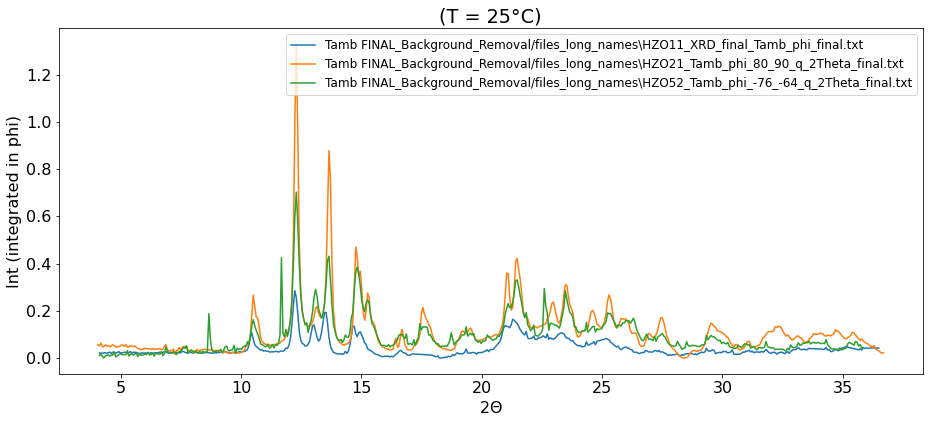

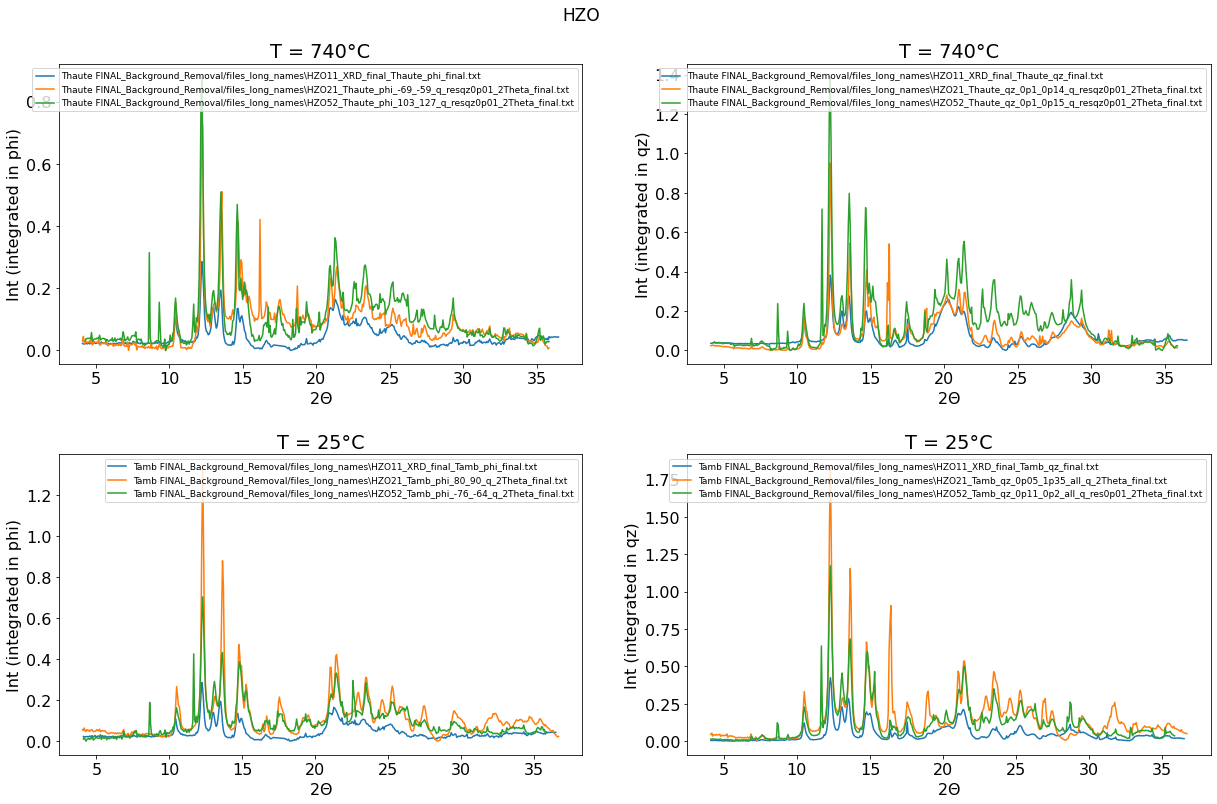

In [180]:
reloaded_dic = {}

filenames = glob.glob("FINAL_Background_Removal/files_long_names/*_final.txt")
filenames

for file in filenames:
    sample = np.loadtxt(file, delimiter=" ", dtype=float)
    reloaded_dic[file] = sample


# Plotting all together
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))

for key in reloaded_dic.keys():
    Tamb = [t for t in key.split(sep="_") if t.startswith('Tamb')]
    print(key)
    if "Tamb" in Tamb:
        label = "Tamb "+key
        phi = [t for t in key.split(sep="_") if t.startswith('p')]
        if "phi" in phi: 
            # plot the phi vs q of Tamb
            idx = 0
            ylabel = "Int (integrated in phi)"
        else:
            continue

        ax.plot(reloaded_dic[key][:,0], reloaded_dic[key][:,1], label=label)
        ax.set_title("(T = 25°C)")
        ax.set(xlabel="2$\Theta$", ylabel=ylabel) #, ylim=[0.1, max(reloaded_dic[key][:,1])+0.2])
        ax.legend(fontsize=12)

#         put_freq(x=reloaded_dic[key][:,0], Int=reloaded_dic[key][:,1], axis=ax, shift_Int=0, shift_x=0, rotation=90, width=0.05)


    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,12))

for key in reloaded_dic.keys():
    Thaute = [t for t in key.split(sep="_") if t.startswith('Thaute')]
    if "Thaute" in Thaute:
        label = "Thaute "+key
        phi = [t for t in key.split(sep="_") if t.startswith('p')]
        if "phi" in phi: 
            # plot the phi vs q of Tamb
            idx = 0
            ylabel = "Int (integrated in phi)"
        else:
            # plot the qz vs q of Tamb
            idx = 1
            ylabel = "Int (integrated in qz)"

        ax[0, idx].set_title("T = 740°C")
        ax[0, idx].plot(reloaded_dic[key][:,0], reloaded_dic[key][:,1], label=label)
        ax[0, idx].set(xlabel="2$\Theta$", ylabel=ylabel) #, ylim=[0.1, max(reloaded_dic[key][:,1])+0.2])
        ax[0, idx].legend(fontsize=9)

#             put_freq(x=reloaded_dic[key][:,0], Int=reloaded_dic[key][:,1], axis=ax[0, idx], shift_Int=0, shift_x=0, rotation=90, width=0.05)

    else:
        label = "Tamb "+key
        phi = [t for t in key.split(sep="_") if t.startswith('p')]
        if "phi" in phi: 
            # plot the phi vs q of Thaute
            idx = 0
            ylabel = "Int (integrated in phi)"
        else:
            # plot the qz vs q of Thaute
            idx = 1
            ylabel = "Int (integrated in qz)"

        ax[1, idx].set_title("T = 25°C")
        ax[1, idx].plot(reloaded_dic[key][:,0], reloaded_dic[key][:,1], label=label)
        ax[1, idx].set(xlabel="2$\Theta$", ylabel=ylabel) #, ylim=[0.1, max(reloaded_dic[key][:,1])+0.2])
        ax[1, idx].legend(fontsize=9)

#             put_freq(x=reloaded_dic[key][:,0], Int=reloaded_dic[key][:,1], axis=ax[1, idx], shift_Int=0, shift_x=0, rotation=90, width=0.05)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3)

fig.text(0.45, 0.95, "HZO", fontsize = 17)    

## Renaming the data so it is more user friendly

In [181]:
import os

In [182]:
filenames_ZrO2 = glob.glob('FINAL_Background_Removal/*_final.txt')

for file in filenames:
    new = [t for t in file.split(sep="\\") if t.startswith('HZO')]
    Tamb = [t for t in new[0].split(sep="_") if t.startswith('Tamb')]
    phi = [t for t in new[0].split(sep="_") if t.startswith('p')]
    print(new[0])
    if "Tamb" in Tamb:
        print("Tamb")
        if "phi" in phi:
            print("phi")
            os.rename(file, f"FINAL_Background_Removal/{new[0][0:5]}_Tamb_phi.txt")
        else:
            print("qz")
            os.rename(file, f"FINAL_Background_Removal/{new[0][0:5]}_Tamb_qz.txt")
    else:
        print("Thaute")
        if "phi" in phi:
            print("phi")
            os.rename(file, f"FINAL_Background_Removal/{new[0][0:5]}_Thaute_phi.txt")
        else:
            print("qz")
            os.rename(file, f"FINAL_Background_Removal/{new[0][0:5]}_Thaute_qz.txt")

# filenames_txt = glob.glob('*.txt')

HZO11_XRD_final_Tamb_phi_final.txt
Tamb
phi


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'FINAL_Background_Removal/files_long_names\\HZO11_XRD_final_Tamb_phi_final.txt' -> 'FINAL_Background_Removal/HZO11_Tamb_phi.txt'

#### Checking if data is still ok !

In [183]:
key = "FINAL_Background_Removal\HZO11_Tamb_phi.txt"
phi = [t for t in key.split(sep="_") if t.startswith('p')]
phi

['phi.txt']

FINAL_Background_Removal\HZO11_Tamb_phi.txt
['Tamb']
phi
FINAL_Background_Removal\HZO11_Tamb_qz.txt
['Tamb']
FINAL_Background_Removal\HZO11_Thaute_phi.txt
[]
FINAL_Background_Removal\HZO11_Thaute_qz.txt
[]
FINAL_Background_Removal\HZO11_XRD_final_Tamb_phi_final.txt
['Tamb']
FINAL_Background_Removal\HZO11_XRD_final_Tamb_qz_final.txt
['Tamb']
FINAL_Background_Removal\HZO11_XRD_final_Thaute_phi_final.txt
[]
FINAL_Background_Removal\HZO11_XRD_final_Thaute_qz_final.txt
[]
FINAL_Background_Removal\HZO21_Tamb_phi.txt
['Tamb']
phi
FINAL_Background_Removal\HZO21_Tamb_phi_80_90_q_2Theta_final.txt
['Tamb']
FINAL_Background_Removal\HZO21_Tamb_qz.txt
['Tamb']
FINAL_Background_Removal\HZO21_Tamb_qz_0p05_1p35_all_q_2Theta_final.txt
['Tamb']
FINAL_Background_Removal\HZO21_Thaute_phi.txt
[]
FINAL_Background_Removal\HZO21_Thaute_phi_-69_-59_q_resqz0p01_2Theta_final.txt
[]
FINAL_Background_Removal\HZO21_Thaute_qz.txt
[]
FINAL_Background_Removal\HZO21_Thaute_qz_0p1_0p14_q_resqz0p01_2Theta_final.txt
[]
FIN

Text(0.45, 0.95, 'HZO')

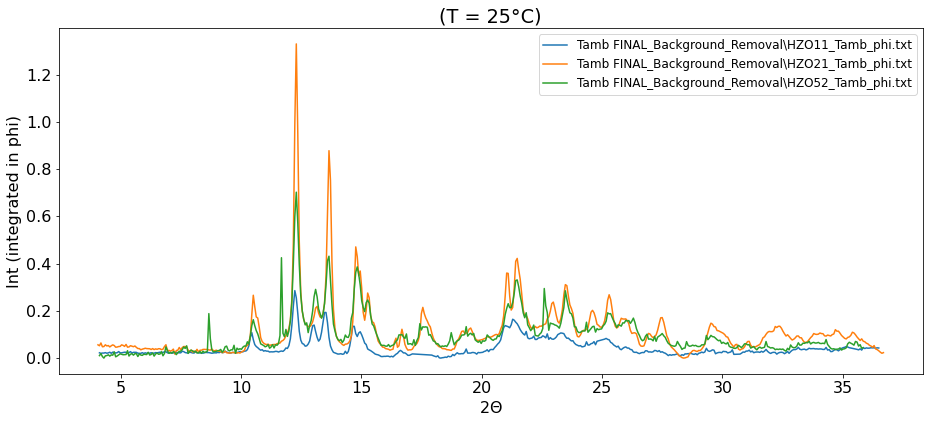

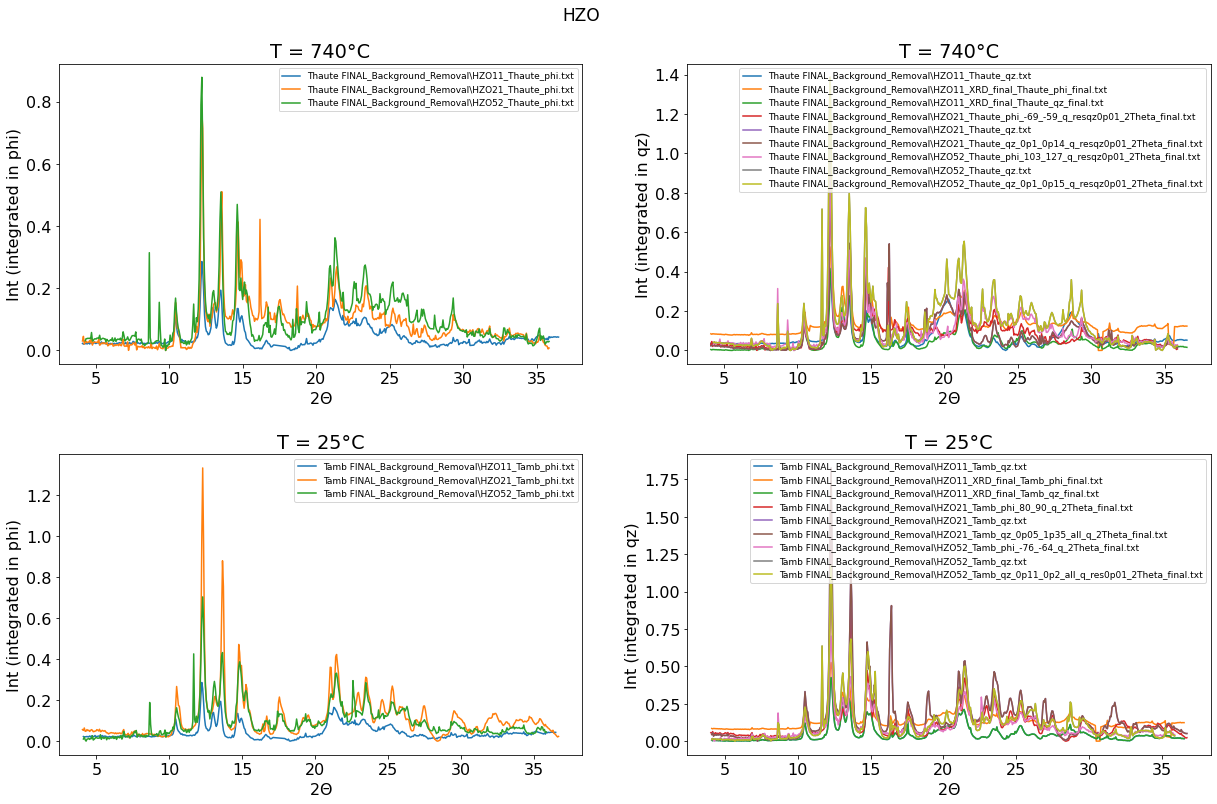

In [184]:
reloaded_dic = {}

filenames = glob.glob("FINAL_Background_Removal/*.txt")
filenames

for file in filenames:
    sample = np.loadtxt(file, delimiter=" ", dtype=float)
    reloaded_dic[file] = sample


# Plotting all together
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))

for key in reloaded_dic.keys():
    Tamb = [t for t in key.split(sep="_") if t.startswith('Tamb')]
    print(key)
    print(Tamb)
    if "Tamb" in Tamb:
        label = "Tamb "+key
        phi = [t for t in key.split(sep="_") if t.startswith('p')]
        if "phi.txt" in phi:
            print("phi")
            # plot the phi vs q of Tamb
            idx = 0
            ylabel = "Int (integrated in phi)"
        else:
            continue

        ax.plot(reloaded_dic[key][:,0], reloaded_dic[key][:,1], label=label)
        ax.set_title("(T = 25°C)")
        ax.set(xlabel="2$\Theta$", ylabel=ylabel) #, ylim=[0.1, max(reloaded_dic[key][:,1])+0.2])
        ax.legend(fontsize=12)

#         put_freq(x=reloaded_dic[key][:,0], Int=reloaded_dic[key][:,1], axis=ax, shift_Int=0, shift_x=0, rotation=90, width=0.05)


    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,12))

for key in reloaded_dic.keys():
    Thaute = [t for t in key.split(sep="_") if t.startswith('Thaute')]
    if "Thaute" in Thaute:
        label = "Thaute "+key
        phi = [t for t in key.split(sep="_") if t.startswith('p')]
        if "phi.txt" in phi: 
            # plot the phi vs q of Tamb
            idx = 0
            ylabel = "Int (integrated in phi)"
        else:
            # plot the qz vs q of Tamb
            idx = 1
            ylabel = "Int (integrated in qz)"

        ax[0, idx].set_title("T = 740°C")
        ax[0, idx].plot(reloaded_dic[key][:,0], reloaded_dic[key][:,1], label=label)
        ax[0, idx].set(xlabel="2$\Theta$", ylabel=ylabel) #, ylim=[0.1, max(reloaded_dic[key][:,1])+0.2])
        ax[0, idx].legend(fontsize=9)

#             put_freq(x=reloaded_dic[key][:,0], Int=reloaded_dic[key][:,1], axis=ax[0, idx], shift_Int=0, shift_x=0, rotation=90, width=0.05)

    else:
        label = "Tamb "+key
        phi = [t for t in key.split(sep="_") if t.startswith('p')]
        if "phi.txt" in phi: 
            # plot the phi vs q of Thaute
            idx = 0
            ylabel = "Int (integrated in phi)"
        else:
            # plot the qz vs q of Thaute
            idx = 1
            ylabel = "Int (integrated in qz)"

        ax[1, idx].set_title("T = 25°C")
        ax[1, idx].plot(reloaded_dic[key][:,0], reloaded_dic[key][:,1], label=label)
        ax[1, idx].set(xlabel="2$\Theta$", ylabel=ylabel) #, ylim=[0.1, max(reloaded_dic[key][:,1])+0.2])
        ax[1, idx].legend(fontsize=9)

#             put_freq(x=reloaded_dic[key][:,0], Int=reloaded_dic[key][:,1], axis=ax[1, idx], shift_Int=0, shift_x=0, rotation=90, width=0.05)

    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3)

fig.text(0.45, 0.95, "HZO", fontsize = 17)    

## Plotting the CIF peak positions for SI HZO paper
- HfO2 mono14 
- HfO2 ortho29
- HfO2 tetra137

In [10]:

h = 6.62607015e-34 # m2 kg / s
c = 299792458 # m/s
E = 18.43*1.60218e-16 # joule
lambda_ = ((h*c)/E)*1e10 # in Angstrom
# two_theta = 2*np.arcsin((lambda_*q)/(4*np.pi))*57.29 # converts rad to degree

# return two_theta

lambda_


0.6727289091499865

In [11]:
d=5.134567
theta = 3.740866529607429
lambda_ = 2*d*np.sin(theta)
lambda_

-5.792233442547996

In [12]:
# n*lambda_ = 2*d*np.sin(theta)
n=1
lambda_ = 0.672728 # in Angstrom
d= 5.134567
theta = np.arcsin((n*lambda_)/(2*d))
print(theta*180/np.pi)

3.756119806823369


In [13]:
HfO2_mono14_peak_from_CIF_MAUD = pd.read_csv('MAUD/HfO2_mono14_peak_from_CIF_MAUD.csv', header='infer')
HfO2_mono14_peak_from_CIF_MAUD

number  h  k  l  multiplicity  d-spacing  crystallite   micrograin
0         1  1  0  0             2   5.134567      999.5226    0.006737
1         2  0  1  1             4   3.701263      999.5226    0.006737
2         3  1  1  0             4   3.654406      999.5226    0.006737
3         4 -1  1  1             4   3.156752      999.5226    0.006737
4         5  1  1  1             4   2.868834      999.5226    0.006737
..      ... .. .. ..           ...        ...           ...         ...
157     158  1  1  5             4   0.985839      999.5226    0.006737
158     159 -1  2  5             4   0.983413      999.5226    0.006737
159     160  3  0  4             2   0.978210      999.5226    0.006737
160     161  0  2  5             4   0.976379      999.5226    0.006737
161     162 -4  1  4             4   0.975265      999.5226    0.006737

[162 rows x 8 columns]

In [14]:
HfO2_ortho29_peak_from_CIF_MAUD = pd.read_csv('MAUD/HfO2_ortho29_peak_from_CIF_MAUD.csv', header='infer')
HfO2_ortho29_peak_from_CIF_MAUD

number  h  k  l  multiplicity  d-spacing  crystallite   micrograin
0        1  0  1  0             2   5.064216     999.61145    0.007549
1        2  1  1  0             4   3.634955     999.61145    0.007549
2        3  1  1  1             8   2.971788     999.61145    0.007549
3        4  2  0  0             2   2.610276     999.61145    0.007549
4        5  0  0  2             2   2.580369     999.61145    0.007549
..     ... .. .. ..           ...        ...           ...         ...
83      84  1  4  3             8   1.000757     999.61145    0.007549
84      85  1  5  0             4   0.994303     999.61145    0.007549
85      86  1  1  5             8   0.992896     999.61145    0.007549
86      87  3  3  3             8   0.990596     999.61145    0.007549
87      88  1  5  1             8   0.976347     999.61145    0.007549

[88 rows x 8 columns]

In [15]:
HfO2_tetra137_peak_from_CIF_MAUD = pd.read_csv('MAUD/HfO2_tetra137_peak_from_CIF_MAUD.csv', header='infer')
HfO2_tetra137_peak_from_CIF_MAUD

number  h  k  l  multiplicity  d-spacing  crystallite   micrograin
0        1  1  0  1             8   2.929992          1000      0.0006
1        2  0  0  2             2   2.569646          1000      0.0006
2        3  1  1  0             4   2.521795          1000      0.0006
3        4  1  0  2             8   2.084838          1000      0.0006
4        5  1  1  2             8   1.799858          1000      0.0006
5        6  2  0  0             4   1.783179          1000      0.0006
6        7  2  0  1             8   1.684654          1000      0.0006
7        8  1  0  3             8   1.544186          1000      0.0006
8        9  2  1  1            16   1.523257          1000      0.0006
9       10  2  0  2             8   1.464996          1000      0.0006
10      11  2  1  2            16   1.355118          1000      0.0006
11      12  0  0  4             2   1.284823          1000      0.0006
12      13  2  2  0             4   1.260898          1000      0.0006
13      14  2  0  3             8   1.235375          1000      0.0006
14      15  1  0  4             8   1.208773          1000      0.0006
15      16  2  1  3            16   1.167325          1000      0.0006
16      17  3  0  1             8   1.158204          1000      0.0006
17      18  1  1  4             8   1.144803          1000      0.0006
18      19  2  2  2             8   1.131965          1000      0.0006
19      20  3  1  0             8   1.127781          1000      0.0006
20      21  3  1  1            16   1.101570          1000      0.0006
21      22  3  0  2             8   1.078922          1000      0.0006
22      23  2  0  4             8   1.042419          1000      0.0006
23      24  3  1  2            16   1.032699          1000      0.0006
24      25  2  1  4            16   1.000554          1000      0.0006
25      26  1  0  5             8   0.987657          1000      0.0006
26      27  3  0  3             8   0.976664          1000      0.0006
27      28  3  2  1            16   0.971303          1000      0.0006

In [16]:
def d_to_2theta(df_column):
    """ Converts between d-spacing from MAUD to 2 theta, in order to plot the theoretical peak positions
    from CIF together with exp XRD.
    takes a dataframe column with the d-spacing values.
    """
    theta = np.arcsin((n*lambda_)/(2*df_column))
    Deux_theta = (theta*180/np.pi)*2
    return Deux_theta

In [17]:
deux_theta_mono = d_to_2theta(HfO2_mono14_peak_from_CIF_MAUD["d-spacing"])
deux_theta_mono

0       7.512240
1      10.428259
2      10.562349
3      12.233394
4      13.466565
         ...    
157    39.899486
158    40.002090
159    40.224037
160    40.302723
161    40.350759
Name: d-spacing, Length: 162, dtype: float64

In [18]:
deux_theta_ortho = d_to_2theta(HfO2_ortho29_peak_from_CIF_MAUD["d-spacing"])
deux_theta_ortho

0      7.616751
1     10.619031
2     12.997983
3     14.807609
4     14.980214
        ...    
83    39.280047
84    39.545598
85    39.603988
86    39.699796
87    40.304112
Name: d-spacing, Length: 88, dtype: float64

In [19]:
deux_theta_tetra = d_to_2theta(HfO2_tetra137_peak_from_CIF_MAUD["d-spacing"])
deux_theta_tetra

0     13.184216
1     15.043084
2     15.330225
3     18.569157
4     21.541944
5     21.745885
6     23.034575
7     25.162755
8     25.514283
9     26.547121
10    28.744117
11    30.353538
12    30.943772
13    31.599581
14    32.313836
15    33.494396
16    33.766034
17    34.173361
18    34.573061
19    34.705397
20    35.558406
21    36.330570
22    37.649718
23    38.017624
24    39.288354
25    39.822922
26    40.290464
27    40.522553
Name: d-spacing, dtype: float64

### Plotting CIF peak positions together with the DRX exp ones

#### Loading data

In [14]:
# final_data

In [6]:
reloaded_dic = {}

filenames = glob.glob("FINAL_Background_Removal/*.txt")
filenames

for file in filenames:
    sample = np.loadtxt(file, delimiter=" ", dtype=float)
    reloaded_dic[file] = sample

In [17]:
# save dictionary to person_data.pkl file
with open('reloaded_dic.pkl', 'wb') as fp:
    pickle.dump(reloaded_dic, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


In [16]:
# Read dictionary pkl file PARAMS
with open('reloaded_dic.pkl', 'rb') as fp:
    reloaded_dic = pickle.load(fp)
    print('reloaded_dic')
#     print(final_data)

reloaded_dic


In [22]:
# save dictionary to person_data.pkl file
with open('final_data.pkl', 'wb') as fp:
    pickle.dump(final_data, fp)
    print('dictionary saved successfully to file')

NameError: name 'final_data' is not defined

In [17]:
# Read dictionary pkl file PARAMS
with open('final_data.pkl', 'rb') as fp:
    final_data = pickle.load(fp)
    print('final_data')
#     print(final_data)

EOFError: Ran out of input

#### All 3 thicknessess

In [7]:
final_data_to_plot = {}

for key in reloaded_dic:
    Tamb = [t for t in key.split(sep="_") if t.startswith('Tamb')]
    print(key)
#     print(Tamb)
    if "Tamb" in Tamb:
        print(key)
        phi = [t for t in key.split(sep="_") if t.startswith('p')]
        if "phi.txt" in phi:
            print("phi")
            final_data_to_plot[key] = reloaded_dic[key]
        else:
            continue
final_data_to_plot            

FINAL_Background_Removal\HZO11_Tamb_phi.txt
FINAL_Background_Removal\HZO11_Tamb_phi.txt
phi
FINAL_Background_Removal\HZO11_Tamb_qz.txt
FINAL_Background_Removal\HZO11_Tamb_qz.txt
FINAL_Background_Removal\HZO11_Thaute_phi.txt
FINAL_Background_Removal\HZO11_Thaute_qz.txt
FINAL_Background_Removal\HZO21_Tamb_phi.txt
FINAL_Background_Removal\HZO21_Tamb_phi.txt
phi
FINAL_Background_Removal\HZO21_Tamb_qz.txt
FINAL_Background_Removal\HZO21_Tamb_qz.txt
FINAL_Background_Removal\HZO21_Thaute_phi.txt
FINAL_Background_Removal\HZO21_Thaute_qz.txt
FINAL_Background_Removal\HZO52_Tamb_phi.txt
FINAL_Background_Removal\HZO52_Tamb_phi.txt
phi
FINAL_Background_Removal\HZO52_Tamb_qz.txt
FINAL_Background_Removal\HZO52_Tamb_qz.txt
FINAL_Background_Removal\HZO52_Thaute_phi.txt
FINAL_Background_Removal\HZO52_Thaute_qz.txt


{'FINAL_Background_Removal\\HZO11_Tamb_phi.txt': array([[4.11061698e+00, 2.24302079e-02],
        [4.17199640e+00, 2.00331537e-02],
        [4.23337702e+00, 2.13730994e-02],
        ...,
        [3.63684294e+01, 4.22929911e-02],
        [3.64329999e+01, 4.34278468e-02],
        [3.64975823e+01, 4.27135597e-02]]),
 'FINAL_Background_Removal\\HZO21_Tamb_phi.txt': array([[4.04923874e+00, 5.62046888e-02],
        [4.11061698e+00, 5.22371708e-02],
        [4.17199640e+00, 6.40986527e-02],
        ...,
        [3.65621767e+01, 2.50655518e-02],
        [3.66267831e+01, 2.03940541e-02],
        [3.66914017e+01, 2.30724799e-02]]),
 'FINAL_Background_Removal\\HZO52_Tamb_phi.txt': array([[4.11061698e+00, 1.04513506e-02],
        [4.17199640e+00, 1.92005669e-02],
        [4.23337702e+00, 6.54878334e-03],
        ...,
        [3.57233780e+01, 5.68385108e-02],
        [3.57878301e+01, 4.16231741e-02],
        [3.58522940e+01, 4.42548391e-02]])}

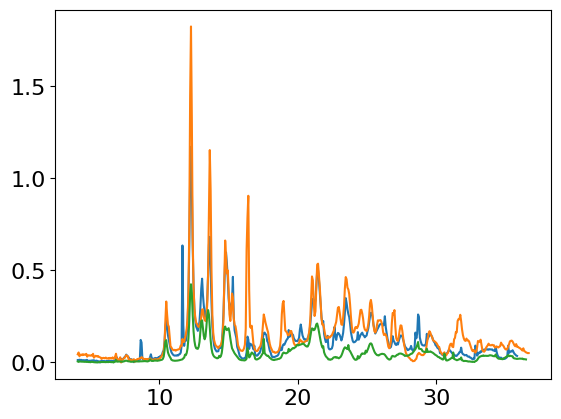

In [8]:
plt.plot(reloaded_dic["FINAL_Background_Removal\HZO52_Tamb_qz.txt"][:, 0], 
         reloaded_dic["FINAL_Background_Removal\HZO52_Tamb_qz.txt"][:, 1])

plt.plot(reloaded_dic["FINAL_Background_Removal\HZO21_Tamb_qz.txt"][:, 0], 
         reloaded_dic["FINAL_Background_Removal\HZO21_Tamb_qz.txt"][:, 1])

plt.plot(reloaded_dic["FINAL_Background_Removal\HZO11_Tamb_qz.txt"][:, 0], 
         reloaded_dic["FINAL_Background_Removal\HZO11_Tamb_qz.txt"][:, 1])

FINAL_Background_Removal\HZO11_Tamb_phi.txt
FINAL_Background_Removal\HZO21_Tamb_phi.txt
FINAL_Background_Removal\HZO52_Tamb_phi.txt


Text(0.01, 0.5, 'Intensity (a. u.)')

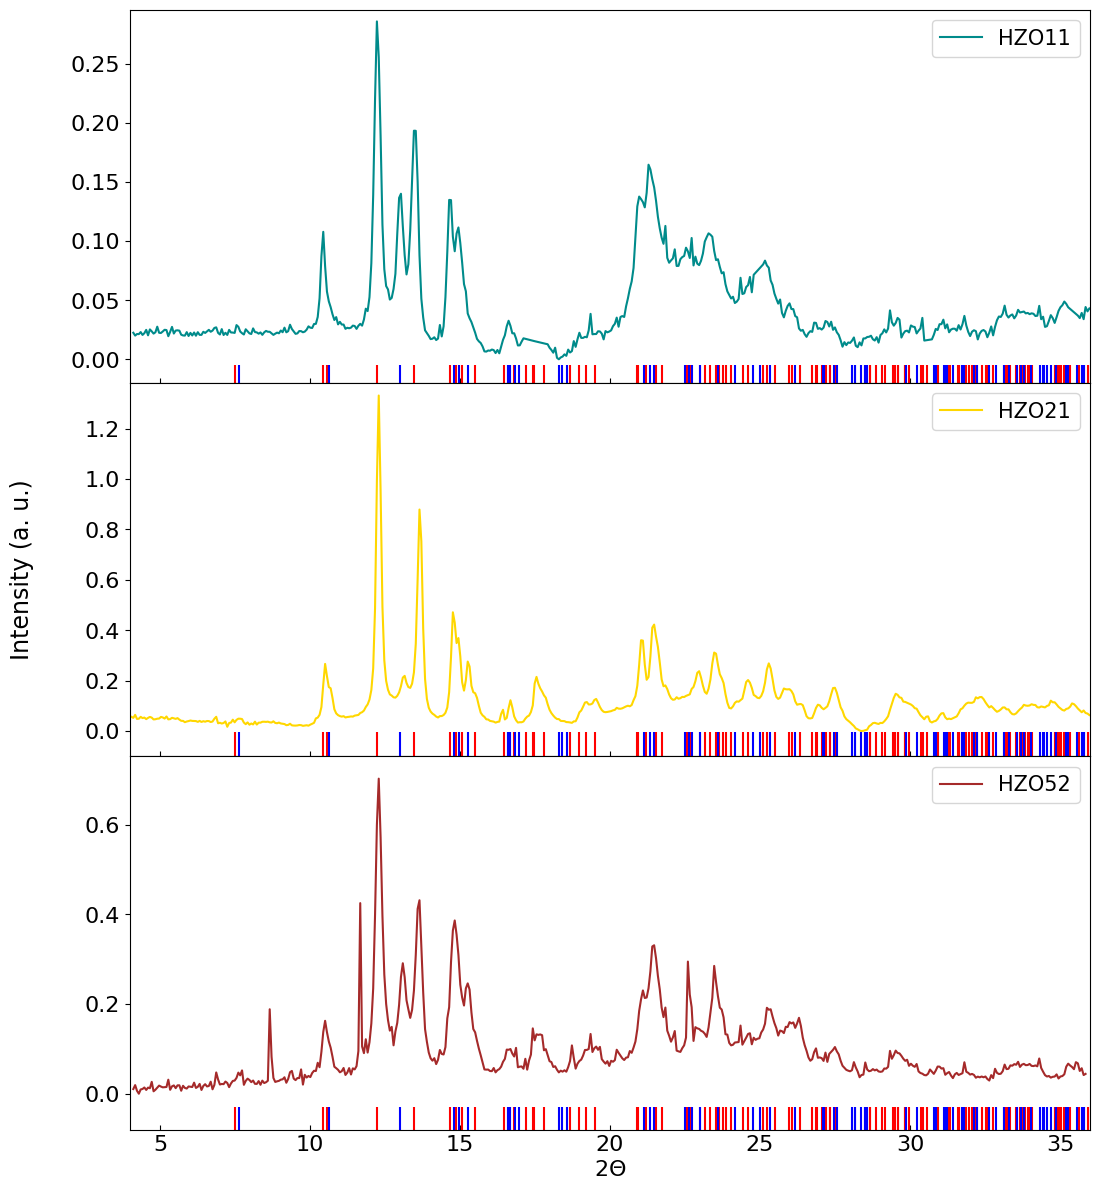

In [20]:
# Plotting all together

nrows = 3

fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(12,14), sharex=True)

idx_subplot = range(nrows)

for key, z in zip(final_data_to_plot, idx_subplot):
    print(key)
    if z == 0:
        color='darkcyan'
    if z == 1:
        color = 'gold'
    if z == 2:
        color = 'brown'
    ax[z].plot(final_data_to_plot[key][:,0], final_data_to_plot[key][:,1], label=key[-18:-13], c=color)
#     ax[z].set_title("(T = 25°C)")
#     ax[z].hist(deux_theta_mono)
    ax[z].legend(fontsize=15)
    ax[z].tick_params(axis='x', direction='in')
    
    
ax[0].set(ylim=(-0.02, max(final_data_to_plot['FINAL_Background_Removal\\HZO11_Tamb_phi.txt'][:,1])+0.01),
          xlim=(4, 36))

for xc in deux_theta_mono:
#         ax[z].axvline(x=xc)
    ax[0].vlines(x=xc, ymin=[-0.02], ymax=[-0.005], colors='red')

for xc2 in deux_theta_ortho:
#         ax[z].axvline(x=xc)
    ax[0].vlines(x=xc2, ymin=[-0.02], ymax=[-0.005], colors='blue') 
    
    
ax[1].set(ylim=(-0.1, max(final_data_to_plot['FINAL_Background_Removal\\HZO21_Tamb_phi.txt'][:,1])+0.05))

for xc in deux_theta_mono:
#         ax[z].axvline(x=xc)
    ax[1].vlines(x=xc, ymin=[-0.1], ymax=[-0.005], colors='red')

for xc2 in deux_theta_ortho:
#         ax[z].axvline(x=xc)
    ax[1].vlines(x=xc2, ymin=[-0.1], ymax=[-0.005], colors='blue') 
    

ax[2].set(ylim=(-0.08, max(final_data_to_plot['FINAL_Background_Removal\\HZO52_Tamb_phi.txt'][:,1])+0.05))

for xc in deux_theta_mono:
#         ax[z].axvline(x=xc)
    ax[2].vlines(x=xc, ymin=[-0.08], ymax=[-0.03], colors='red')

for xc2 in deux_theta_ortho:
#         ax[z].axvline(x=xc)
    ax[2].vlines(x=xc2, ymin=[-0.08], ymax=[-0.03], colors='blue') 


plt.subplots_adjust(left=0.1,
                bottom=0.1, 
                right=0.9, 
                top=0.9, 
                wspace=0.2, 
                hspace=0)
    
ax[z].set(xlabel="2$\Theta$")
fig.text(0.01, 0.5, 'Intensity (a. u.)', ha='center', va='center', rotation='vertical', fontsize = 17)
# fig.text(0.45, 0.95, "HZO", fontsize = 17)    





#### Only 11 and 21 nm

FINAL_Background_Removal\HZO11_Tamb_phi.txt
FINAL_Background_Removal\HZO21_Tamb_phi.txt


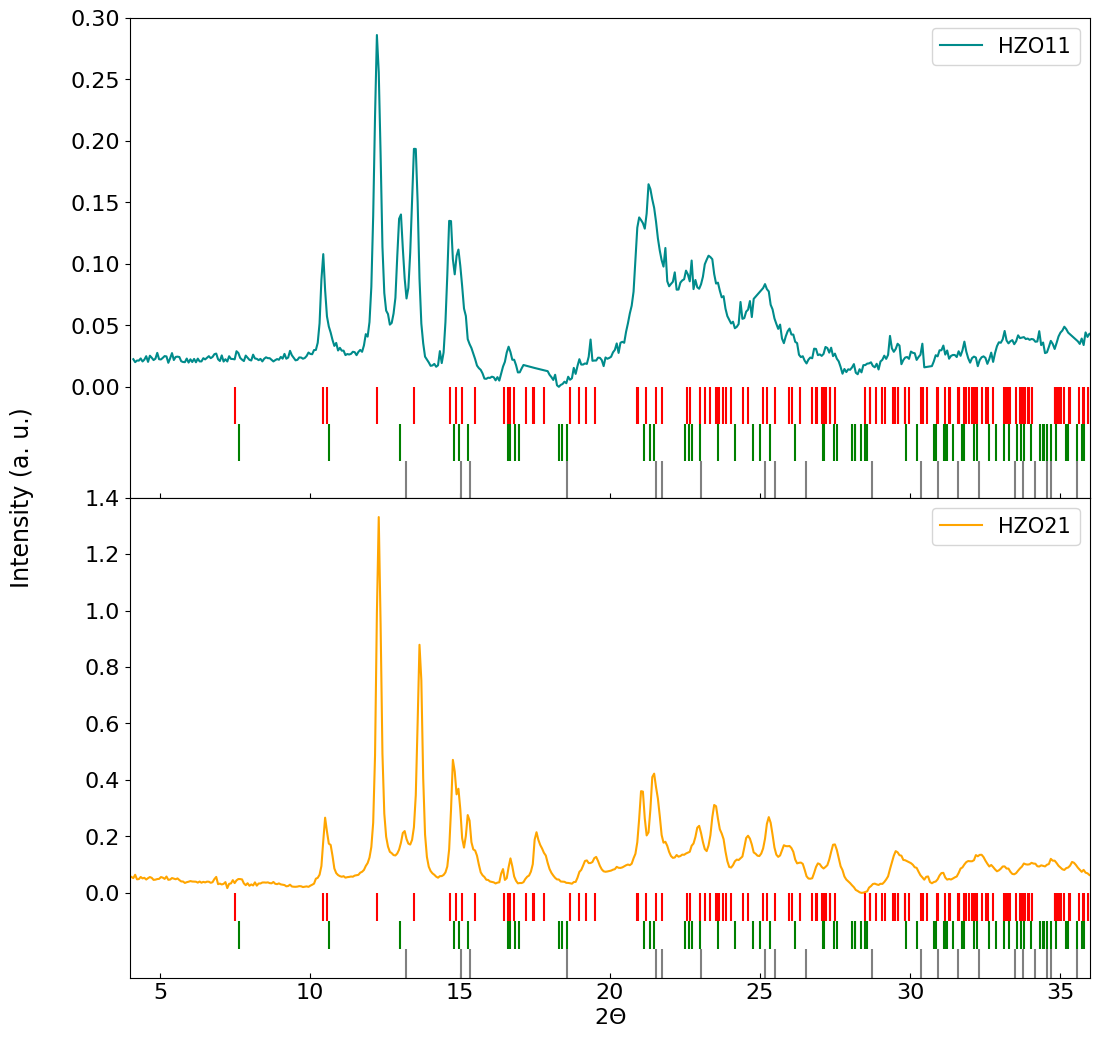

In [21]:
# Plotting all together

nrows = 2

fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(12,12), sharex=True)

idx_subplot = range(nrows)

for key, z in zip(final_data_to_plot, idx_subplot):
    print(key)
    if z == 0:
        color='darkcyan'
    if z == 1:
        color = 'orange'
    if z == 2:
        continue
#         color = 'brown'
    ax[z].plot(final_data_to_plot[key][:,0], final_data_to_plot[key][:,1], label=key[-18:-13], c=color)
#     ax[z].set_title("(T = 25°C)")
#     ax[z].hist(deux_theta_mono)
    ax[z].legend(fontsize=15)
    ax[z].tick_params(axis='x', direction='in')
    
    
    
ax[0].set(ylim=(-0.09, max(final_data_to_plot['FINAL_Background_Removal\\HZO11_Tamb_phi.txt'][:,1])+0.01),
          xlim=(4, 36))

for xc in deux_theta_mono:
#         ax[z].axvline(x=xc)
    ax[0].vlines(x=xc, ymin=[-0.03], ymax=[-0.00], colors='red', label='theoretical peak positions m-phase')
# ax[0].legend(fontsize=15)

for xc2 in deux_theta_ortho:
#         ax[z].axvline(x=xc)
    ax[0].vlines(x=xc2, ymin=[-0.06], ymax=[-0.03], colors='green', label='theoretical peak positions polar o-phase') 
    
for xc3 in deux_theta_tetra:
#         ax[z].axvline(x=xc)
    ax[0].vlines(x=xc3, ymin=[-0.09], ymax=[-0.06], colors='gray', label='theoretical peak positions t-phase')    
# ax[0].legend(fontsize=15)
    
ax[1].set(ylim=(-0.3, max(final_data_to_plot['FINAL_Background_Removal\\HZO21_Tamb_phi.txt'][:,1])+0.05))

for xc in deux_theta_mono:
#         ax[z].axvline(x=xc)
    ax[1].vlines(x=xc, ymin=[-0.1], ymax=[-0.00], colors='red')

for xc2 in deux_theta_ortho:
#         ax[z].axvline(x=xc)
    ax[1].vlines(x=xc2, ymin=[-0.2], ymax=[-0.1], colors='green') 
    
for xc3 in deux_theta_tetra:
#     print(xc3)
#         ax[z].axvline(x=xc)
    ax[1].vlines(x=xc3, ymin=[-0.3], ymax=[-0.2], colors='gray', label='theoretical peak positions t-phase')
    

# ax[2].set(ylim=(-0.08, max(final_data_to_plot['FINAL_Background_Removal\\HZO52_Tamb_phi.txt'][:,1])+0.05))

# for xc in deux_theta_mono:
# #         ax[z].axvline(x=xc)
#     ax[2].vlines(x=xc, ymin=[-0.08], ymax=[-0.03], colors='red')

# for xc2 in deux_theta_ortho:
# #         ax[z].axvline(x=xc)
#     ax[2].vlines(x=xc2, ymin=[-0.08], ymax=[-0.03], colors='blue') 


plt.subplots_adjust(left=0.1,
                bottom=0.1, 
                right=0.9, 
                top=0.9, 
                wspace=0.2, 
                hspace=0)
    
ax[z].set(xlabel="2$\Theta$")
fig.text(0.01, 0.5, 'Intensity (a. u.)', ha='center', va='center', rotation='vertical', fontsize = 17)
# fig.text(0.45, 0.95, "HZO", fontsize = 17)    



ax[0].set_yticks(ax[0].get_yticks()[2:])
ax[1].set_yticks(ax[1].get_yticks()[2:])



FINAL_Background_Removal\HZO11_Tamb_phi.txt
FINAL_Background_Removal\HZO21_Tamb_phi.txt


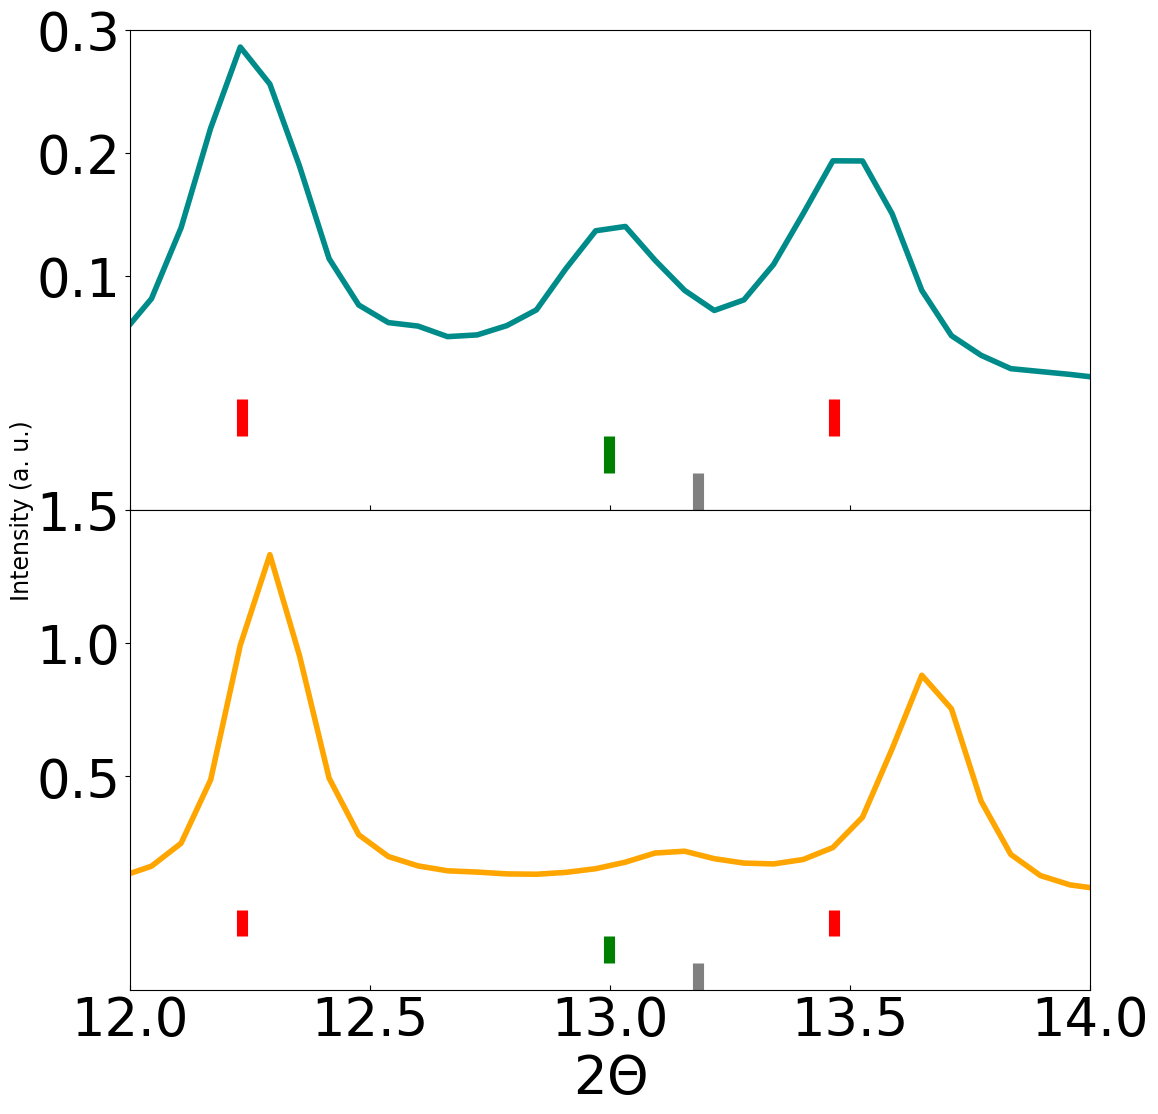

In [31]:
# Plotting all together

nrows = 2

fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(12,12), sharex=True)

idx_subplot = range(nrows)

for key, z in zip(final_data_to_plot, idx_subplot):
    print(key)
    if z == 0:
        color='darkcyan'
    if z == 1:
        color = 'orange'
    if z == 2:
        continue
#         color = 'brown'
    ax[z].plot(final_data_to_plot[key][:,0], final_data_to_plot[key][:,1], label=key[-18:-13], c=color, linewidth=4)
#     ax[z].set_title("(T = 25°C)")
#     ax[z].hist(deux_theta_mono)
#     ax[z].legend(fontsize=15)
    ax[z].tick_params(axis='x', direction='in')
    
    
    
ax[0].set(ylim=(-0.09, max(final_data_to_plot['FINAL_Background_Removal\\HZO11_Tamb_phi.txt'][:,1])+0.01),
          xlim=(12, 14))

for xc in deux_theta_mono:
#         ax[z].axvline(x=xc)
    ax[0].vlines(x=xc, ymin=[-0.03], ymax=[-0.00], colors='red', linewidth=8)
# ax[0].legend(fontsize=15)

for xc2 in deux_theta_ortho:
#         ax[z].axvline(x=xc)
    ax[0].vlines(x=xc2, ymin=[-0.06], ymax=[-0.03], colors='green', linewidth=8) 
    
for xc3 in deux_theta_tetra:
#         ax[z].axvline(x=xc)
    ax[0].vlines(x=xc3, ymin=[-0.09], ymax=[-0.06], colors='gray', linewidth=8)    
# ax[0].legend(fontsize=15)
    
ax[1].set(ylim=(-0.3, max(final_data_to_plot['FINAL_Background_Removal\\HZO21_Tamb_phi.txt'][:,1])+0.05))

for xc in deux_theta_mono:
#         ax[z].axvline(x=xc)
    ax[1].vlines(x=xc, ymin=[-0.1], ymax=[-0.00], colors='red', linewidth=8)

for xc2 in deux_theta_ortho:
#         ax[z].axvline(x=xc)
    ax[1].vlines(x=xc2, ymin=[-0.2], ymax=[-0.1], colors='green', linewidth=8) 
    
for xc3 in deux_theta_tetra:
#     print(xc3)
#         ax[z].axvline(x=xc)
    ax[1].vlines(x=xc3, ymin=[-0.3], ymax=[-0.2], colors='gray', linewidth=8)
    

# ax[2].set(ylim=(-0.08, max(final_data_to_plot['FINAL_Background_Removal\\HZO52_Tamb_phi.txt'][:,1])+0.05))

# for xc in deux_theta_mono:
# #         ax[z].axvline(x=xc)
#     ax[2].vlines(x=xc, ymin=[-0.08], ymax=[-0.03], colors='red')

# for xc2 in deux_theta_ortho:
# #         ax[z].axvline(x=xc)
#     ax[2].vlines(x=xc2, ymin=[-0.08], ymax=[-0.03], colors='blue') 


plt.subplots_adjust(left=0.1,
                bottom=0.1, 
                right=0.9, 
                top=0.9, 
                wspace=0.2, 
                hspace=0)
    
ax[z].set(xlabel="2$\Theta$")
fig.text(0.01, 0.5, 'Intensity (a. u.)', ha='center', va='center', rotation='vertical', fontsize = 17)
# fig.text(0.45, 0.95, "HZO", fontsize = 17)    

ax[0].set_yticks(ax[0].get_yticks()[2:])
ax[1].set_yticks(ax[1].get_yticks()[2:])

plt.rcParams.update({'font.size': 38})

### Referee corrections - Papier HZO

theta_Cu = arcsin ( 2.29 x sin(theta_synchrotron)). (Attention, dans le graph on représente le 2*theta, pas le theta!) 

#### Converting the exp deux_theta data

In [68]:
HZO11_theta_sync = final_data_to_plot['FINAL_Background_Removal\\HZO11_Tamb_phi.txt'][:,0]
# HZO11_theta_sync

In [67]:
HZO11_theta_sync = final_data_to_plot['FINAL_Background_Removal\\HZO11_Tamb_phi.txt'][:,0]
HZO11_theta_sync = (HZO11_theta_sync/2) * 0.0174533 #(degree to radians)
# HZO11_theta_sync

In [66]:
# np.sin(HZO11_theta_sync)*2.29

In [41]:
np.arcsin(1.1)

C:\Users\rebce\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in arcsin
  """Entry point for launching an IPython kernel.


nan

In [65]:
HZO11_theta_Cu = np.arcsin(2.29 * np.sin(HZO11_theta_sync))
# HZO11_theta_Cu

In [86]:
# opening the 2theta_synchrotron data (goes from 4 to 36 2theta degrees, as in the XRD figure S2 of the HZO paper)
HZO11_deux_theta_sync = final_data_to_plot['FINAL_Background_Removal\\HZO11_Tamb_phi.txt'][:,0]

# dividing 2theta by 2 and converting degree to radian
HZO11_theta_sync = (HZO11_deux_theta_sync/2) * 0.0174533 

# calculating theta_Cu
HZO11_theta_Cu = np.arcsin(2.29 * np.sin(HZO11_theta_sync))

# reconverting back from radian to degree, and then from theta to 2theta
HZO11_deux_theta_Cu = HZO11_theta_Cu * 57.2958 * 2

array([ 9.42191398,  9.56286451,  9.70382954,  9.84480929,  9.98580398,
       10.12681384, 10.26783907, 10.40887989, 10.54993653, 10.6910092 ,
       10.83209812, 10.97320352, 11.11432561, 11.25546461, 11.39662075,
       11.53779423, 11.67898529, 11.82019415, 11.96142102, 12.10266613,
       12.2439297 , 12.38521195, 12.5265131 , 12.66783338, 12.80917301,
       12.95053221, 13.0919112 , 13.23331022, 13.37472947, 13.5161692 ,
       13.65762961, 13.79911095, 13.94061342, 14.08213726, 14.22368269,
       14.36524994, 14.50683924, 14.6484508 , 14.79008487, 14.93174166,
       15.0734214 , 15.21512432, 15.35685065, 15.49860062, 15.64037446,
       15.78217239, 15.92399464, 16.06584145, 16.20771305, 16.34960966,
       16.49153151, 16.63347885, 16.77545189, 16.91745088, 17.05947604,
       17.2015276 , 17.34360581, 17.48571089, 17.62784308, 17.7700026 ,
       17.91218971, 18.05440462, 18.19664759, 18.33891883, 18.4812186 ,
       18.62354712, 18.76590463, 18.90829137, 19.05070759, 19.19

In [87]:
# opening the 2theta_synchrotron data (goes from 4 to 36 2theta degree, as in XRD paper figure S2)
HZO21_deux_theta_sync = final_data_to_plot['FINAL_Background_Removal\\HZO21_Tamb_phi.txt'][:,0]

# dividing 2theta by 2 and converting degree to radian
HZO21_theta_sync = (HZO21_deux_theta_sync/2) * 0.0174533 

# calculating theta_Cu
HZO21_theta_Cu = np.arcsin(2.29 * np.sin(HZO21_theta_sync))

# reconvert from radian to degree, and then from theta to 2theta
HZO21_deux_theta_Cu = HZO21_theta_Cu * 57.2958 * 2
HZO21_deux_theta_Cu

array([ 9.28097774,  9.42191398,  9.56286451,  9.70382954,  9.84480929,
        9.98580398, 10.12681384, 10.26783907, 10.40887989, 10.54993653,
       10.6910092 , 10.83209812, 10.97320352, 11.11432561, 11.25546461,
       11.39662075, 11.53779423, 11.67898529, 11.82019415, 11.96142102,
       12.10266613, 12.2439297 , 12.38521195, 12.5265131 , 12.66783338,
       12.80917301, 12.95053221, 13.0919112 , 13.23331022, 13.37472947,
       13.5161692 , 13.65762961, 13.79911095, 13.94061342, 14.08213726,
       14.22368269, 14.36524994, 14.50683924, 14.6484508 , 14.79008487,
       14.93174166, 15.0734214 , 15.21512432, 15.35685065, 15.49860062,
       15.64037446, 15.78217239, 15.92399464, 16.06584145, 16.20771305,
       16.34960966, 16.49153151, 16.63347885, 16.77545189, 16.91745088,
       17.05947604, 17.2015276 , 17.34360581, 17.48571089, 17.62784308,
       17.7700026 , 17.91218971, 18.05440462, 18.19664759, 18.33891883,
       18.4812186 , 18.62354712, 18.76590463, 18.90829137, 19.05

In [89]:
reloaded_dic = {}

filenames = glob.glob("FINAL_Background_Removal/*.txt")
filenames

for file in filenames:
    sample = np.loadtxt(file, delimiter=" ", dtype=float)
    reloaded_dic[file] = sample

final_data_to_plot = {}

for key in reloaded_dic:
    Tamb = [t for t in key.split(sep="_") if t.startswith('Tamb')]
#     print(key)
#     print(Tamb)
    if "Tamb" in Tamb:
#         print(key)
        phi = [t for t in key.split(sep="_") if t.startswith('p')]
        if "phi.txt" in phi:
#             print("phi")
            final_data_to_plot[key] = reloaded_dic[key]
        else:
            continue
# final_data_to_plot     

final_data_to_plot_referee = final_data_to_plot
final_data_to_plot_referee['FINAL_Background_Removal\\HZO21_Tamb_phi.txt'][:,0] = HZO21_deux_theta_Cu
final_data_to_plot_referee['FINAL_Background_Removal\\HZO11_Tamb_phi.txt'][:,0] = HZO11_deux_theta_Cu
final_data_to_plot_referee

{'FINAL_Background_Removal\\HZO11_Tamb_phi.txt': array([[9.42191398e+00, 2.24302079e-02],
        [9.56286451e+00, 2.00331537e-02],
        [9.70382954e+00, 2.13730994e-02],
        ...,
        [9.12287322e+01, 4.22929911e-02],
        [9.14297298e+01, 4.34278468e-02],
        [9.16310896e+01, 4.27135597e-02]]),
 'FINAL_Background_Removal\\HZO21_Tamb_phi.txt': array([[9.28097774e+00, 5.62046888e-02],
        [9.42191398e+00, 5.22371708e-02],
        [9.56286451e+00, 6.40986527e-02],
        ...,
        [9.18328140e+01, 2.50655518e-02],
        [9.20349058e+01, 2.03940541e-02],
        [9.22373676e+01, 2.30724799e-02]]),
 'FINAL_Background_Removal\\HZO52_Tamb_phi.txt': array([[4.11061698e+00, 1.04513506e-02],
        [4.17199640e+00, 1.92005669e-02],
        [4.23337702e+00, 6.54878334e-03],
        ...,
        [3.57233780e+01, 5.68385108e-02],
        [3.57878301e+01, 4.16231741e-02],
        [3.58522940e+01, 4.42548391e-02]])}

#### Converting the theoretical deux_thetas

In [79]:
# opening the 2theta theoretical data (goes from 4 to 36 2theta degree, as in XRD paper figure S2)
deux_theta_mono_sync = deux_theta_mono

# dividing 2theta by 2 and converting degree to radian
theta_mono_sync = (deux_theta_mono_sync/2) * 0.0174533 

# calculating theta_Cu
theta_mono_Cu = np.arcsin(2.29 * np.sin(theta_mono_sync))

# reconvert from radian to degree, and then from theta to 2theta
deux_theta_mono_Cu = theta_mono_Cu * 57.2958 * 2
deux_theta_mono_Cu

0       17.255866
1       24.023370
2       24.336085
3       28.246490
4       31.149735
          ...    
157    102.766638
158    103.121156
159    103.892401
160    104.167288
161    104.335485
Name: d-spacing, Length: 162, dtype: float64

In [78]:
# opening the 2theta theoretical data (goes from 4 to 36 2theta degree, as in XRD paper figure S2)
deux_theta_ortho_sync = deux_theta_ortho

# dividing 2theta by 2 and converting degree to radian
theta_ortho_sync = (deux_theta_ortho_sync/2) * 0.0174533 

# calculating theta_Cu
theta_ortho_Cu = np.arcsin(2.29 * np.sin(theta_ortho_sync))

# reconvert from radian to degree, and then from theta to 2theta
deux_theta_ortho_Cu = theta_ortho_Cu * 57.2958 * 2
deux_theta_ortho_Cu

0      17.497448
1      24.468320
2      30.044665
3      34.326221
4      34.736646
         ...    
83    100.652369
84    101.553394
85    101.752578
86    102.080247
87    104.172146
Name: d-spacing, Length: 88, dtype: float64

In [77]:
# opening the 2theta theoretical data (goes from 4 to 36 2theta degree, as in XRD paper figure S2)
deux_theta_tetra_sync = deux_theta_tetra

# dividing 2theta by 2 and converting degree to radian
theta_tetra_sync = (deux_theta_tetra_sync/2) * 0.0174533 

# calculating theta_Cu
theta_tetra_Cu = np.arcsin(2.29 * np.sin(theta_tetra_sync))

# reconvert from radian to degree, and then from theta to 2theta
deux_theta_tetra_Cu = theta_tetra_Cu * 57.2958 * 2
deux_theta_tetra_Cu

0      30.483576
1      34.886235
2      35.570086
3      43.365221
4      50.676820
5      51.184901
6      54.417014
7      59.844187
8      60.752459
9      63.442322
10     69.280034
11     73.670711
12     75.308267
13     77.146427
14     79.172100
15     82.578801
16     83.373705
17     84.573893
18     85.761534
19     86.156983
20     88.733926
21     91.111031
22     95.280599
23     96.470267
24    100.680436
25    102.502914
26    104.124410
27    104.939422
Name: d-spacing, dtype: float64

#### Plotting

FINAL_Background_Removal\HZO11_Tamb_phi.txt
FINAL_Background_Removal\HZO21_Tamb_phi.txt


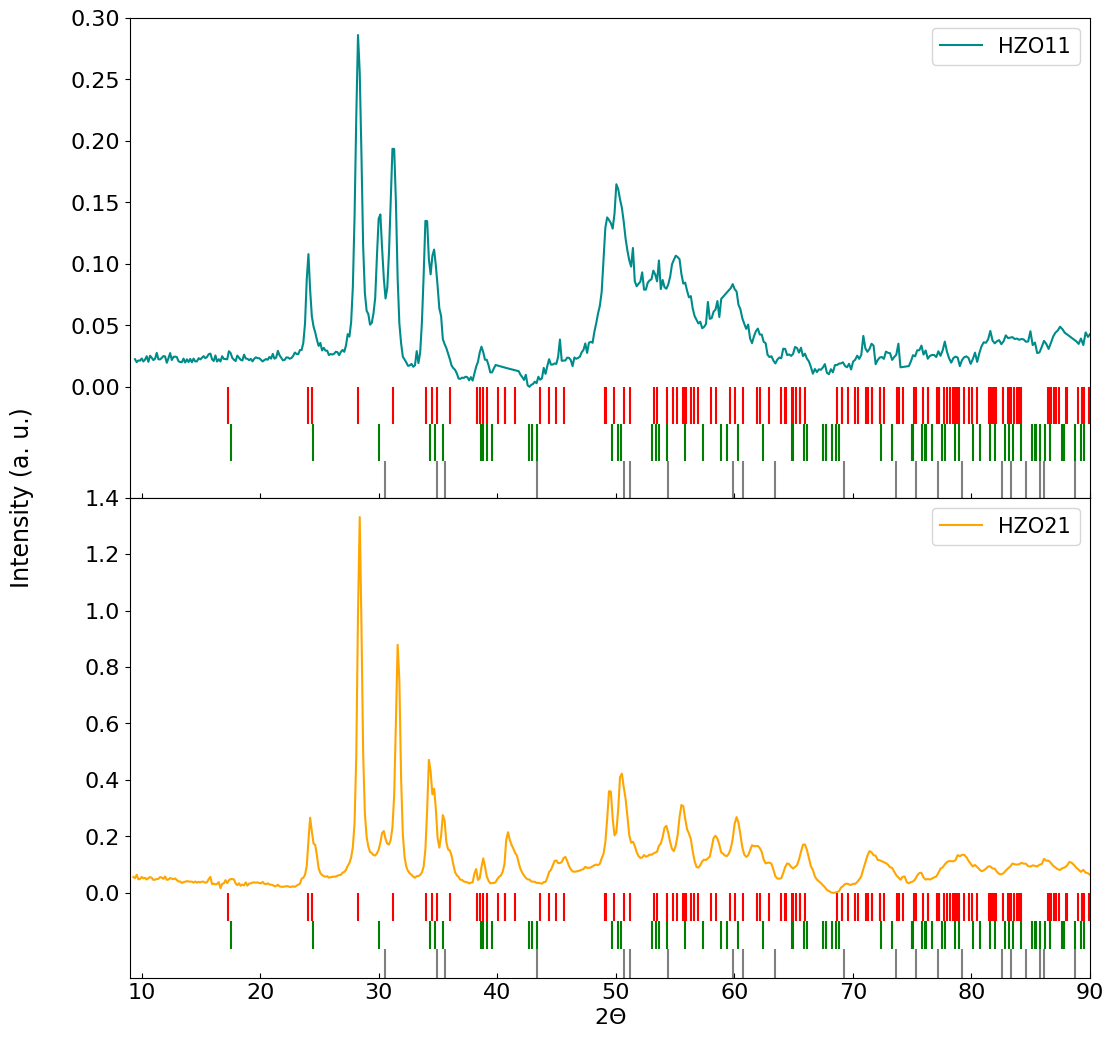

In [93]:
# Plotting all together

nrows = 2

fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(12,12), sharex=True)

idx_subplot = range(nrows)

for key, z in zip(final_data_to_plot_referee, idx_subplot):
    print(key)
    if z == 0:
        color='darkcyan'
    if z == 1:
        color = 'orange'
    if z == 2:
        continue
#         color = 'brown'
    ax[z].plot(final_data_to_plot_referee[key][:,0], final_data_to_plot_referee[key][:,1], label=key[-18:-13], c=color)
#     ax[z].set_title("(T = 25°C)")
#     ax[z].hist(deux_theta_mono)
    ax[z].legend(fontsize=15)
    ax[z].tick_params(axis='x', direction='in')
    
    
    
ax[0].set(ylim=(-0.09, max(final_data_to_plot_referee['FINAL_Background_Removal\\HZO11_Tamb_phi.txt'][:,1])+0.01),
          xlim=(9, 90))

for xc in deux_theta_mono_Cu:
#         ax[z].axvline(x=xc)
    ax[0].vlines(x=xc, ymin=[-0.03], ymax=[-0.00], colors='red', label='theoretical peak positions m-phase')
# ax[0].legend(fontsize=15)

for xc2 in deux_theta_ortho_Cu:
#         ax[z].axvline(x=xc)
    ax[0].vlines(x=xc2, ymin=[-0.06], ymax=[-0.03], colors='green', label='theoretical peak positions polar o-phase') 
    
for xc3 in deux_theta_tetra_Cu:
#         ax[z].axvline(x=xc)
    ax[0].vlines(x=xc3, ymin=[-0.09], ymax=[-0.06], colors='gray', label='theoretical peak positions t-phase')    
# ax[0].legend(fontsize=15)
    
ax[1].set(ylim=(-0.3, max(final_data_to_plot_referee['FINAL_Background_Removal\\HZO21_Tamb_phi.txt'][:,1])+0.05))

for xc in deux_theta_mono_Cu:
#         ax[z].axvline(x=xc)
    ax[1].vlines(x=xc, ymin=[-0.1], ymax=[-0.00], colors='red')

for xc2 in deux_theta_ortho_Cu:
#         ax[z].axvline(x=xc)
    ax[1].vlines(x=xc2, ymin=[-0.2], ymax=[-0.1], colors='green') 
    
for xc3 in deux_theta_tetra_Cu:
#     print(xc3)
#         ax[z].axvline(x=xc)
    ax[1].vlines(x=xc3, ymin=[-0.3], ymax=[-0.2], colors='gray', label='theoretical peak positions t-phase')
    

# ax[2].set(ylim=(-0.08, max(final_data_to_plot_referee['FINAL_Background_Removal\\HZO52_Tamb_phi.txt'][:,1])+0.05))

# for xc in deux_theta_mono:
# #         ax[z].axvline(x=xc)
#     ax[2].vlines(x=xc, ymin=[-0.08], ymax=[-0.03], colors='red')

# for xc2 in deux_theta_ortho:
# #         ax[z].axvline(x=xc)
#     ax[2].vlines(x=xc2, ymin=[-0.08], ymax=[-0.03], colors='blue') 


plt.subplots_adjust(left=0.1,
                bottom=0.1, 
                right=0.9, 
                top=0.9, 
                wspace=0.2, 
                hspace=0)
    
ax[z].set(xlabel="2$\Theta$")
fig.text(0.01, 0.5, 'Intensity (a. u.)', ha='center', va='center', rotation='vertical', fontsize = 17)
# fig.text(0.45, 0.95, "HZO", fontsize = 17)    



ax[0].set_yticks(ax[0].get_yticks()[2:])
ax[1].set_yticks(ax[1].get_yticks()[2:])



FINAL_Background_Removal\HZO11_Tamb_phi.txt
FINAL_Background_Removal\HZO21_Tamb_phi.txt


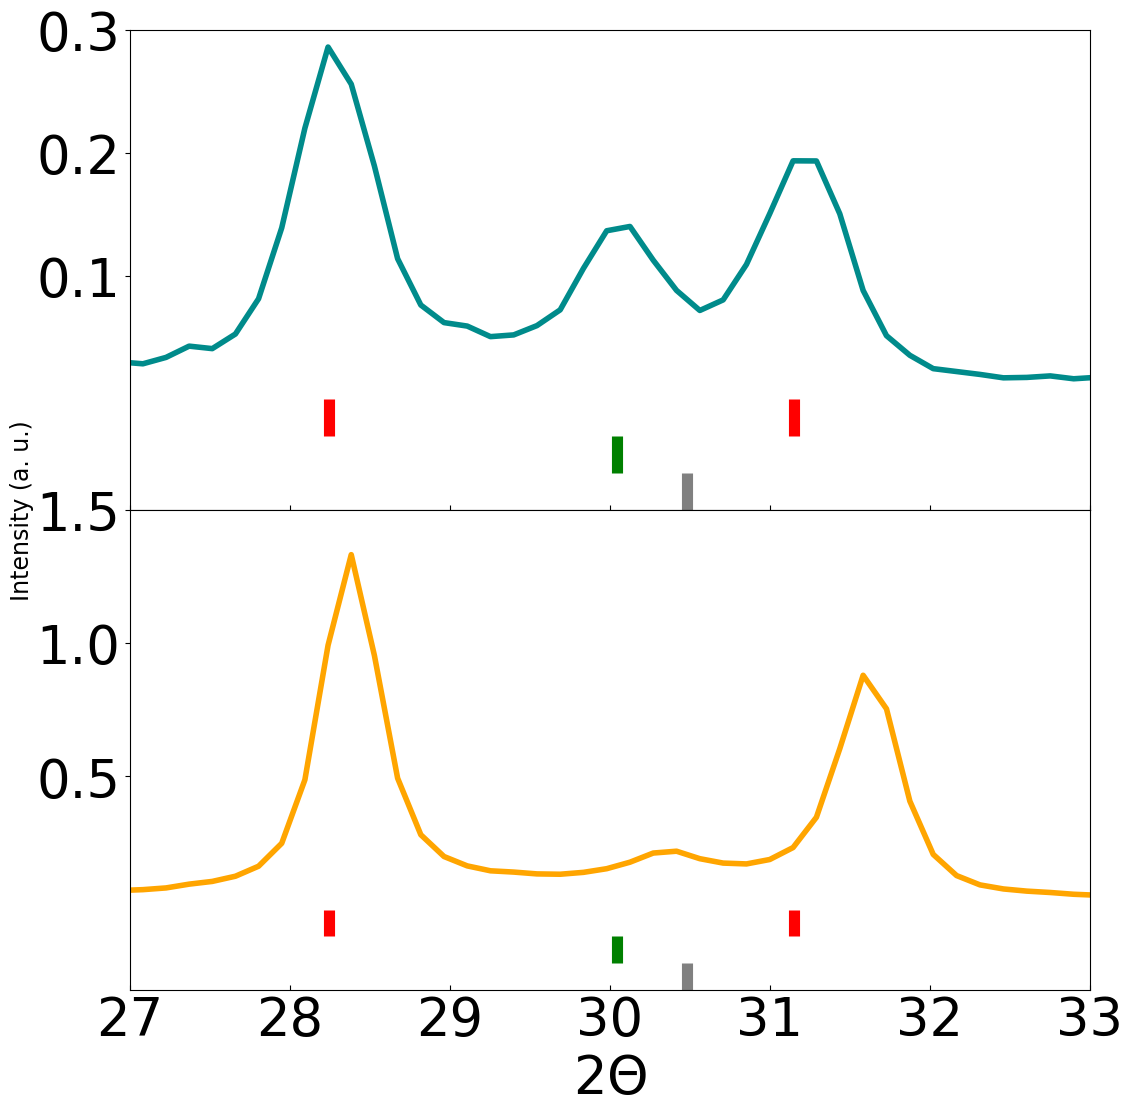

In [102]:
# Plotting all together

nrows = 2

fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(12,12), sharex=True)

idx_subplot = range(nrows)

for key, z in zip(final_data_to_plot_referee, idx_subplot):
    print(key)
    if z == 0:
        color='darkcyan'
    if z == 1:
        color = 'orange'
    if z == 2:
        continue
#         color = 'brown'
    ax[z].plot(final_data_to_plot_referee[key][:,0], final_data_to_plot_referee[key][:,1], label=key[-18:-13], c=color, linewidth=4)
#     ax[z].set_title("(T = 25°C)")
#     ax[z].hist(deux_theta_mono)
#     ax[z].legend(fontsize=15)
    ax[z].tick_params(axis='x', direction='in')
    
    
    
ax[0].set(ylim=(-0.09, max(final_data_to_plot_referee['FINAL_Background_Removal\\HZO11_Tamb_phi.txt'][:,1])+0.01),
          xlim=(27, 33))

for xc in deux_theta_mono_Cu:
#         ax[z].axvline(x=xc)
    ax[0].vlines(x=xc, ymin=[-0.03], ymax=[-0.00], colors='red', linewidth=8)
# ax[0].legend(fontsize=15)

for xc2 in deux_theta_ortho_Cu:
#         ax[z].axvline(x=xc)
    ax[0].vlines(x=xc2, ymin=[-0.06], ymax=[-0.03], colors='green', linewidth=8) 
    
for xc3 in deux_theta_tetra_Cu:
#         ax[z].axvline(x=xc)
    ax[0].vlines(x=xc3, ymin=[-0.09], ymax=[-0.06], colors='gray', linewidth=8)    
# ax[0].legend(fontsize=15)
    
ax[1].set(ylim=(-0.3, max(final_data_to_plot_referee['FINAL_Background_Removal\\HZO21_Tamb_phi.txt'][:,1])+0.05))

for xc in deux_theta_mono_Cu:
#         ax[z].axvline(x=xc)
    ax[1].vlines(x=xc, ymin=[-0.1], ymax=[-0.00], colors='red', linewidth=8)

for xc2 in deux_theta_ortho_Cu:
#         ax[z].axvline(x=xc)
    ax[1].vlines(x=xc2, ymin=[-0.2], ymax=[-0.1], colors='green', linewidth=8) 
    
for xc3 in deux_theta_tetra_Cu:
#     print(xc3)
#         ax[z].axvline(x=xc)
    ax[1].vlines(x=xc3, ymin=[-0.3], ymax=[-0.2], colors='gray', linewidth=8)
    

# ax[2].set(ylim=(-0.08, max(final_data_to_plot_referee['FINAL_Background_Removal\\HZO52_Tamb_phi.txt'][:,1])+0.05))

# for xc in deux_theta_mono:
# #         ax[z].axvline(x=xc)
#     ax[2].vlines(x=xc, ymin=[-0.08], ymax=[-0.03], colors='red')

# for xc2 in deux_theta_ortho:
# #         ax[z].axvline(x=xc)
#     ax[2].vlines(x=xc2, ymin=[-0.08], ymax=[-0.03], colors='blue') 


plt.subplots_adjust(left=0.1,
                bottom=0.1, 
                right=0.9, 
                top=0.9, 
                wspace=0.2, 
                hspace=0)
    
ax[z].set(xlabel="2$\Theta$")
fig.text(0.01, 0.5, 'Intensity (a. u.)', ha='center', va='center', rotation='vertical', fontsize = 17)
# fig.text(0.45, 0.95, "HZO", fontsize = 17)    

ax[0].set_yticks(ax[0].get_yticks()[2:])
ax[1].set_yticks(ax[1].get_yticks()[2:])

plt.rcParams.update({'font.size': 38})

## Plotting the XRD from DFT
- Supercells ATAT do not work: different space groups
- needs to plot either only the ZrO2 and HfO2 or exactly the same space group
atat_HZO_SC_mono14_279

HZO_ATAT_ortho29_24atoms-279

ZrO2_TZVP_sp14_279

ZrO2_TZVP_sp29_3_273

In [7]:
!dir ..\HZO\Resultats_DRX_DFT\*.csv

 Le volume dans le lecteur C n'a pas de nom.
 Le num‚ro de s‚rie du volume est F81E-040C

 R‚pertoire de C:\Users\CEVASIO\OneDrive\Python\HZO\Resultats_DRX_DFT

16/02/2023  10:51            10ÿ644 atat_HZO_SC_mono14_-288.csv
16/02/2023  10:51            10ÿ518 HZO_ATAT_ortho29_24atoms-288.csv
15/02/2023  14:38            10ÿ344 ZrO2_TZVP_sp14_279.csv
               3 fichier(s)           31ÿ506 octets
               0 R‚p(s)   6ÿ720ÿ729ÿ088 octets libres


In [8]:
filenames = glob.glob("..\HZO\Resultats_DRX_DFT\*.csv")
print(filenames)

['..\\HZO\\Resultats_DRX_DFT\\atat_HZO_SC_mono14_-288.csv', '..\\HZO\\Resultats_DRX_DFT\\HZO_ATAT_ortho29_24atoms-288.csv', '..\\HZO\\Resultats_DRX_DFT\\ZrO2_TZVP_sp14_279.csv']


In [9]:
DFT_DRXs = {}
for file in filenames:
    DFT_DRXs[file[25:-4]] = pd.read_csv(file,  
                                 index_col=False,
                                 sep=',',
                                 header='infer',
                                 dtype=float)

atat_HZO_SC_mono14_-288
HZO_ATAT_ortho29_24atoms-288
ZrO2_TZVP_sp14_279


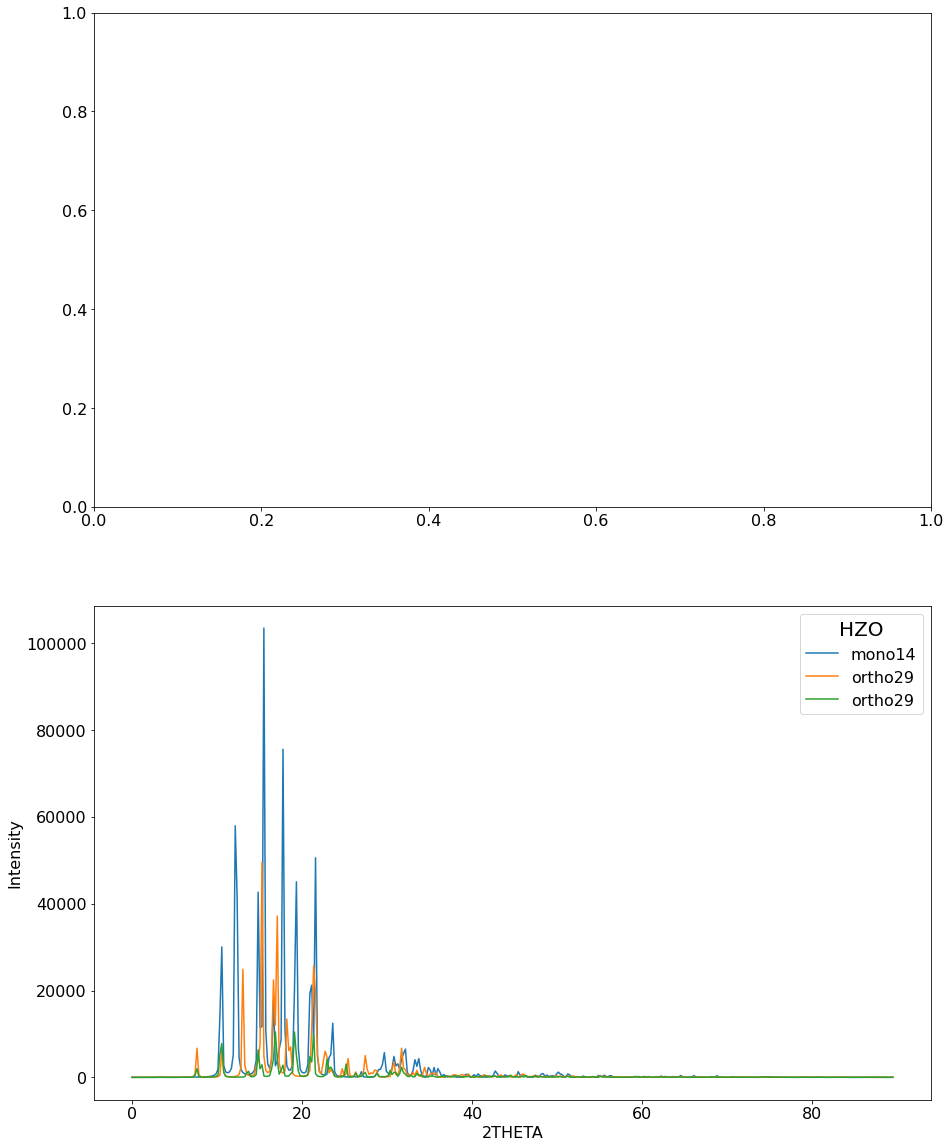

In [10]:
fig, ax = plt.subplots(figsize=(15, 20), nrows=2, ncols=1)

for key in DFT_DRXs:
    print(key)
#     if "ZrO2" in list(key.split("_")):
#         idx = 0
#         title = "ZrO2"
#         if "sp14" in list(key.split("_")):
#             label="mono14"
#         else:
#             label="ortho29"
    if "HZO" in list(key.split("_")):
        idx = 1
        title = "HZO"
        if "mono14" in list(key.split("_")):
            label="mono14"
        else:
            label="ortho29"        
        
    ax[idx].plot(DFT_DRXs[key]["2Theta (DEG)"], DFT_DRXs[key]["Intensity-LP-DW  (a.u.)"], label=label)
    ax[idx].legend(title=title, title_fontsize= 20, fontsize=16)
    ax[idx].set_xlabel('2THETA', fontsize=16)
    ax[idx].set_ylabel('Intensity', fontsize=16)

### Plotting DFT and Exp together

In [15]:
HZO11_Tamb_qz = np.loadtxt('HZO11_Tamb_qz_2Theta.txt')

fig, ax = plt.subplots(figsize=(15, 10), nrows=2, ncols=1)

for key in DFT_DRXs:
    print(key)
    if "ZrO2" in list(key.split("_")):
        idx = 0
        title = "ZrO2"
        if "sp14" in list(key.split("_")):
            label="mono14"
            lambda_conversion=1
        else:
            label="ortho29"
            lambda_conversion=2.2985
    if "HZO" in list(key.split("_")):
        lambda_conversion=2.2985
        idx = 1
        title = "HZO"
        if "mono14" in list(key.split("_")):
            label="mono14"
        else:
            continue
            label="ortho29"        
        
    ax[idx].plot(DFT_DRXs[key]["2Theta (DEG)"], 
                 DFT_DRXs[key]["Intensity-LP-DW  (a.u.)"], 
                 label=label,
                 linestyle='--')
    ax[idx].legend(title=title, title_fontsize= 20, fontsize=16, loc='upper left')
    ax[idx].set_xlabel('2THETA', fontsize=16)
    ax[idx].set_ylabel('Intensity', fontsize=16)
    
ax_0=ax[0].twinx()
# ax_0.plot(HZO11_XRD_final[:, 0], HZO11_XRD_final[:, 1], c='green', label="HZO11_qz")
ax_0.set(xlim=(0, 36))
# ax_0.legend()

ax_1=ax[1].twinx()
# ax_1.plot(HZO11_XRD_final[:, 0], HZO11_XRD_final[:, 1], c='green', label="HZO11_qz")
ax_1.set(xlim=(0, 36))
# ax_1.legend()

OSError: HZO11_Tamb_qz_2Theta.txt not found.

In [12]:
HZO11_Tamb_qz = np.loadtxt('HZO11_Tamb_qz_2Theta.txt')

fig, ax = plt.subplots(figsize=(15, 10), nrows=2, ncols=1)

for key in DFT_DRXs:
    print(key)
    if "ZrO2" in list(key.split("_")):
        idx = 0
        title = "ZrO2"
        if "sp14" in list(key.split("_")):
            label="mono14"
            lambda_conversion=1
        else:
            label="ortho29"
            lambda_conversion=2.2985
    if "HZO" in list(key.split("_")):
        lambda_conversion=2.2985
        idx = 1
        title = "HZO"
        if "mono14" in list(key.split("_")):
            label="mono14"
        else:
            continue
            label="ortho29"        
        
    ax[idx].plot(DFT_DRXs[key]["2Theta (DEG)"], 
                 DFT_DRXs[key]["Intensity (a.u.)"], 
                 label=label,
                 linestyle='-')
    ax[idx].legend(title=title, title_fontsize= 20, fontsize=16, loc='upper left')
    ax[idx].set_xlabel('2THETA', fontsize=16)
    ax[idx].set_ylabel('Intensity', fontsize=16)
    
ax_0=ax[0].twinx()
# ax_0.plot(HZO11_XRD_final[:, 0], HZO11_XRD_final[:, 1], c='green', label="HZO11_qz")
ax_0.set(xlim=(0, 36))
# ax_0.legend()

ax_1=ax[1].twinx()
# ax_1.plot(HZO11_XRD_final[:, 0], HZO11_XRD_final[:, 1], c='green', label="HZO11_qz")
ax_1.set(xlim=(0, 36))
# ax_1.legend()

OSError: HZO11_Tamb_qz_2Theta.txt not found.

In [13]:
DFT_DRXs

{'atat_HZO_SC_mono14_-288':      2Theta (DEG)  Intensity (a.u.)  Intensity-LP (a.u.)  \
 0            0.00              0.00                 0.04   
 1            0.23              0.00                 0.05   
 2            0.45              0.00                 0.06   
 3            0.68              0.00                 0.07   
 4            0.90              0.00                 0.08   
 ..            ...               ...                  ...   
 394         88.65            100.39                17.99   
 395         88.87            216.23                38.65   
 396         89.10             28.88                 5.17   
 397         89.32             10.66                 1.91   
 398         89.55              8.05                 1.44   
 
      Intensity-LP-DW  (a.u.)  
 0                       0.04  
 1                       0.05  
 2                       0.06  
 3                       0.07  
 4                       0.08  
 ..                       ...  
 394           

In [14]:
HZO11_Tamb_qz = np.loadtxt('HZO11_Tamb_qz_2Theta.txt')

fig, ax = plt.subplots(figsize=(15, 20), nrows=2, ncols=1)

for key in DFT_DRXs:
    print(key)
    if "ZrO2" in list(key.split("_")):
        idx = 0
        title = "ZrO2"
        if "sp14" in list(key.split("_")):
            label="mono14"
            lambda_conversion=1
        else:
            label="ortho29"
            lambda_conversion=2.2985
    if "HZO" in list(key.split("_")):
        lambda_conversion=2.2985
        idx = 1
        title = "HZO"
        if "mono14" in list(key.split("_")):
            label="mono14"
        else:
            label="ortho29"        
        
    ax[idx].plot(DFT_DRXs[key]["2Theta (DEG)"], 
                 DFT_DRXs[key]["Intensity-LP-DW  (a.u.)"], 
                 label=label,
                 linestyle='--')
    ax[idx].legend(title=title, title_fontsize= 20, fontsize=16, loc='upper left')
    ax[idx].set_xlabel('2THETA', fontsize=16)
    ax[idx].set_ylabel('Intensity', fontsize=16)
    
ax_0=ax[0].twinx()
ax_0.plot(HZO11_XRD_final[:, 0], HZO11_XRD_final[:, 1], c='green', label="HZO11_qz")
ax_0.set(xlim=(5, 36))
ax_0.legend()

ax_1=ax[1].twinx()
ax_1.plot(HZO11_XRD_final[:, 0], HZO11_XRD_final[:, 1], c='green', label="HZO11_qz")
ax_1.set(xlim=(5, 36))
ax_1.legend()

OSError: HZO11_Tamb_qz_2Theta.txt not found.

['HZO11_background_removal\\HZO11_XRD_final_Tamb_phi.txt', 'HZO11_background_removal\\HZO11_XRD_final_Tamb_qz.txt', 'HZO11_background_removal\\HZO11_XRD_final_Thaute_phi.txt', 'HZO11_background_removal\\HZO11_XRD_final_Thaute_qz.txt']


KeyError: 'HZO_ATAT_ortho29_24atoms-279'

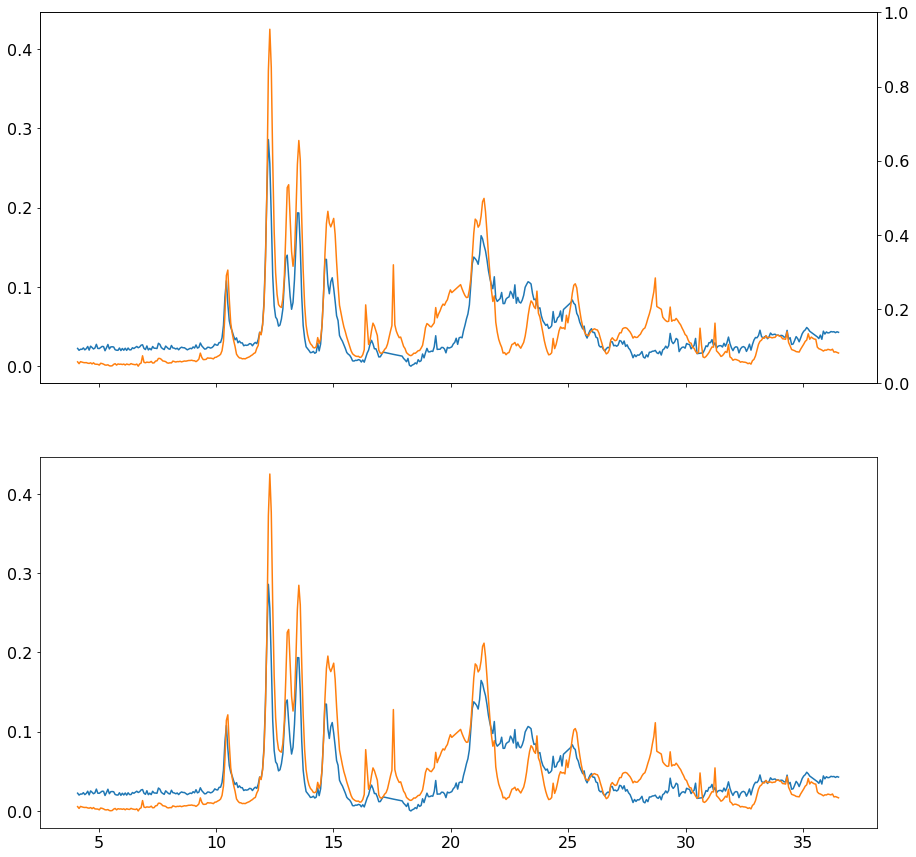

In [516]:
filenames = glob.glob("HZO11_background_removal/*.txt")
print(filenames)

fig, ax = plt.subplots(figsize=(15, 15), nrows=2, ncols=1, sharex=True)

for file in filenames:
    data = np.loadtxt(file)
    if "Thaute" in list(file.split("_")):
        continue
    else:
        ax[0].plot(data[:, 0], data[:, 1], label=file[25:-4])
        ax[1].plot(data[:, 0], data[:, 1], label=file[25:-4])
        
ax_0=ax[0].twinx()     
ax_0.plot(DFT_DRXs['HZO_ATAT_ortho29_24atoms-279']["2Theta (DEG)"]/2.2985,
          DFT_DRXs['HZO_ATAT_ortho29_24atoms-279']["Intensity-LP-DW  (a.u.)"],
          label='HZO ortho 29 - DFT',
          linestyle='--',
          c='green')
ax_0.set(xlim=(0, 40))   
        
ax[0].legend(loc='upper left')        
ax_0.legend(loc='upper right') 


ax_1=ax[1].twinx()     
ax_1.plot(DFT_DRXs['atat_HZO_SC_mono14_279']["2Theta (DEG)"]/2.2985,
          DFT_DRXs['atat_HZO_SC_mono14_279']["Intensity-LP-DW  (a.u.)"],
          label='HZO mono 29 - DFT',
          linestyle='--',
          c='magenta')
ax_1.set(xlim=(5, 36)) 

ax[1].legend(loc='upper left')        
ax_1.legend(loc='upper right') 

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0)

In [528]:
DFT_DRXs

{'atat_HZO_SC_mono14_-288':      2Theta (DEG)  Intensity (a.u.)  Intensity-LP (a.u.)  \
 0            0.00              0.00                 0.04   
 1            0.23              0.00                 0.05   
 2            0.45              0.00                 0.06   
 3            0.68              0.00                 0.07   
 4            0.90              0.00                 0.08   
 ..            ...               ...                  ...   
 394         88.65            100.39                17.99   
 395         88.87            216.23                38.65   
 396         89.10             28.88                 5.17   
 397         89.32             10.66                 1.91   
 398         89.55              8.05                 1.44   
 
      Intensity-LP-DW  (a.u.)  
 0                       0.04  
 1                       0.05  
 2                       0.06  
 3                       0.07  
 4                       0.08  
 ..                       ...  
 394           

Text(0.02, 0.5, 'Intensity')

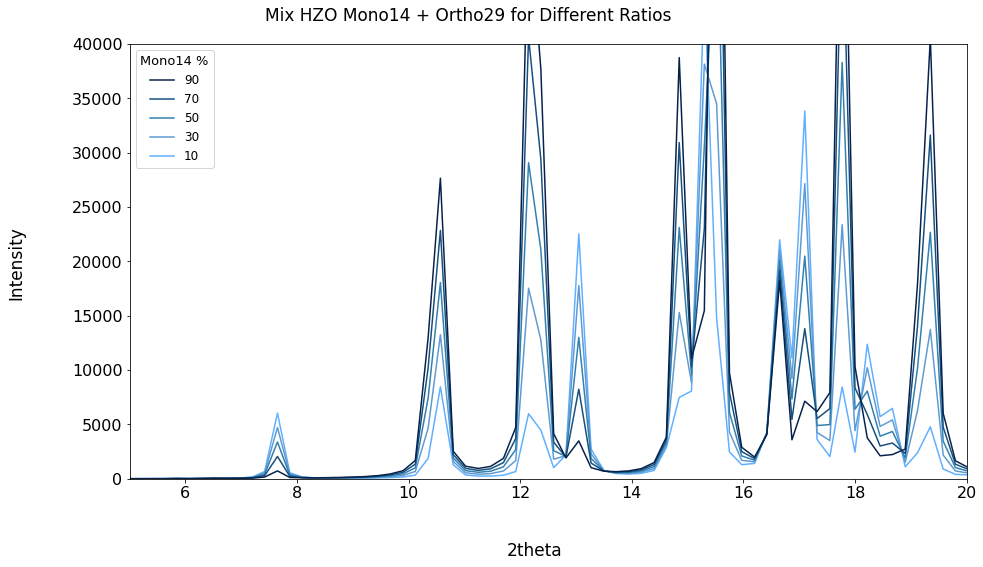

In [536]:
ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

darker = 0.7

HZO_ortho29_DRX_DFT = DFT_DRXs['HZO_ATAT_ortho29_24atoms-288']
HZO_mono14_DRX_DFT = DFT_DRXs['atat_HZO_SC_mono14_-288']

deux_theta = (HZO_ortho29_DRX_DFT["2Theta (DEG)"] + HZO_mono14_DRX_DFT["2Theta (DEG)"])/(2)

colors = plt.cm.Blues(np.linspace(0, 1, len(ratios)))

fig, ax = plt.subplots(figsize=(15,8)) 

for i, j in zip(ratios, colors):
    
    av = HZO_mono14_DRX_DFT["Intensity-LP-DW  (a.u.)"]*i + HZO_ortho29_DRX_DFT["Intensity-LP-DW  (a.u.)"]*(1-i)
        
    ax.plot(deux_theta, av, c=adjust_lightness(j, darker), 
         label=round(i*100))
    
ax.set_xlim(5, 20)
ax.set_ylim(0, 40000)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Mono14 %', title_fontsize= 13, fontsize=12)

fig.text(0.25, 0.92, 'Mix HZO Mono14 + Ortho29 for Different Ratios', fontsize = 17)
fig.text(0.5, 0, '2theta', ha='center', va='center', fontsize = 17)
fig.text(0.02, 0.5, 'Intensity', ha='center', va='center', rotation='vertical', fontsize = 17)

# put_freq(wvn, ortho29_norm, color="black", shift_wvn=-5, shift_Abs=2)
# put_freq(wvn, mono14_norm, color="red", shift_wvn=-5, shift_Abs=2)


Text(0.02, 0.5, 'Intensity')

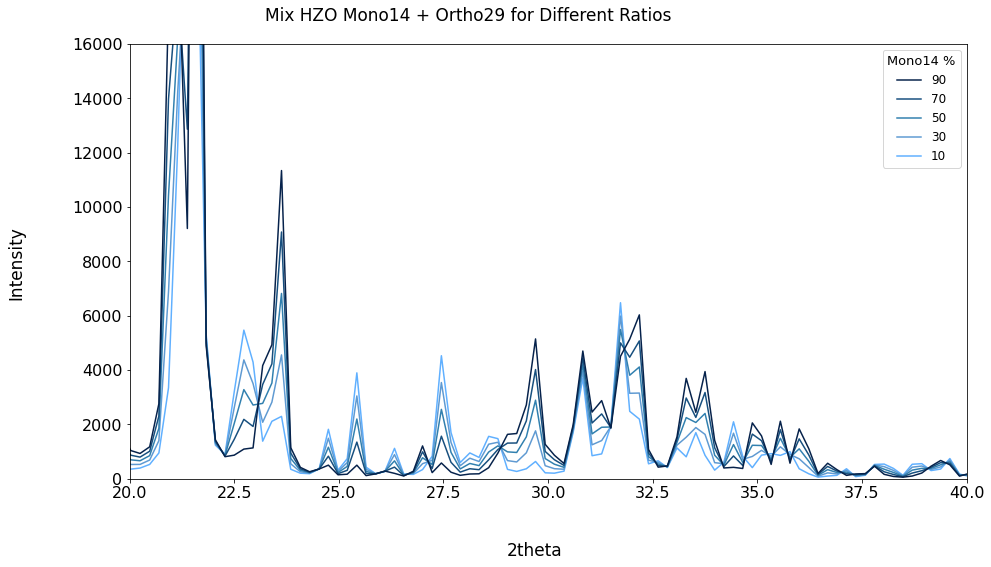

In [532]:
ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

darker = 0.7

HZO_ortho29_DRX_DFT = DFT_DRXs['HZO_ATAT_ortho29_24atoms-288']
HZO_mono14_DRX_DFT = DFT_DRXs['atat_HZO_SC_mono14_-288']

deux_theta = (HZO_ortho29_DRX_DFT["2Theta (DEG)"] + HZO_mono14_DRX_DFT["2Theta (DEG)"])/(2)

colors = plt.cm.Blues(np.linspace(0, 1, len(ratios)))

fig, ax = plt.subplots(figsize=(15,8)) 

for i, j in zip(ratios, colors):
    
    av = HZO_mono14_DRX_DFT["Intensity-LP-DW  (a.u.)"]*i + HZO_ortho29_DRX_DFT["Intensity-LP-DW  (a.u.)"]*(1-i)
        
    ax.plot(deux_theta, av, c=adjust_lightness(j, darker), 
         label=round(i*100))
    
ax.set_xlim(20, 40)
ax.set_ylim(0, 16000)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Mono14 %', title_fontsize= 13, fontsize=12)

fig.text(0.25, 0.92, 'Mix HZO Mono14 + Ortho29 for Different Ratios', fontsize = 17)
fig.text(0.5, 0, '2theta', ha='center', va='center', fontsize = 17)
fig.text(0.02, 0.5, 'Intensity', ha='center', va='center', rotation='vertical', fontsize = 17)


# put_freq(wvn, ortho29_norm, color="black", shift_wvn=-5, shift_Abs=2)
# put_freq(wvn, mono14_norm, color="red", shift_wvn=-5, shift_Abs=2)

['HZO11_background_removal\\HZO11_XRD_final_Tamb_phi.txt', 'HZO11_background_removal\\HZO11_XRD_final_Tamb_qz.txt', 'HZO11_background_removal\\HZO11_XRD_final_Thaute_phi.txt', 'HZO11_background_removal\\HZO11_XRD_final_Thaute_qz.txt']


Text(0.02, 0.5, 'Intensity')

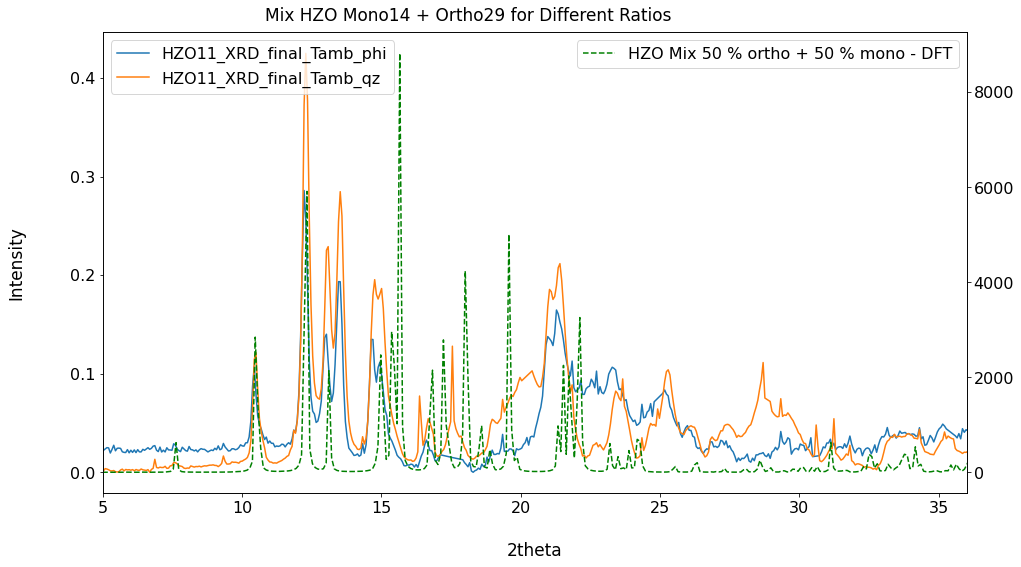

In [501]:
HZO_ortho29_DRX_DFT = DFT_DRXs['HZO_ATAT_ortho29_24atoms-279']
HZO_mono14_DRX_DFT = DFT_DRXs['atat_HZO_SC_mono14_279']

deux_theta = (HZO_ortho29_DRX_DFT["2Theta (DEG)"] + HZO_mono14_DRX_DFT["2Theta (DEG)"])/(2*2.2985)

fig, ax = plt.subplots(figsize=(15,8)) 

av = HZO_mono14_DRX_DFT["Intensity-LP-DW  (a.u.)"]*0.5 + HZO_ortho29_DRX_DFT["Intensity-LP-DW  (a.u.)"]*0.5


filenames = glob.glob("HZO11_background_removal/*.txt")
print(filenames)

for file in filenames:
    data = np.loadtxt(file)
    if "Thaute" in list(file.split("_")):
        continue
    else:
        ax.plot(data[:, 0], data[:, 1], label=file[25:-4])
        
ax_0=ax.twinx()     
ax_0.plot(deux_theta, av,
          label='HZO Mix 50 % ortho + 50 % mono - DFT',
          linestyle='--',
          c='green')
ax_0.set(xlim=(0, 40))   
        
ax.legend(loc='upper left')        
ax_0.legend(loc='upper right') 

   
ax.set_xlim(5, 36)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0)


fig.text(0.25, 0.92, 'Mix HZO Mono14 + Ortho29 for Different Ratios', fontsize = 17)
fig.text(0.5, 0, '2theta', ha='center', va='center', fontsize = 17)
fig.text(0.02, 0.5, 'Intensity', ha='center', va='center', rotation='vertical', fontsize = 17)

## Creating a CIF file using our DFT results:


## Making new files for Claudia
- did not work
- we asked Nita to convert in his code in the end

In [13]:
HZO11_Claudia = np.loadtxt('FINAL_Background_Removal/HZO11_Tamb_phi.txt')
HZO11_Claudia[:, 1]

array([0.02243021, 0.02003315, 0.0213731 , 0.02127005, 0.02303299,
       0.02058394, 0.02207688, 0.02488083, 0.02027177, 0.02526672,
       0.02361767, 0.02172161, 0.02285256, 0.0275705 , 0.02241745,
       0.02223439, 0.02352634, 0.02495629, 0.02469623, 0.01951618,
       0.02318012, 0.02739507, 0.02177201, 0.02429696, 0.02450291,
       0.02420085, 0.0207908 , 0.02015574, 0.02003169, 0.02295863,
       0.01969658, 0.02233553, 0.02014247, 0.02265242, 0.01992936,
       0.02291031, 0.02065625, 0.0206552 , 0.02326315, 0.02227309,
       0.02355804, 0.02490198, 0.02328193, 0.02426087, 0.02649582,
       0.02700677, 0.02236771, 0.02098566, 0.0255126 , 0.02052555,
       0.0224155 , 0.02058744, 0.02485539, 0.02266433, 0.02260328,
       0.02230322, 0.02891517, 0.02747712, 0.02349406, 0.02204201,
       0.02093995, 0.0253779 , 0.02358984, 0.02193979, 0.02138974,
       0.02612268, 0.02301963, 0.02272957, 0.02165552, 0.02269246,
       0.02065241, 0.02277836, 0.0239753 , 0.02328125, 0.02324

In [29]:
len(HZO11_Claudia[:, 1]*100000)

519

In [30]:
test = HZO11_Claudia[:, 1]*100000

In [34]:
test1 = test[:52]
test2 = test[52:202]
test3 = test[202:252]
test4 = test[252:202]
test5 = test[202:252]
test6 = test[252:302]
test7 = test[302:352]
test8 = test[352:402]
test9 = test[402:452]
test10 = test[452:520]

In [36]:
np.savetxt("test1.txt", 
           np.column_stack([test1, test2, test3, test4, test5, test6, test7, test8, test9, test10]), 
                            fmt='%i', newline="    ")

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 52 and the array at index 1 has size 150

In [28]:
np.savetxt("test1.txt", (HZO11_Claudia[:, 1]*100000).flatten(), fmt='%i', newline="    ")